In [1]:
# Import relevant packages
import uproot
import vector
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.colors as colors
from scipy.stats import norm

In [2]:
f=uproot.open("/Users/isaac/Desktop/mucolstudies/ntup_collectionsNoBIB.root")

In [3]:
print(f.keys())

['tracks_tree;1']


In [109]:
tree=f["tracks_tree"]
treeBIB=uproot.open("/Users/isaac/Desktop/mucolstudies/ntup_hitsBIB1[123]0.root")["tracks_tree"]
treeNOBIB=uproot.open("/Users/isaac/Desktop/mucolstudies/ntup_hitsNoBIB.root")["tracks_tree"]

In [110]:
print(f["tracks_tree"].keys())

['x', 'y', 'z', 't', 'barOrEnd', 'location', 'module', 'layer', 'side']


In [6]:
# a handy plotting function
def plot1DHistogram(data,bins,scale='linear',label="", savefig=False, dpi=300):
    
    # handle data, there must be a smarter way to do this...
    if type(data[0])==np.int64 : data_flat=data
    elif type(data[0])==np.float32 : data_flat=data
    elif type(data[0])==np.float64 : data_flat=data
    else: data_flat = ak.flatten(data)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    ax.hist(data_flat, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [7]:
# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label="", savefig=False, dpi=300):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [84]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.major.size' : 10}) 
plt.rcParams.update({'ytick.major.size' : 10}) 
plt.rcParams.update({'xtick.minor.size' : 5}) 
plt.rcParams.update({'ytick.minor.size' : 5}) 
plt.rcParams.update({'axes.labelsize' : "large"}) 

# Investigating the meaning of our different keys

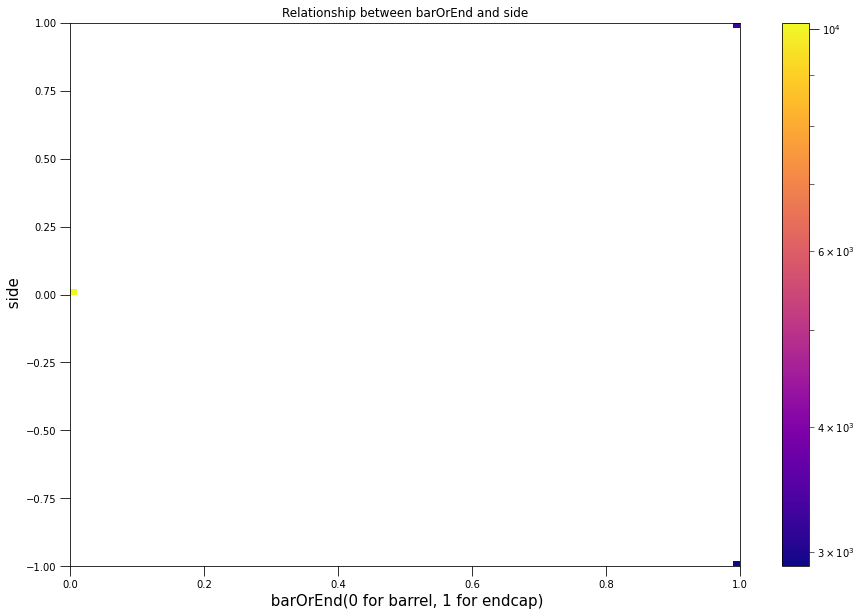

In [9]:
plot2DHistogram(tree["barOrEnd"].array(), tree["side"].array(), label=("Relationship between barOrEnd and side; barOrEnd(0 for barrel, 1 for endcap); side"))

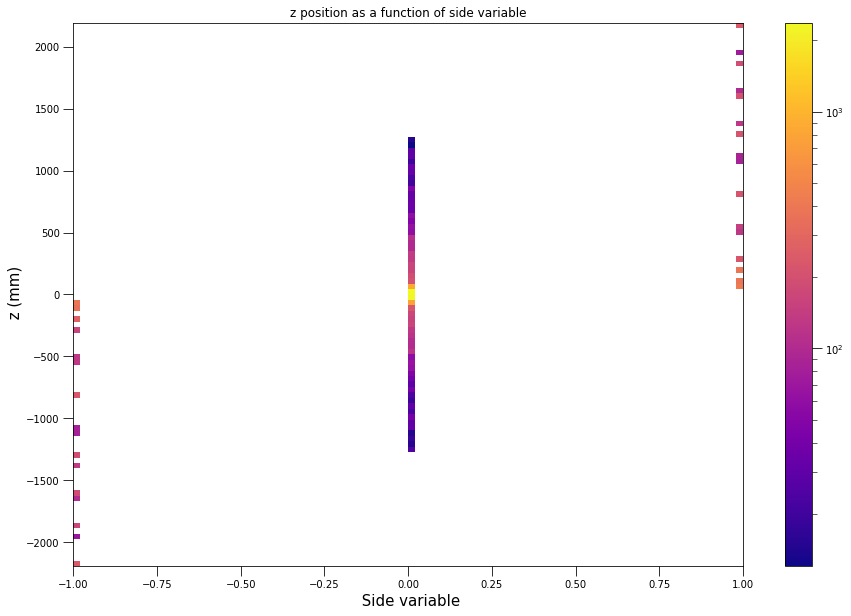

In [10]:
plot2DHistogram(tree["side"], tree["z"], label="z position as a function of side variable; Side variable; z (mm)")

#### barOrEnd was coded to be a 0 if reading a collection that was named "\*BarrelCollection" and a 1 if reading "\*EndcapCollection". Therefore the top graph shows side=0 is equivilent to the hit being in the barrel, while side=1,-1 is equivilent to the hit being on the endcap.
#### The second graph shows that side=1 marks all the hits on endcaps with a positive z and side=-1 marks all the hits on endcaps with a negative z

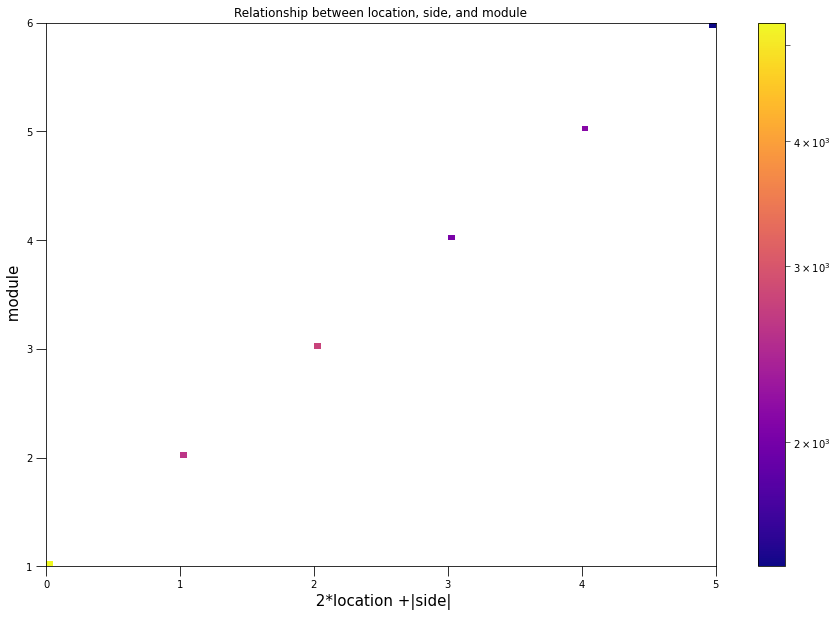

In [11]:
plot2DHistogram(2*tree["location"].array()+np.abs(tree["side"].array()), tree["module"].array(), label="Relationship between location, side, and module; 2*location +|side|; module")

#### I coded location to read 0 if the hit was in the vertex, 1 if the hit was in the inner detector and 2 if the hit was in the outer detector. The above graph shows that module uniquely determines both the detector and if its on the barrel or endcap by assigning each hit 2 times my value for location and then adding 1 if its on the barrel and 2 if its on an endcap.

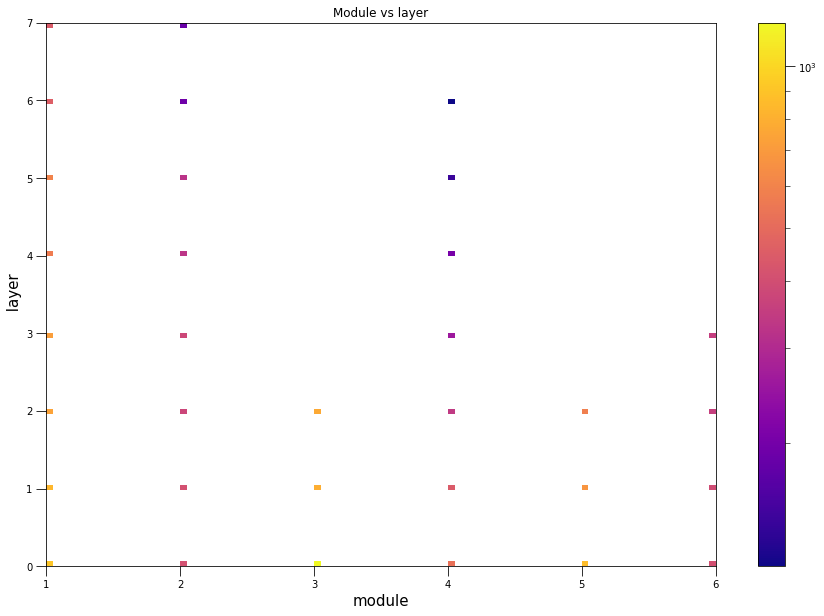

In [12]:
plot2DHistogram(tree["module"].array(),tree["layer"].array(), label="Module vs layer;module; layer")

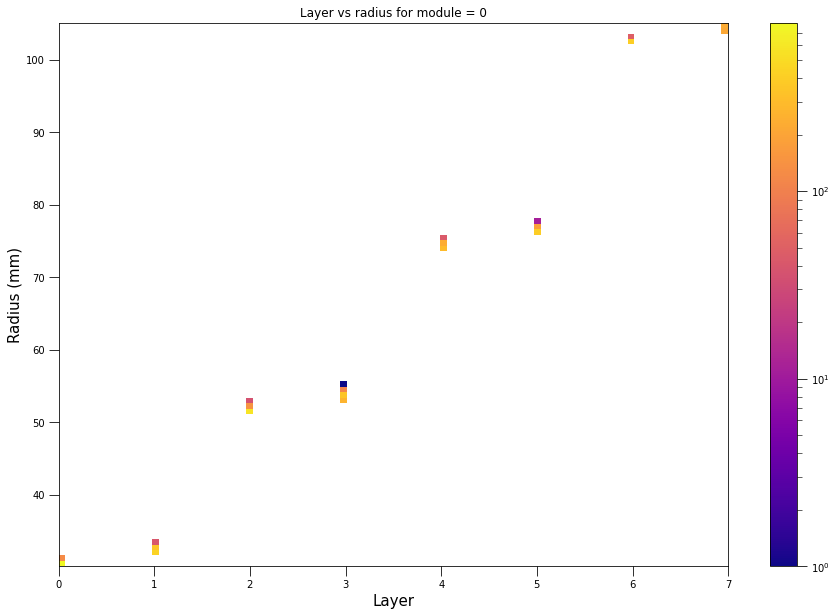

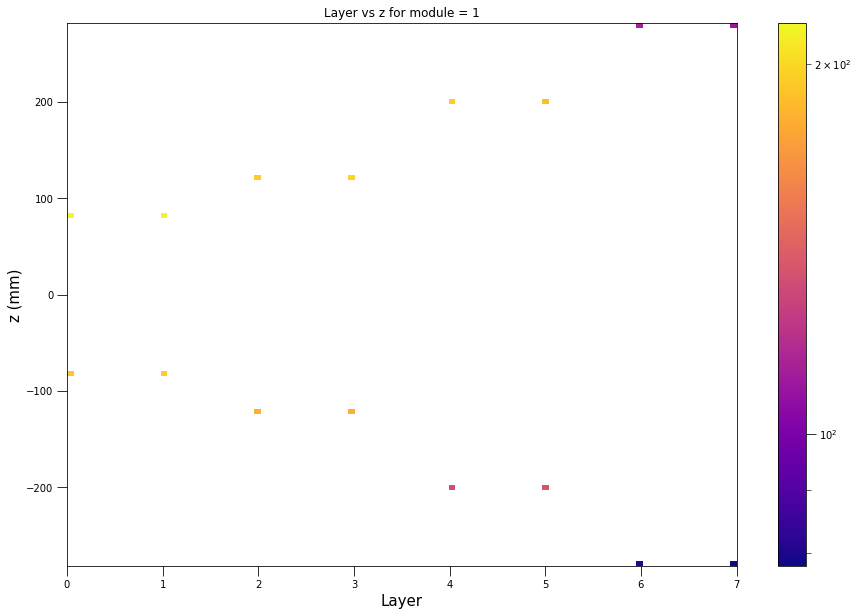

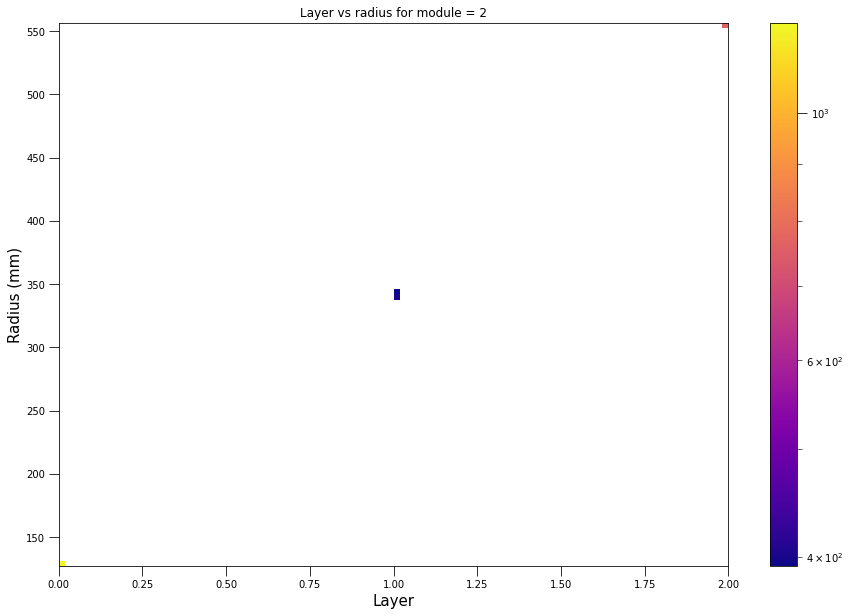

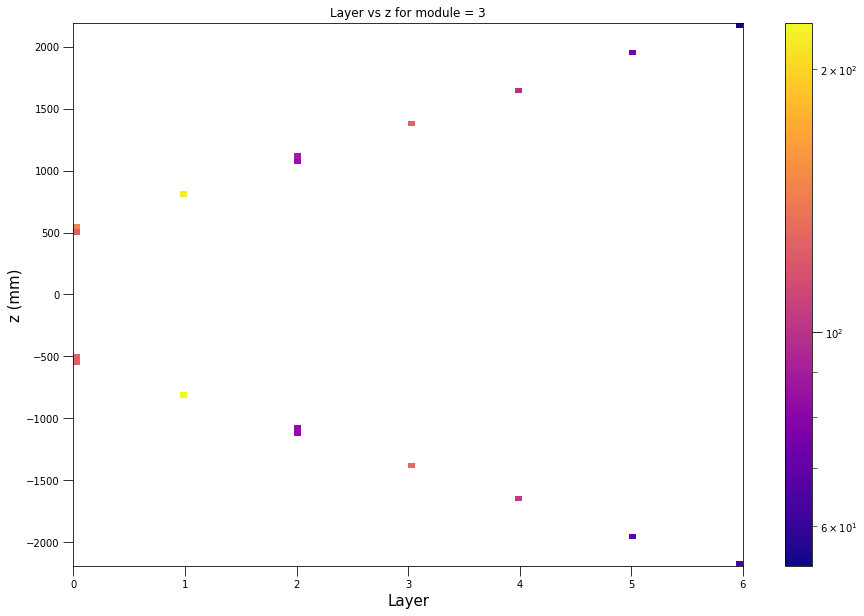

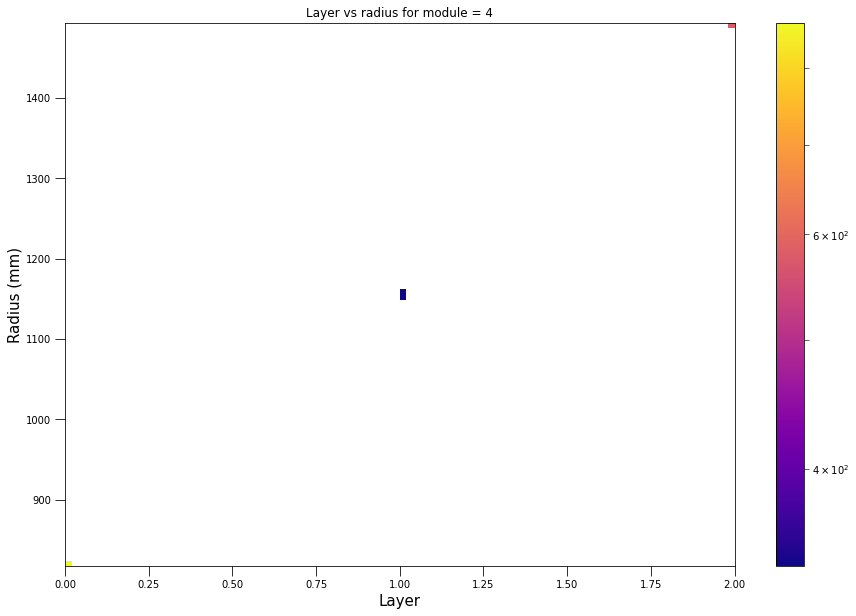

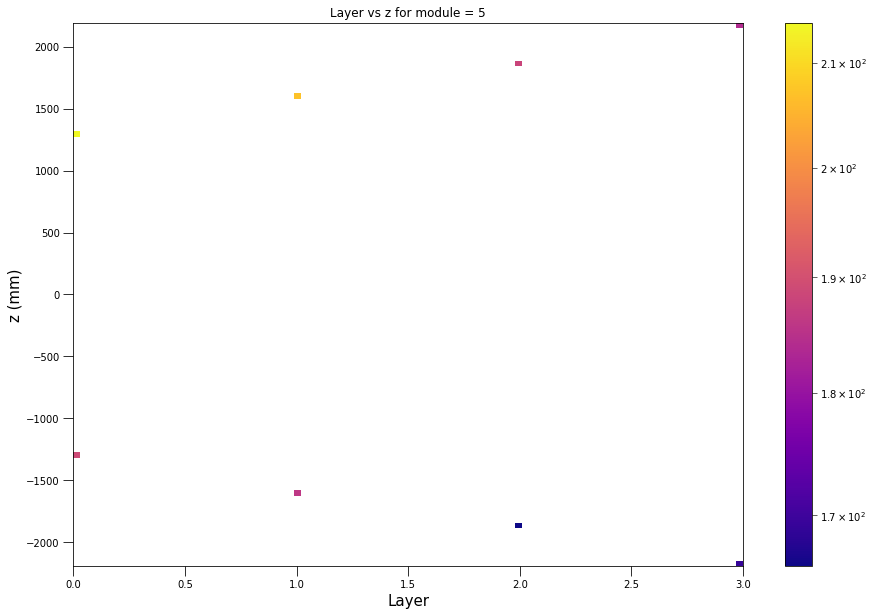

In [13]:
for i in range(6):
    inMod=(tree["module"].array()==(i+1))
    if i %2==0:
        plot2DHistogram(tree["layer"].array()[inMod], np.sqrt(tree["x"].array()[inMod]**2+tree["y"].array()[inMod]**2), bins=100, label=("Layer vs radius for module = "+str(i)+";Layer;Radius (mm)"))
    else:
        plot2DHistogram(tree["layer"].array()[inMod], tree["z"].array()[inMod], bins=100, label=("Layer vs z for module = "+str(i)+";Layer;z (mm)"))

#### The above two graphs show that for each module value, the layer value coorespondes to the individual layers of the detector. Specifically layer=0 being the inner most layer, layer=1 being the second inner most layer, etc.

# Finding the variance of the time distributions per layer

In [14]:
layerPerModule={
    1 : 8,
    2 : 8,
    3 : 3,
    4 : 7,
    5 : 3,
    6 : 4
} #dictionairy to help loop over all layers later

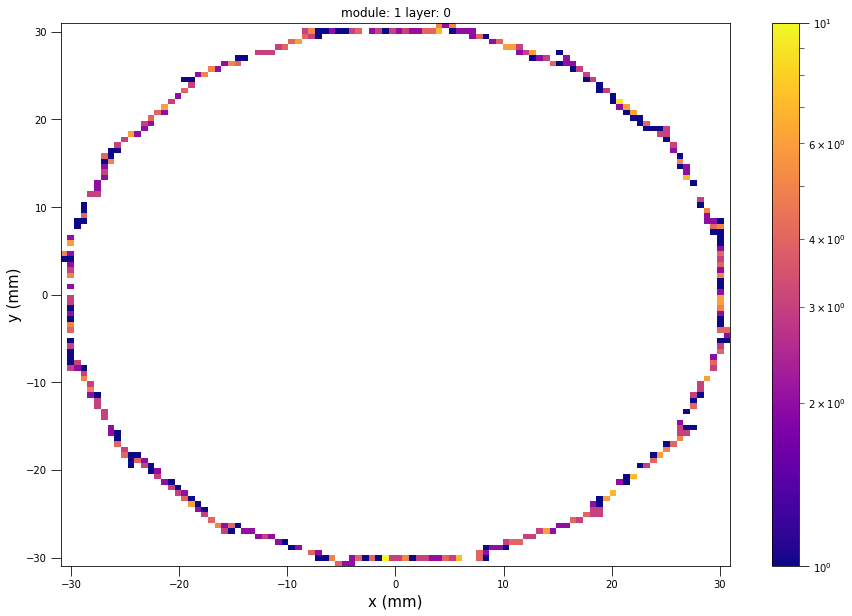

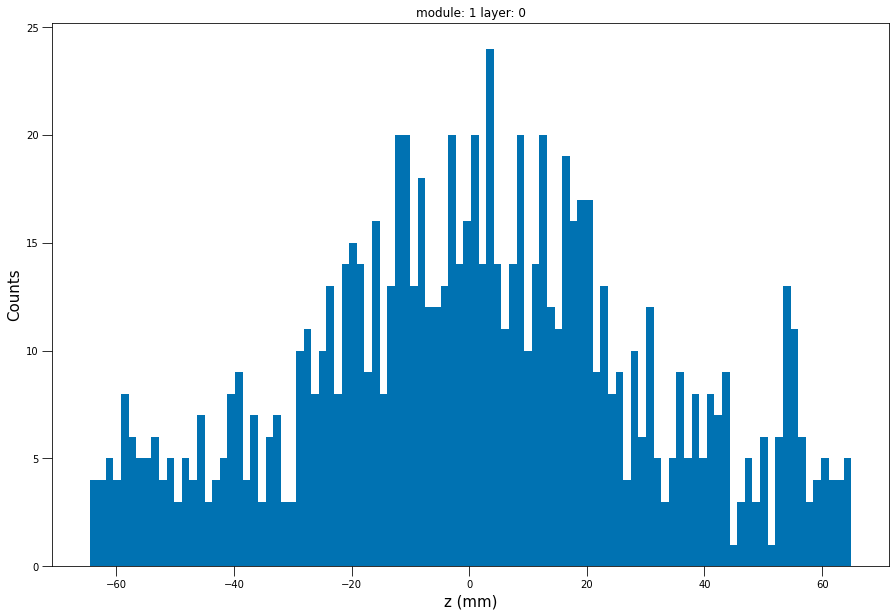

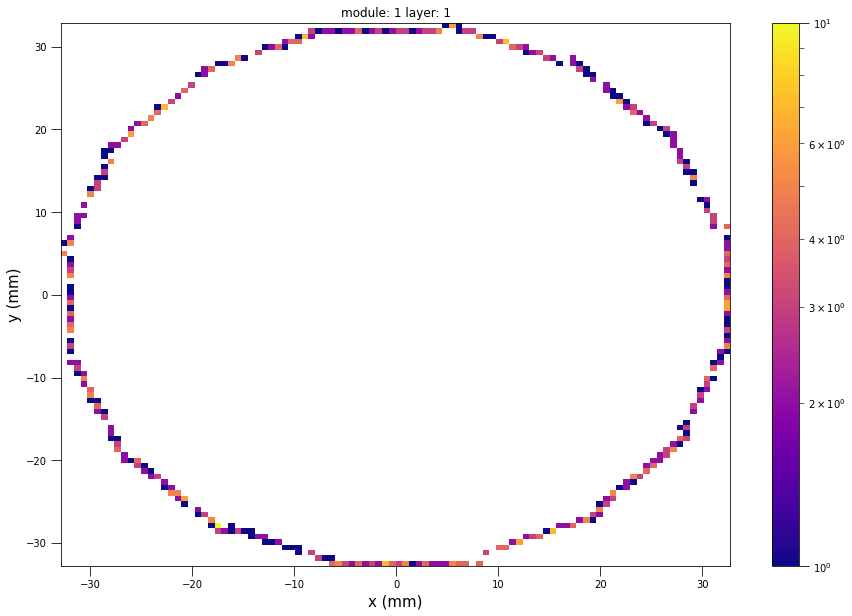

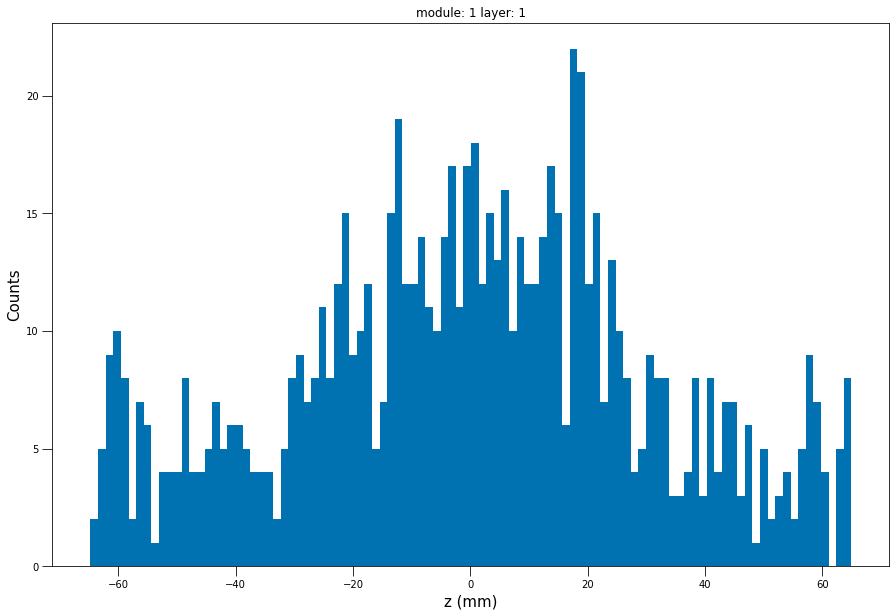

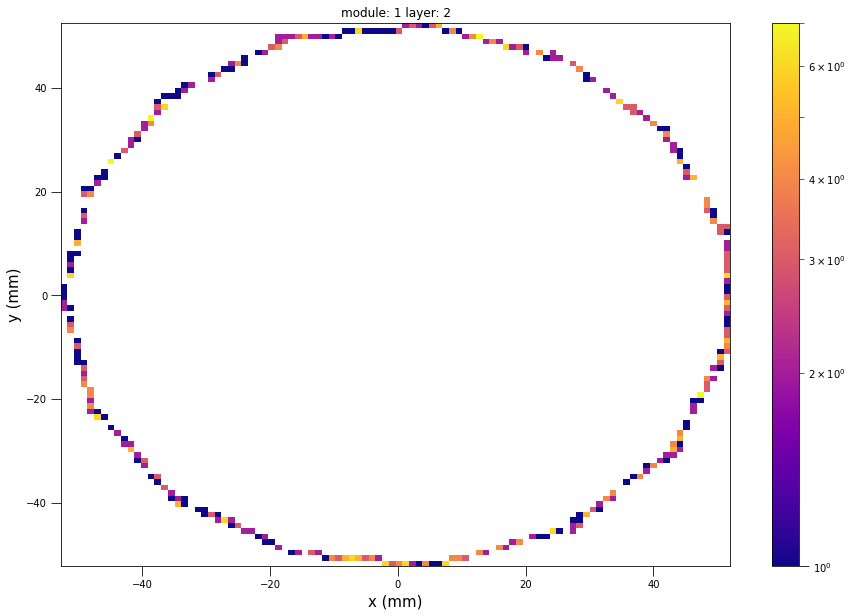

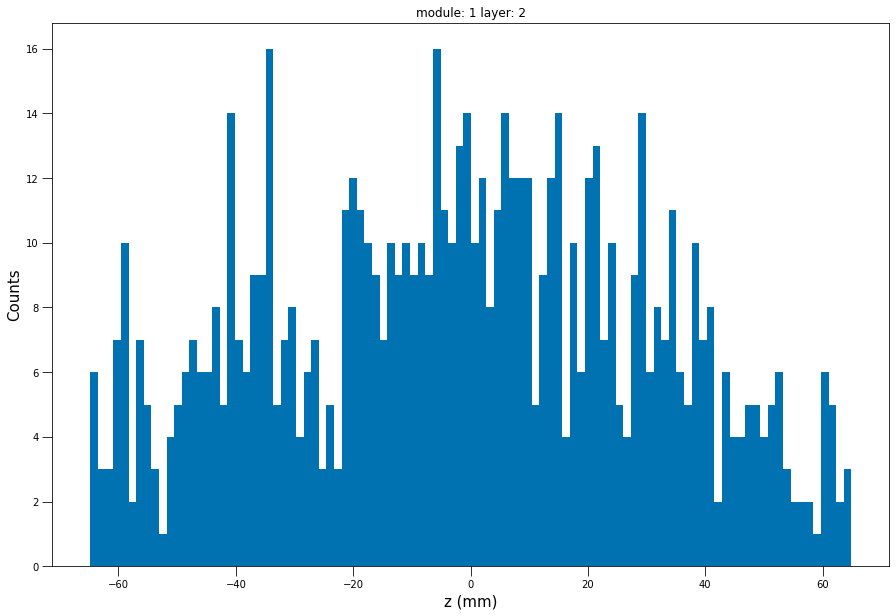

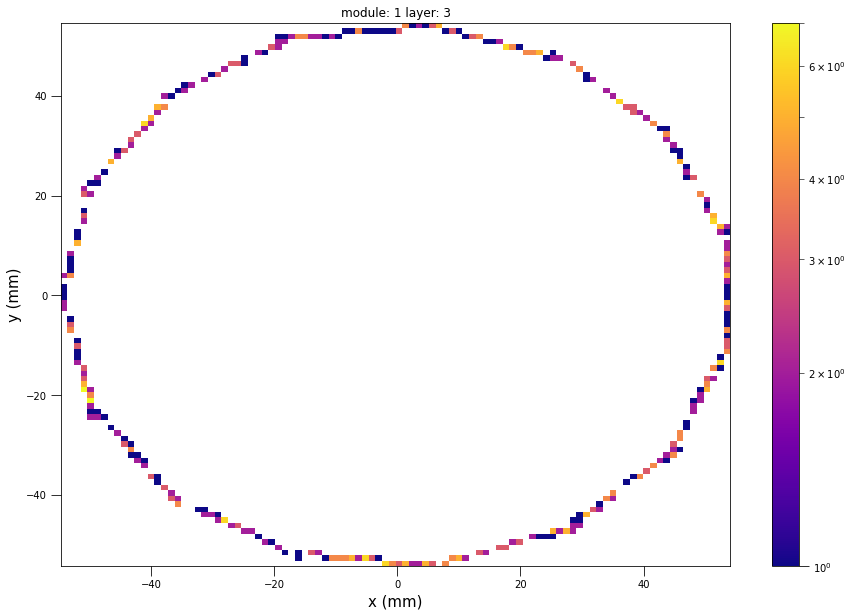

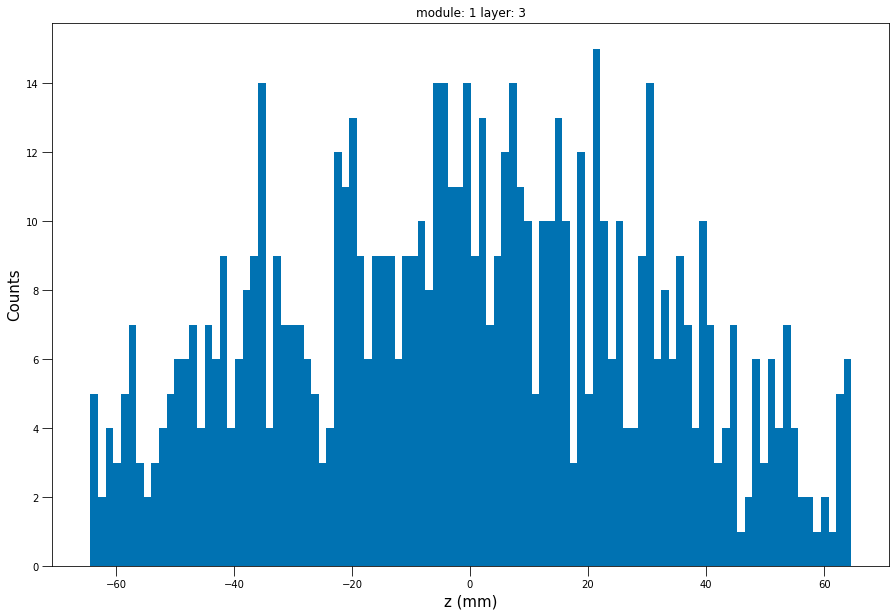

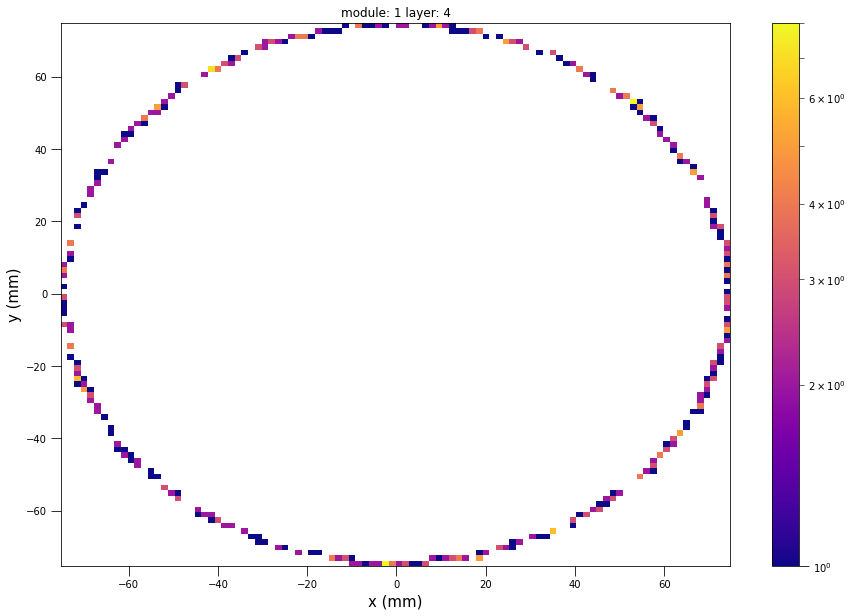

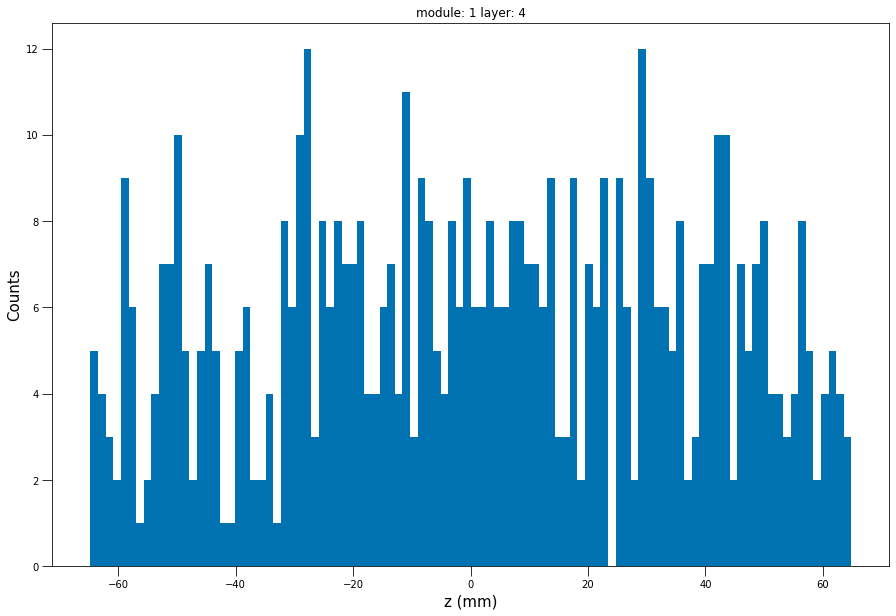

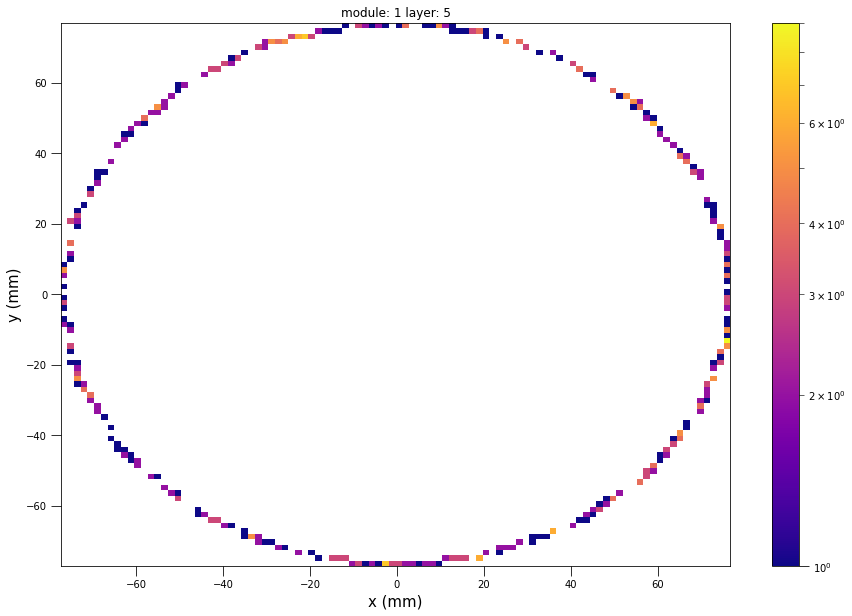

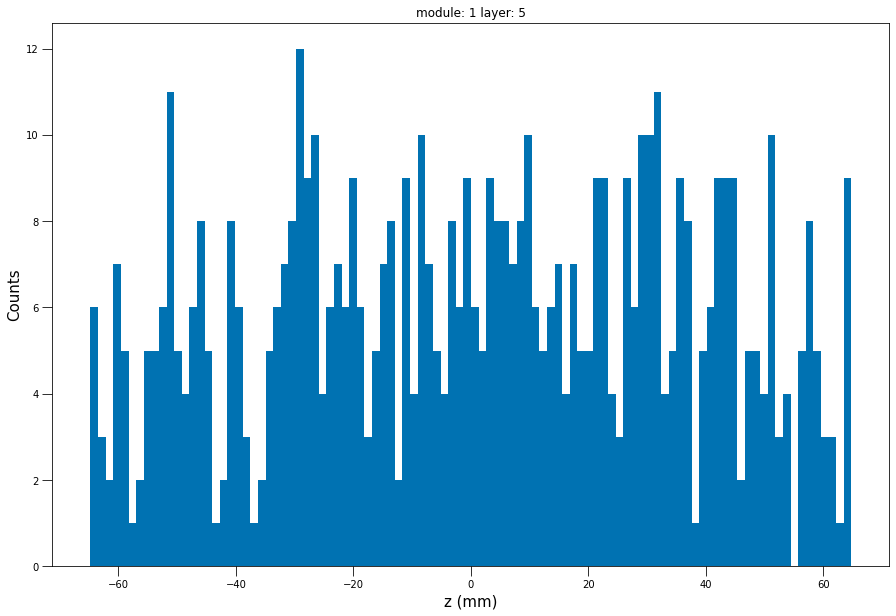

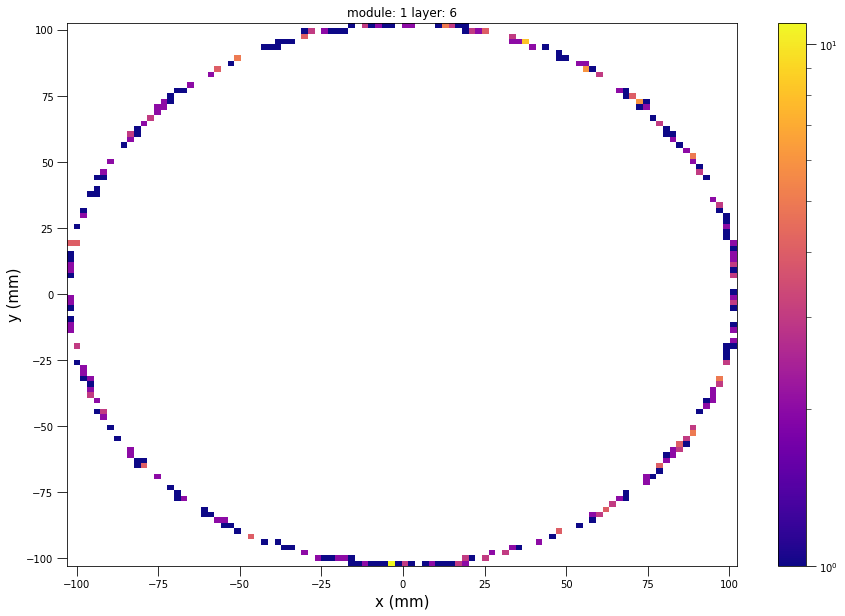

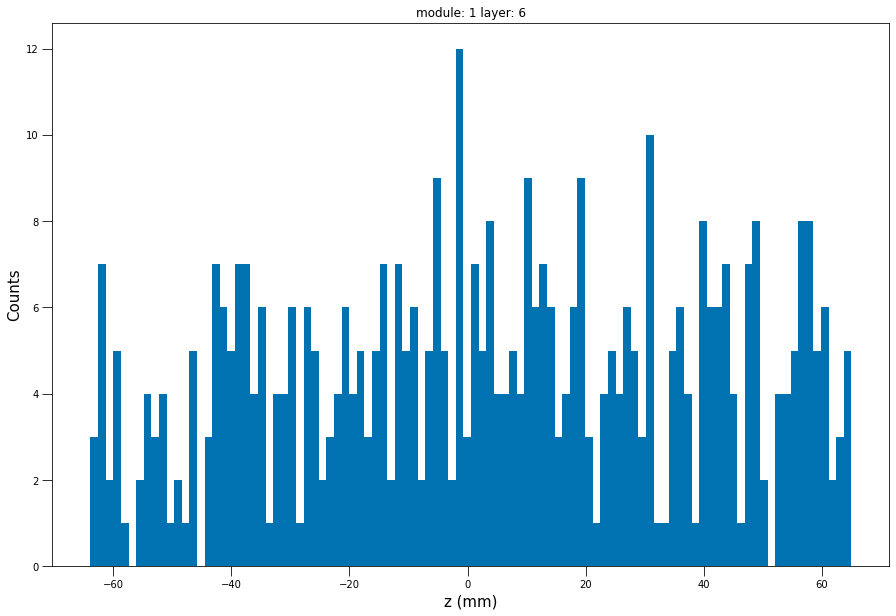

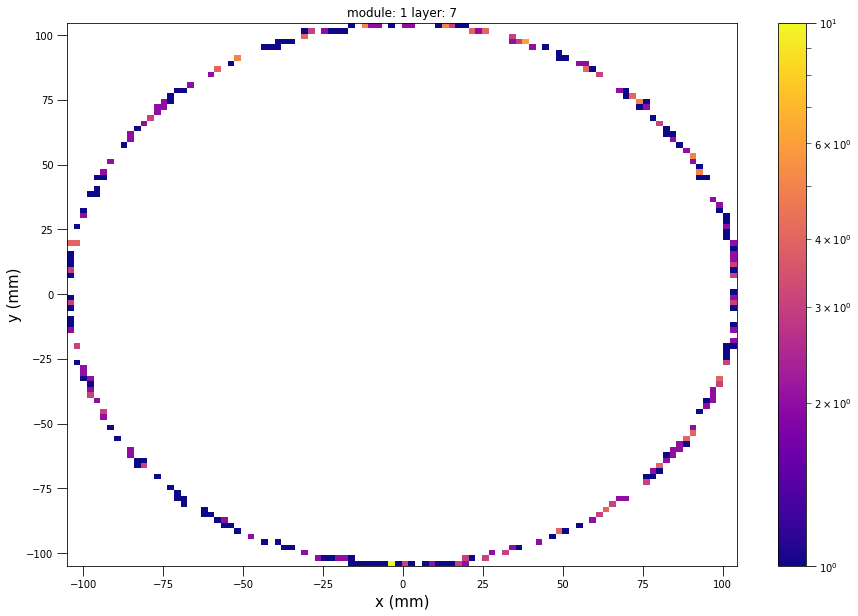

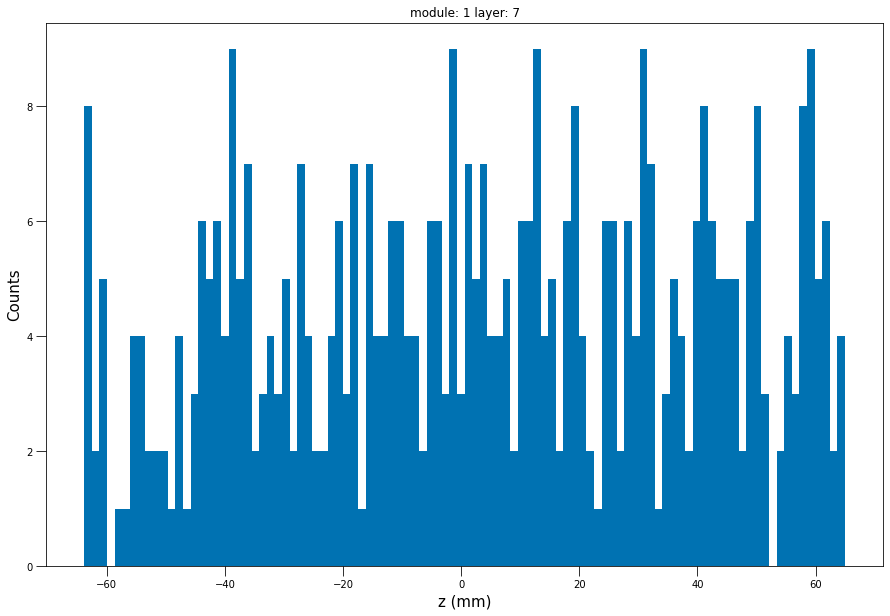

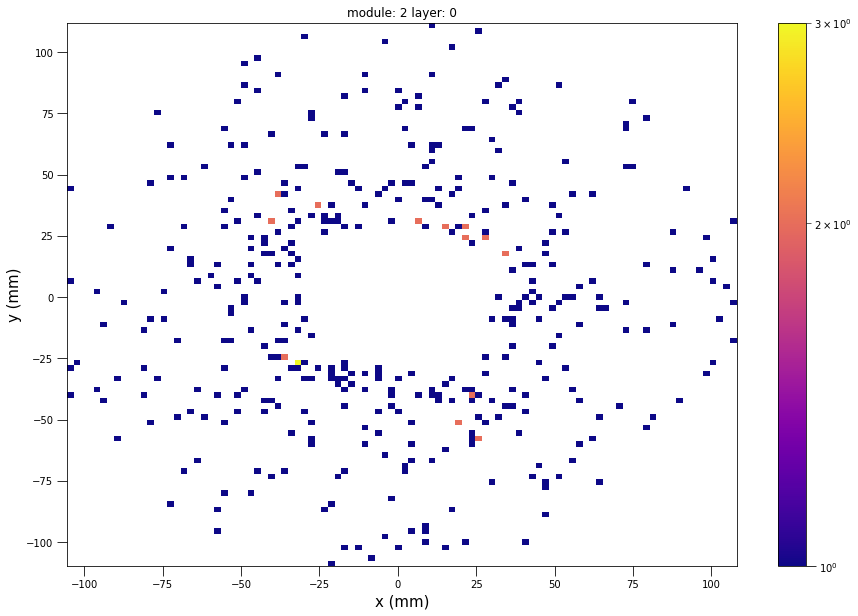

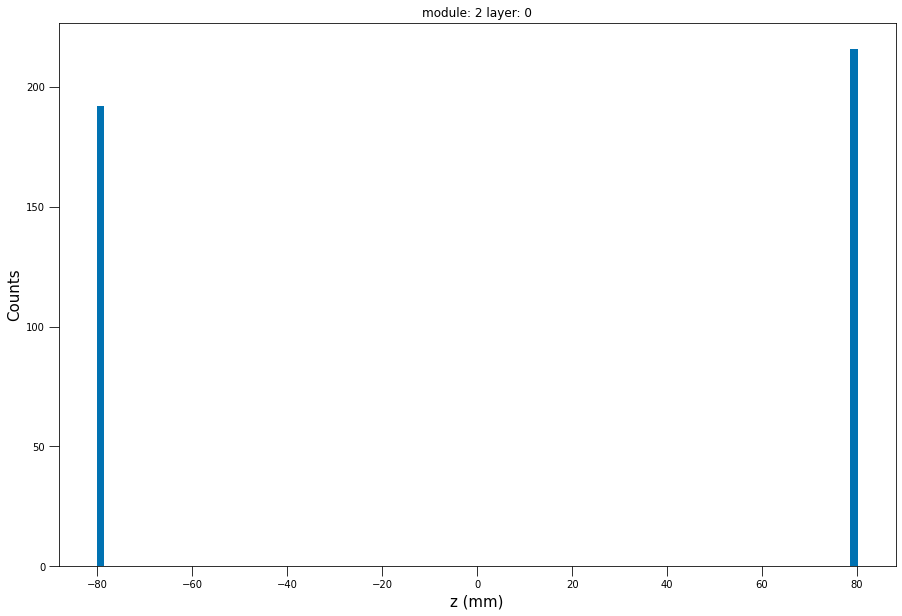

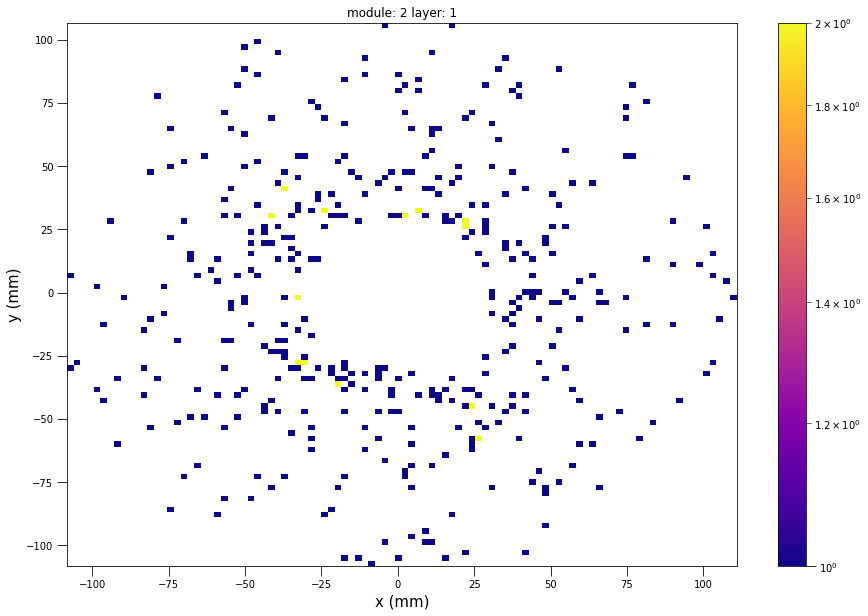

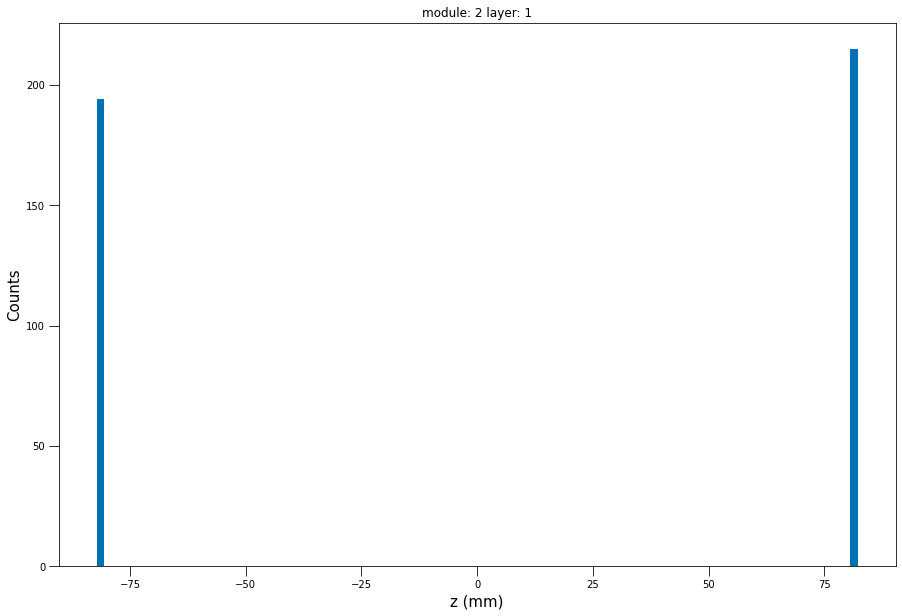

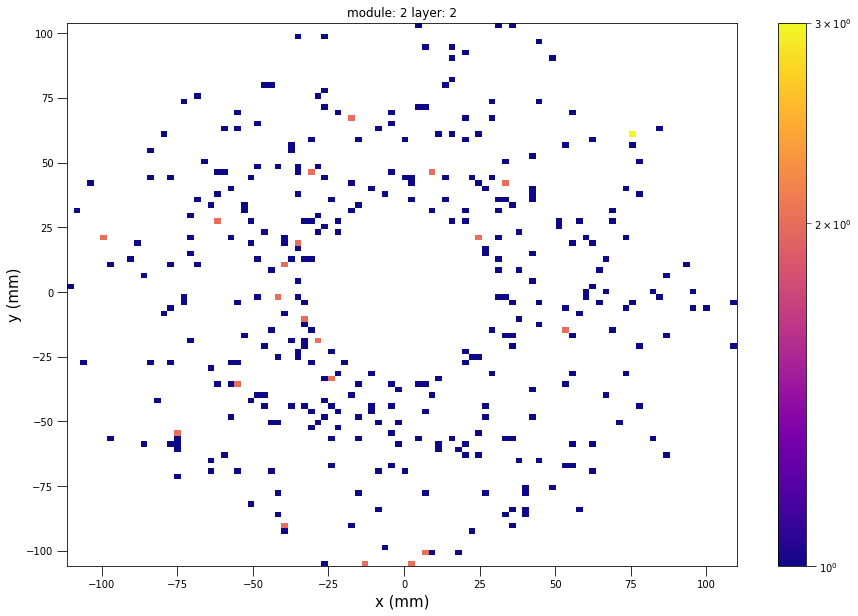

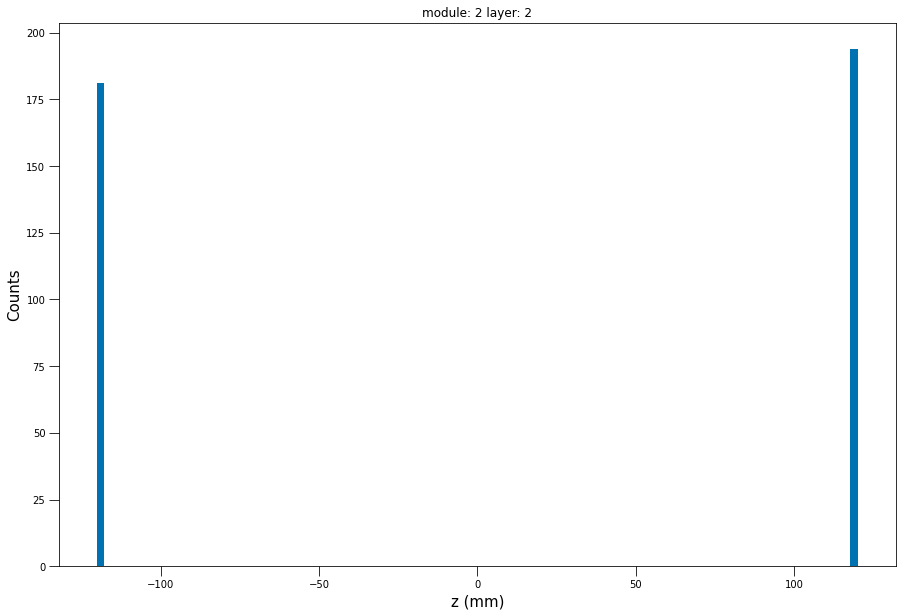

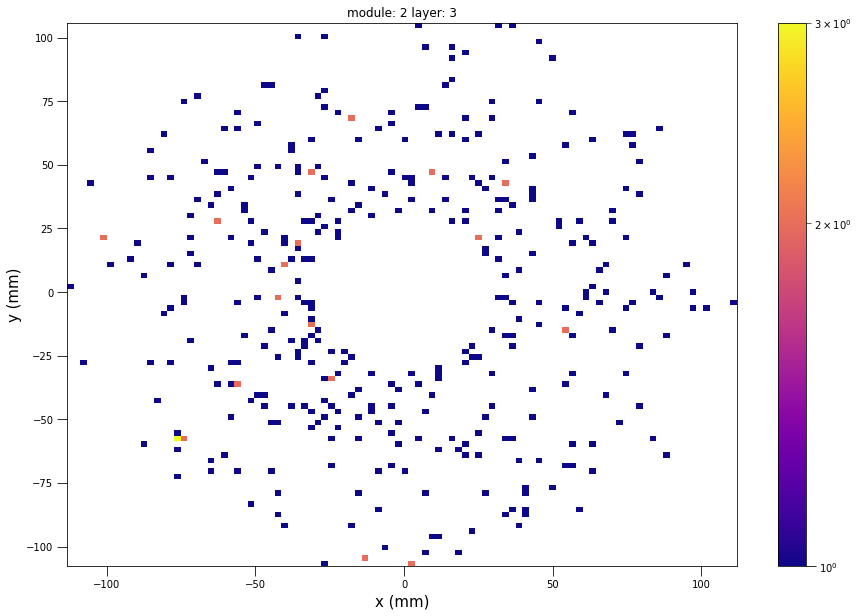

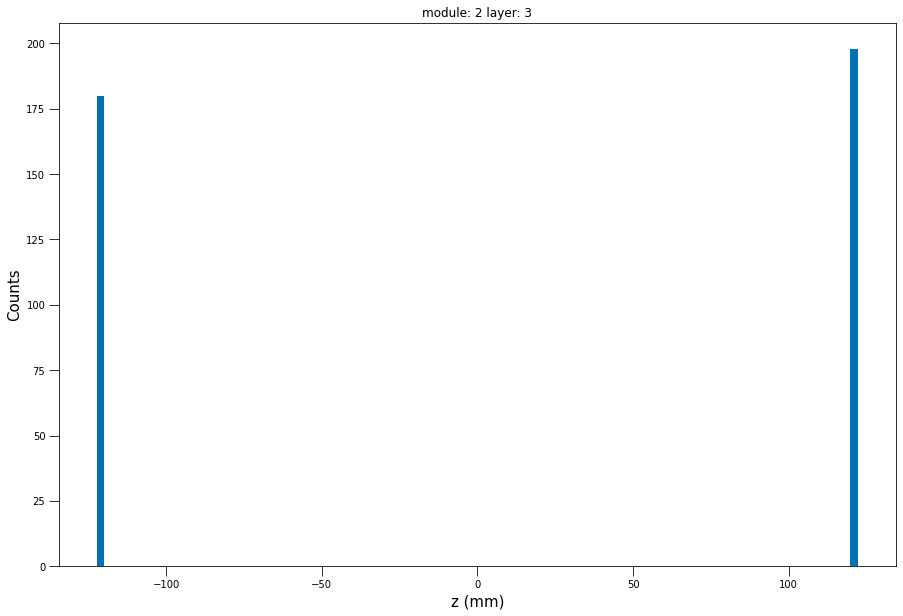

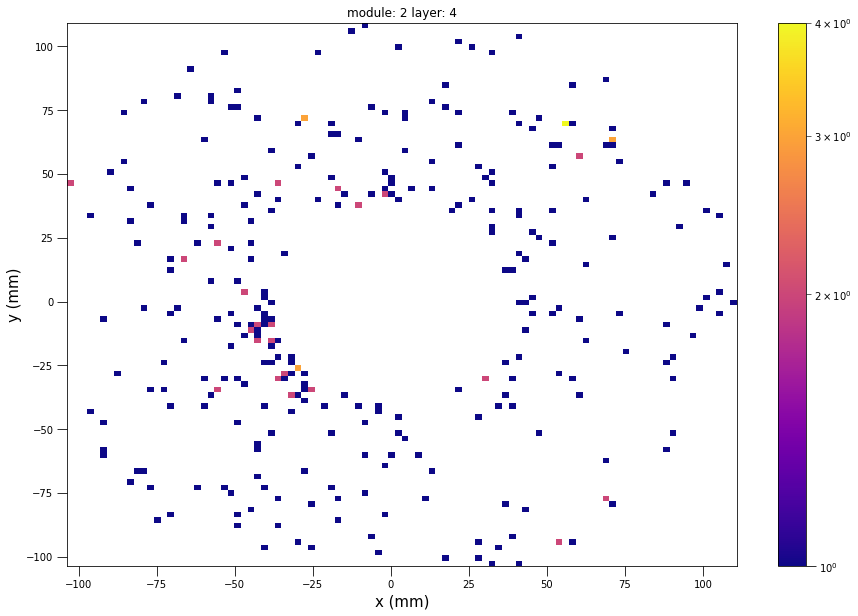

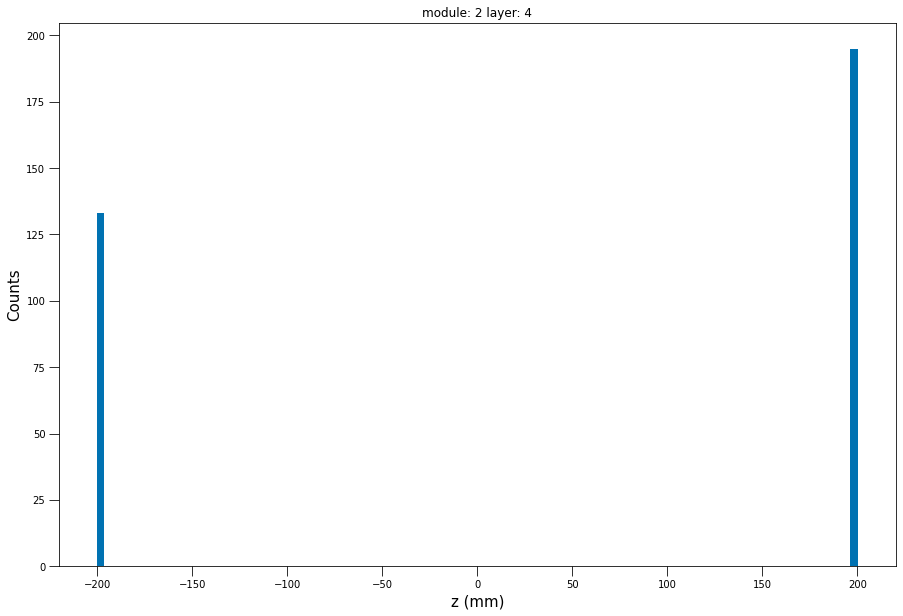

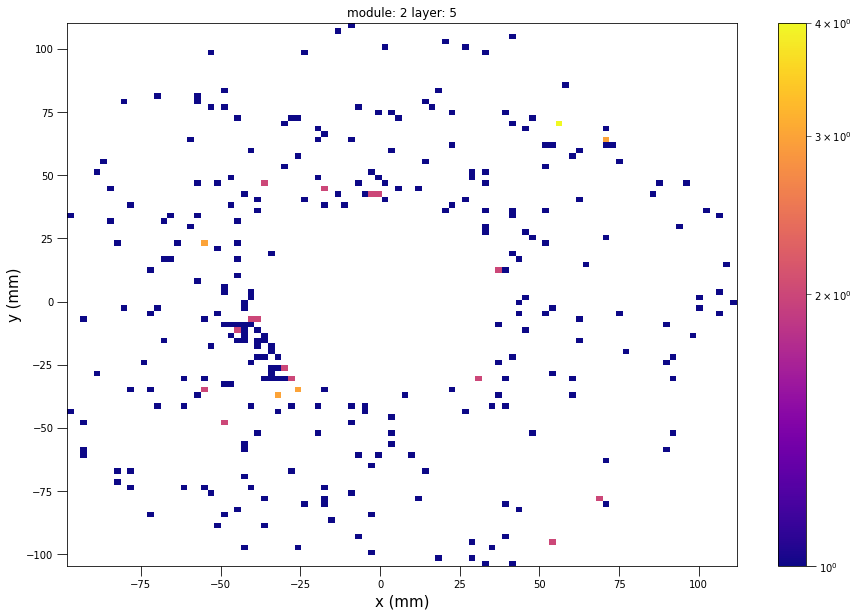

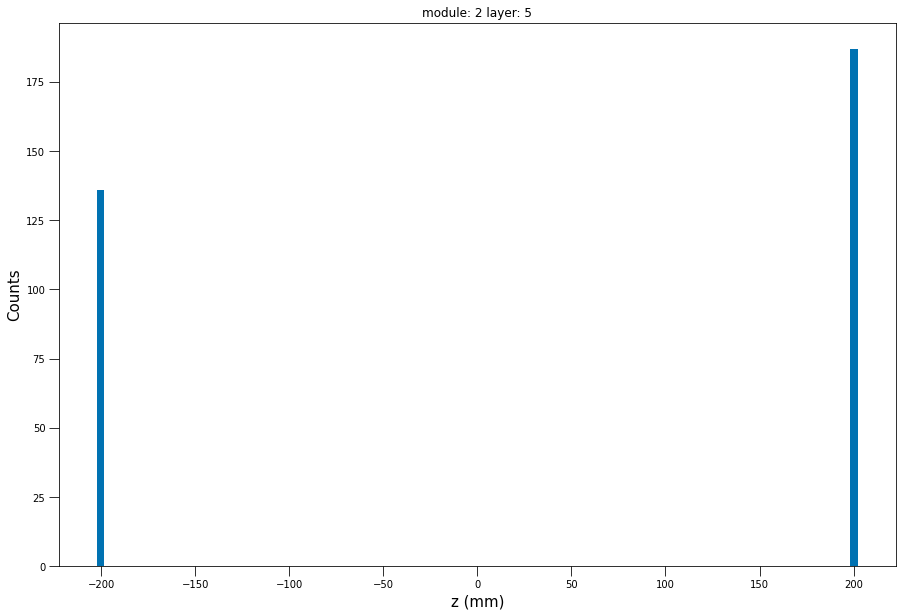

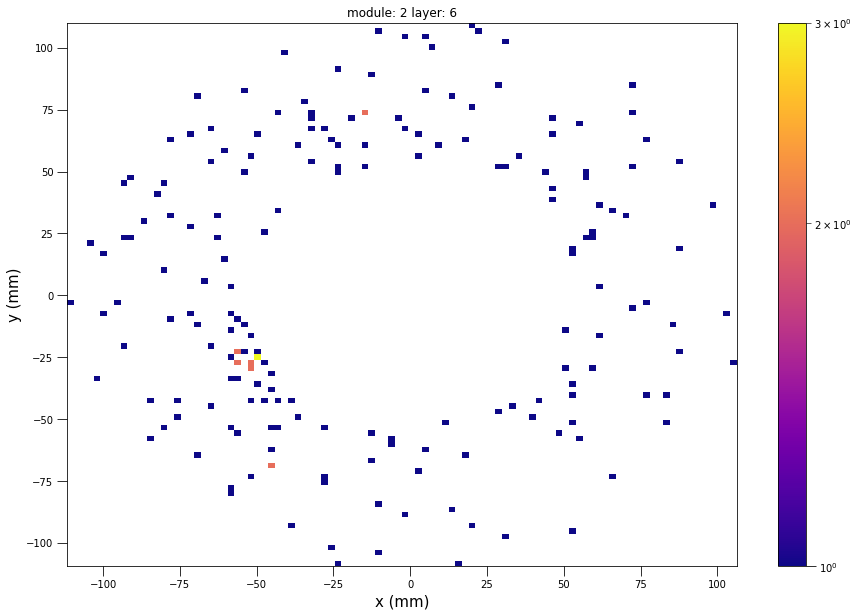

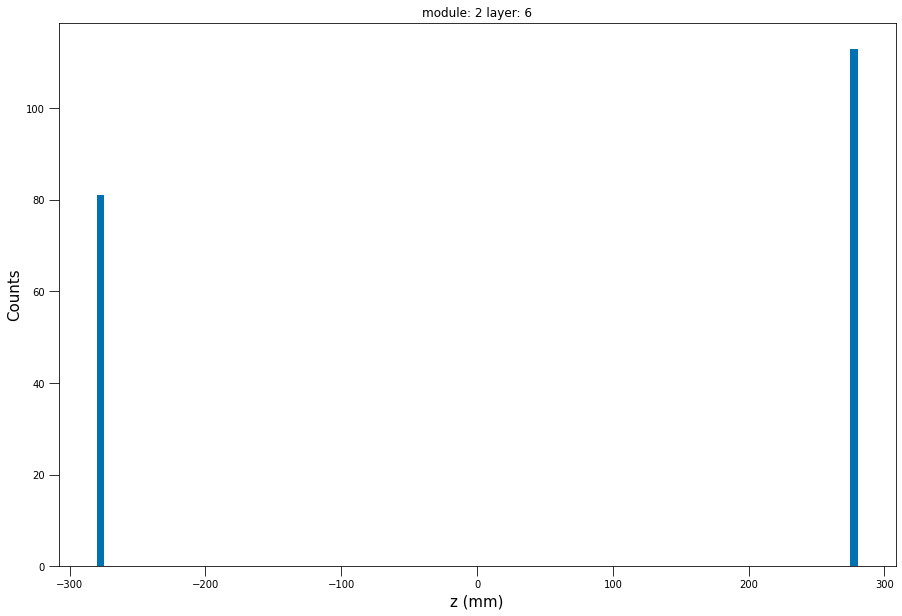

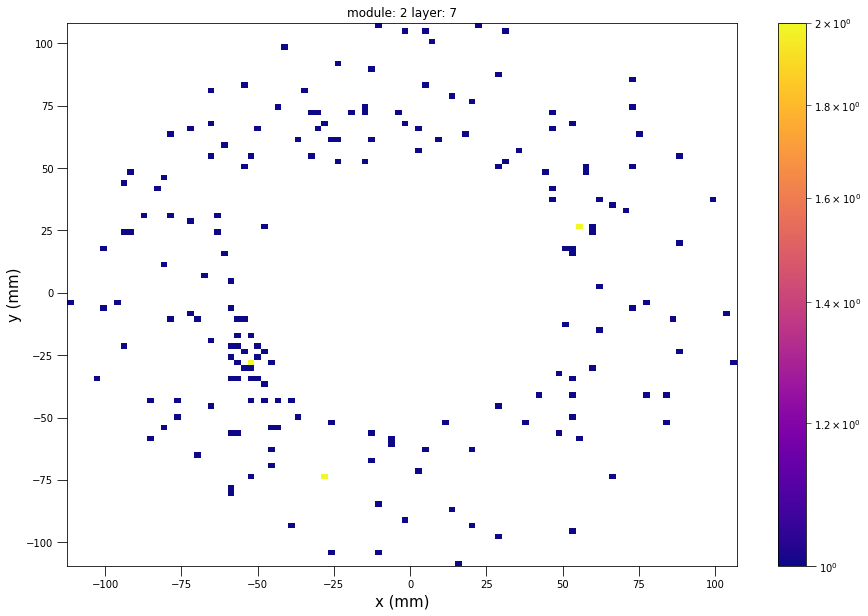

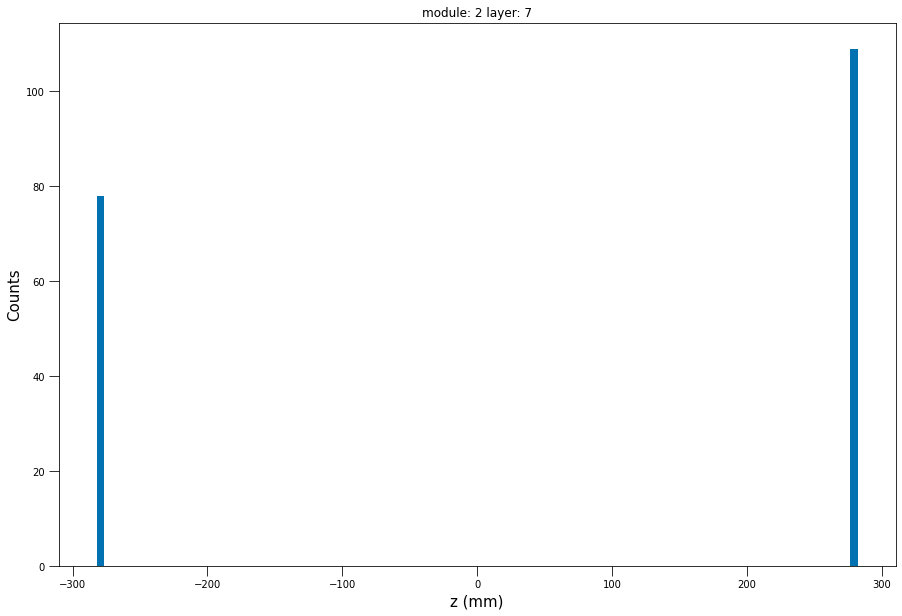

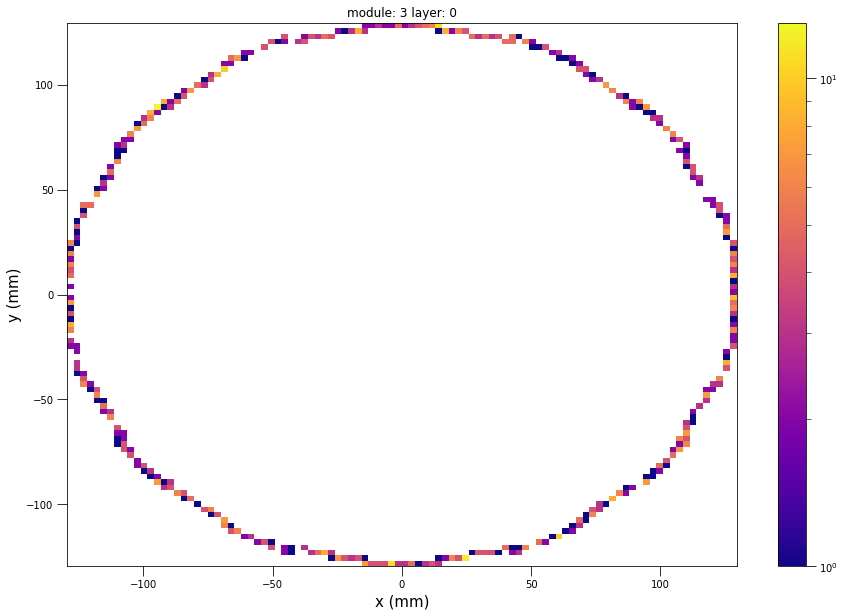

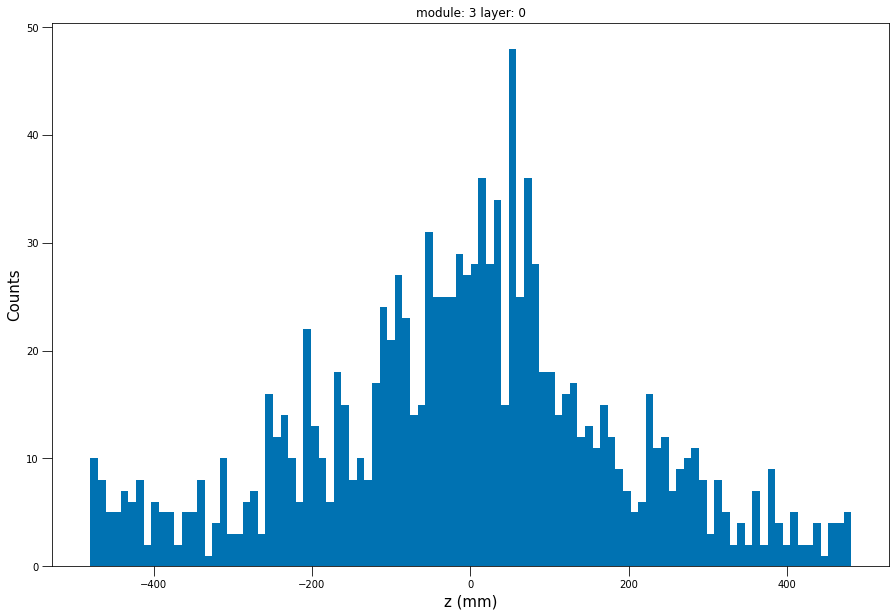

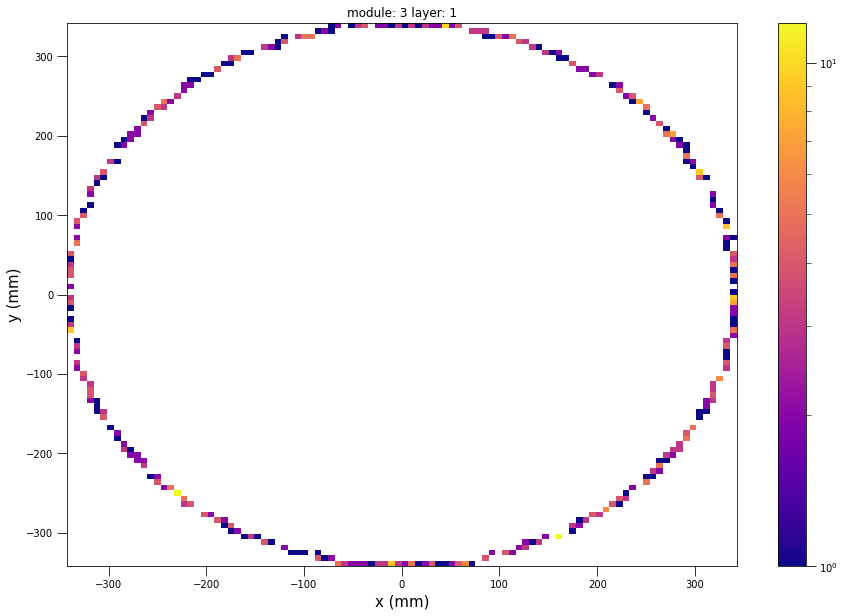

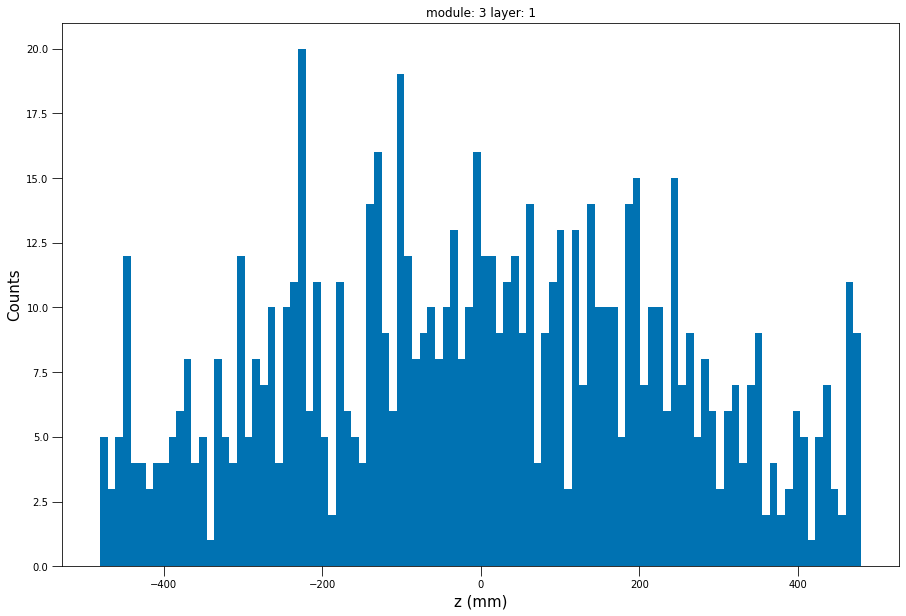

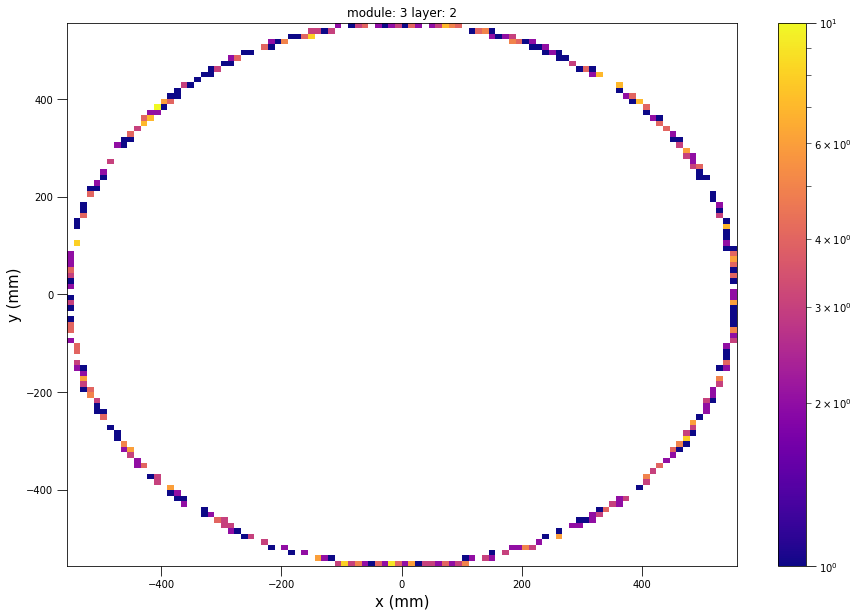

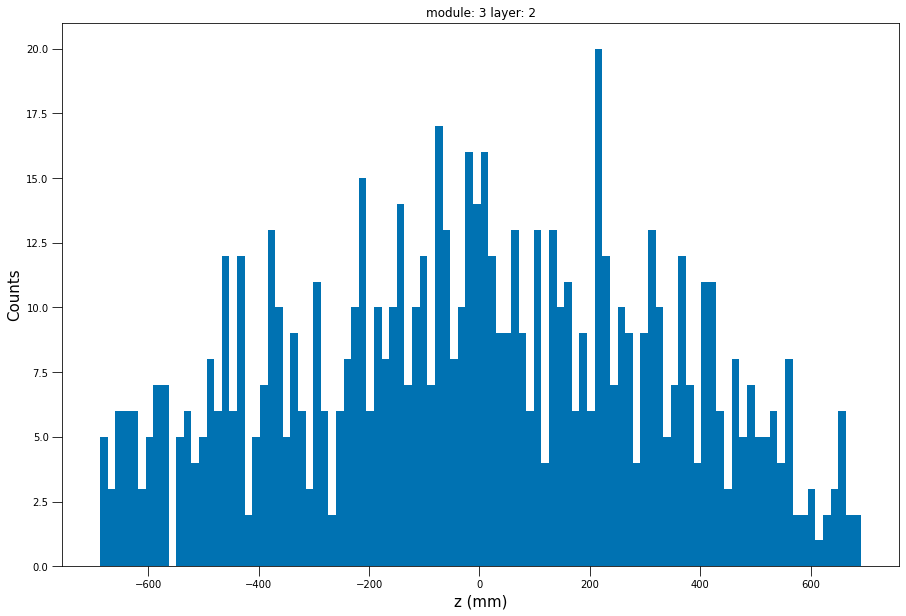

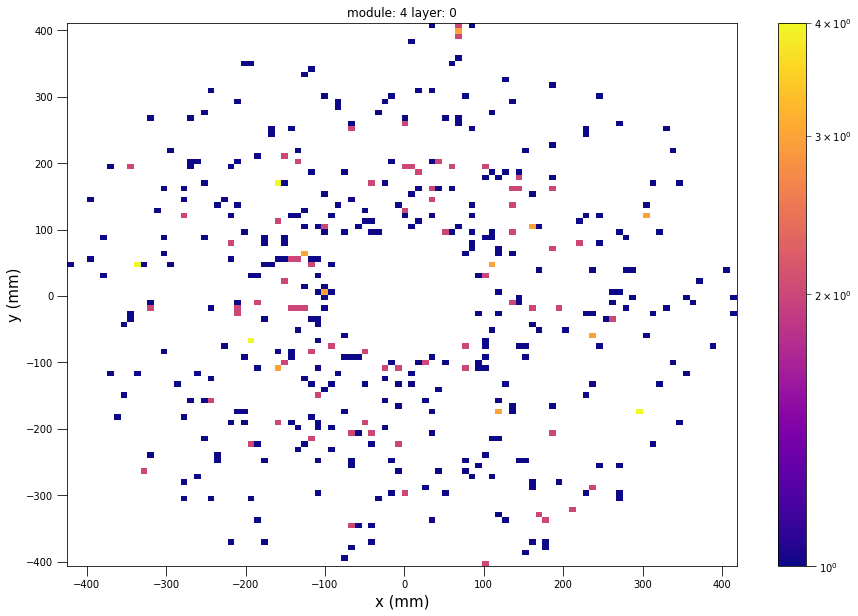

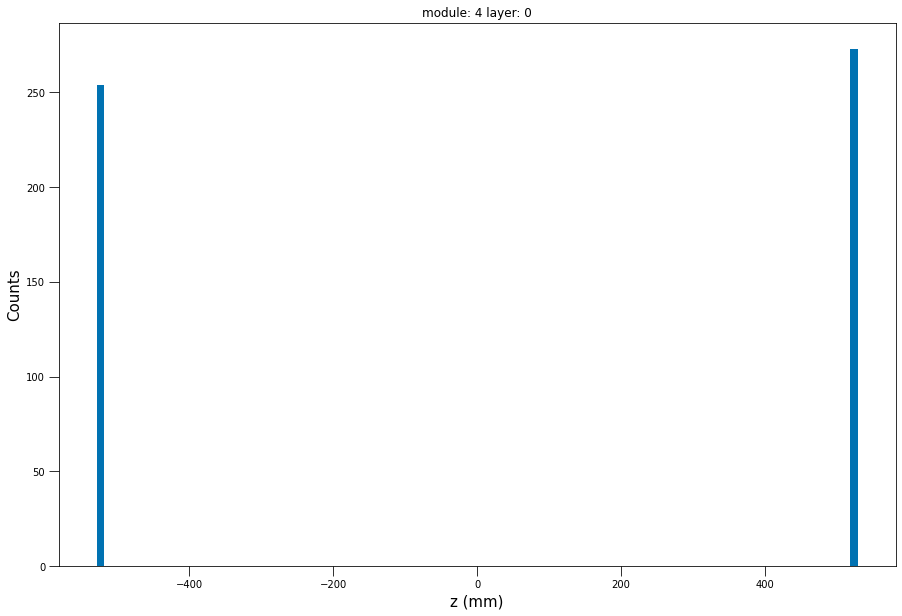

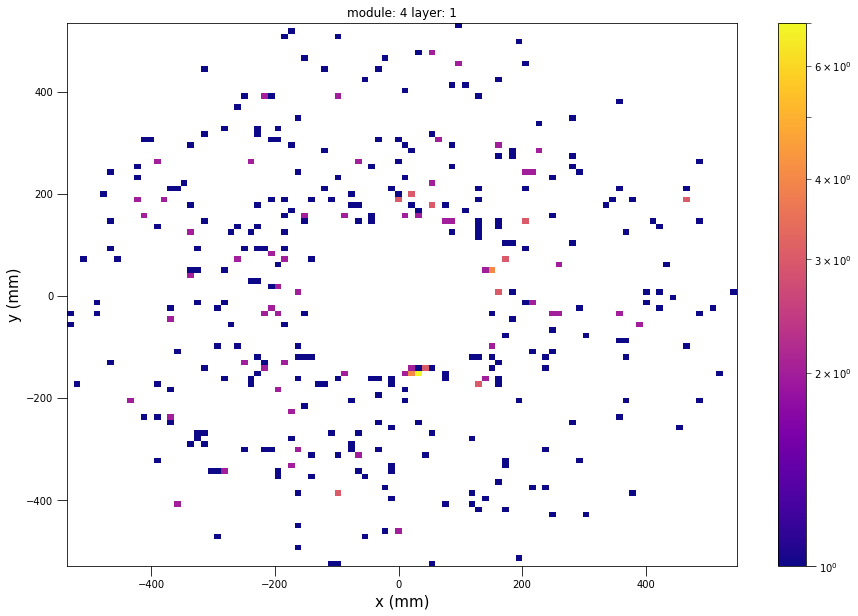

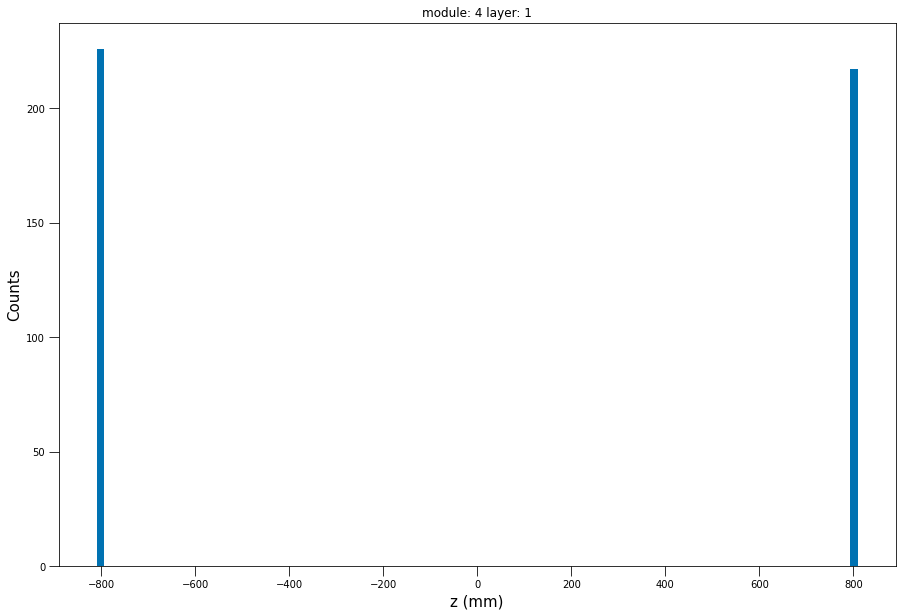

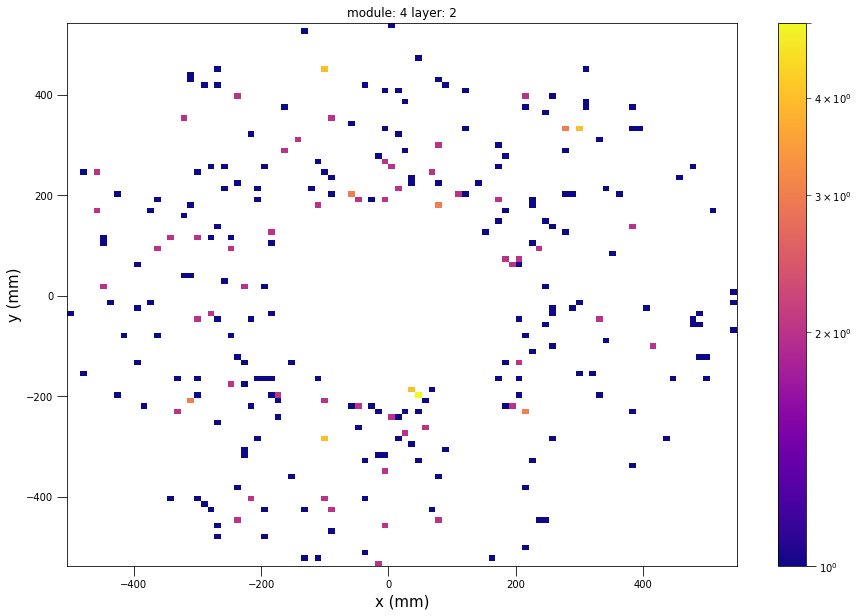

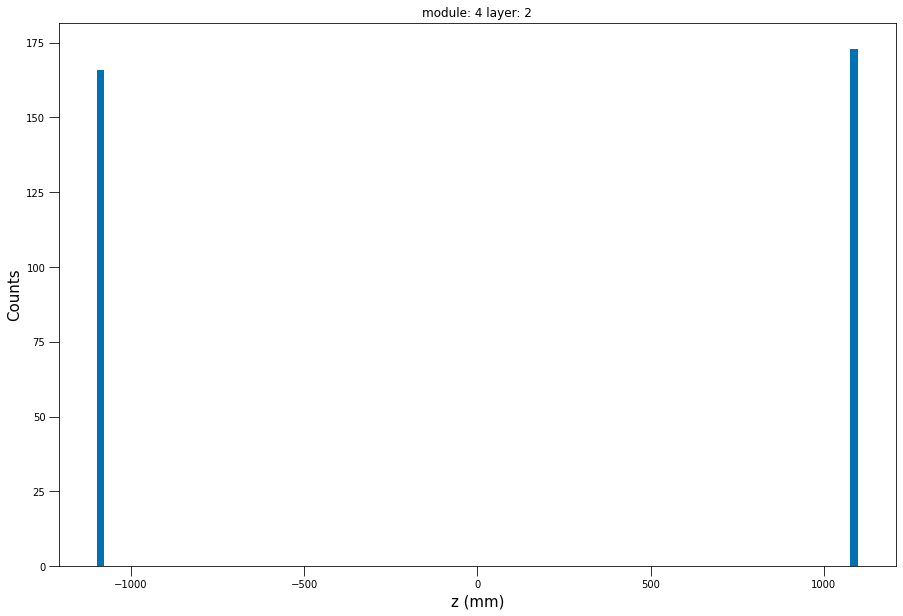

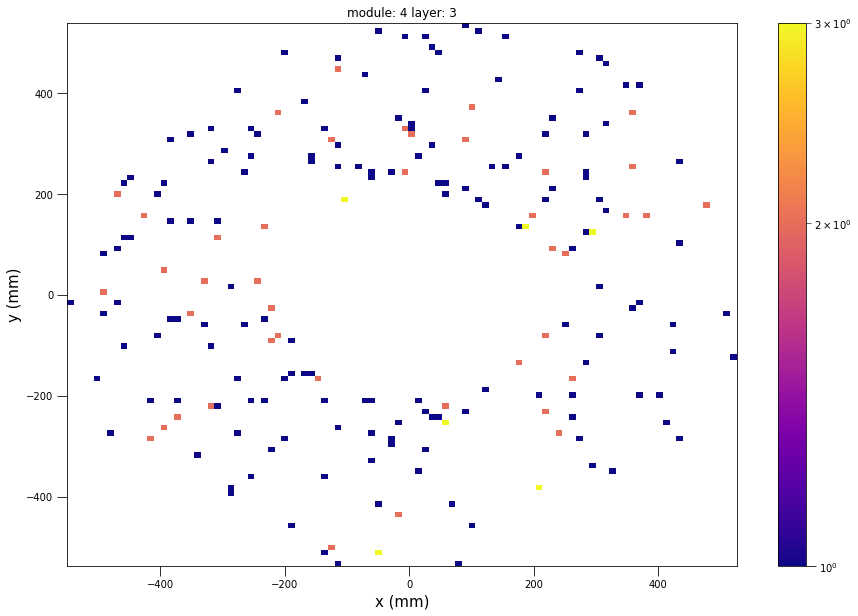

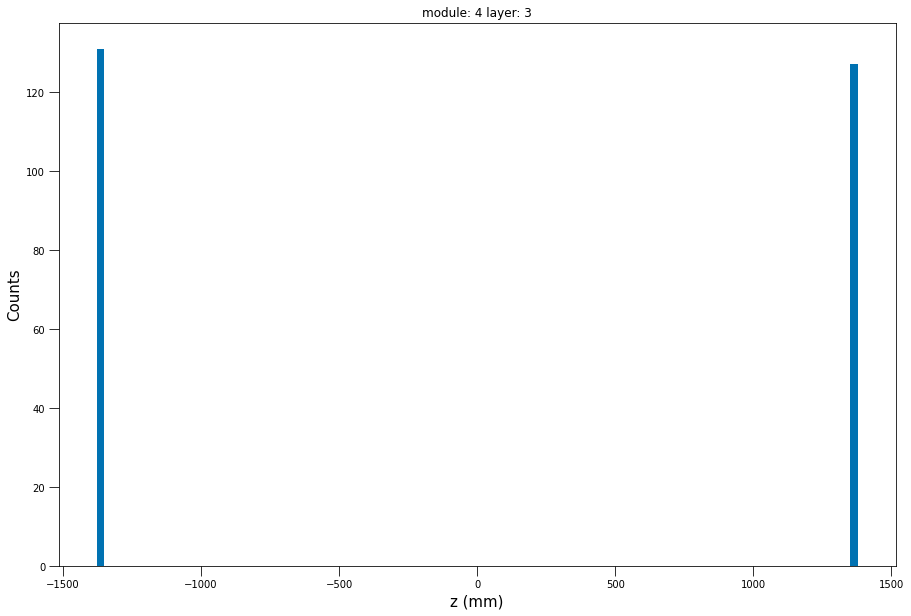

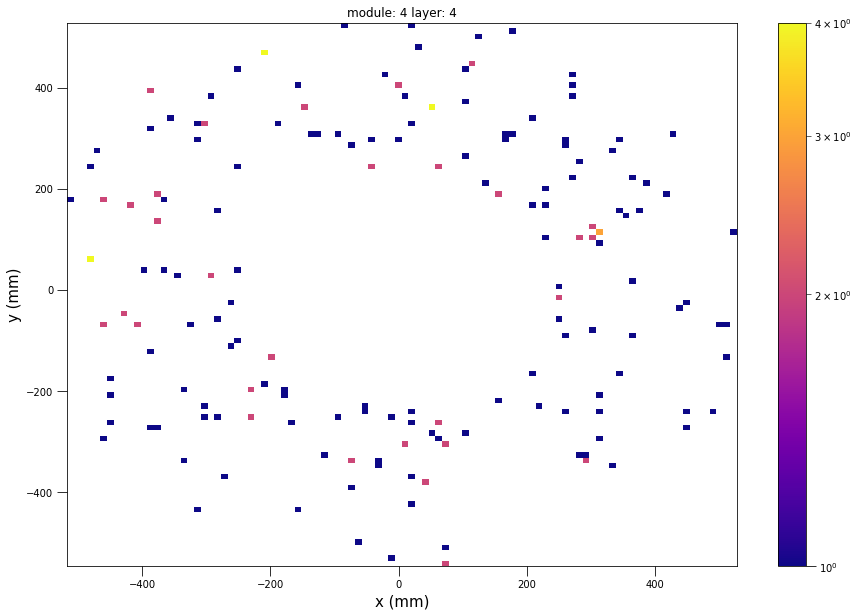

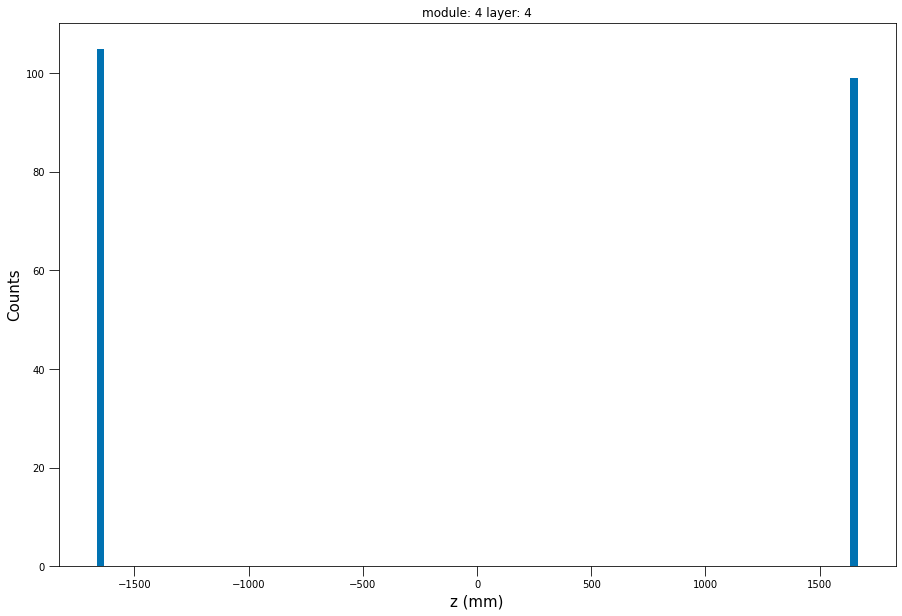

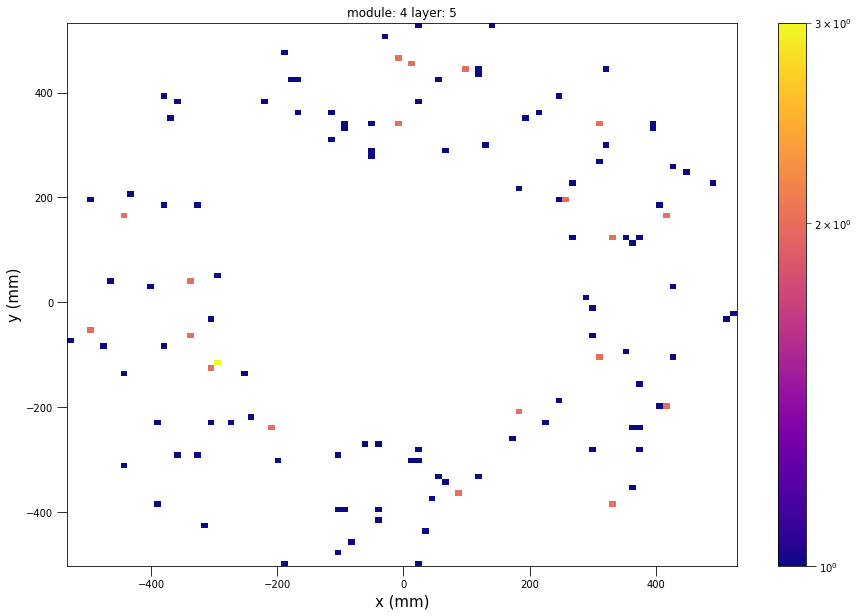

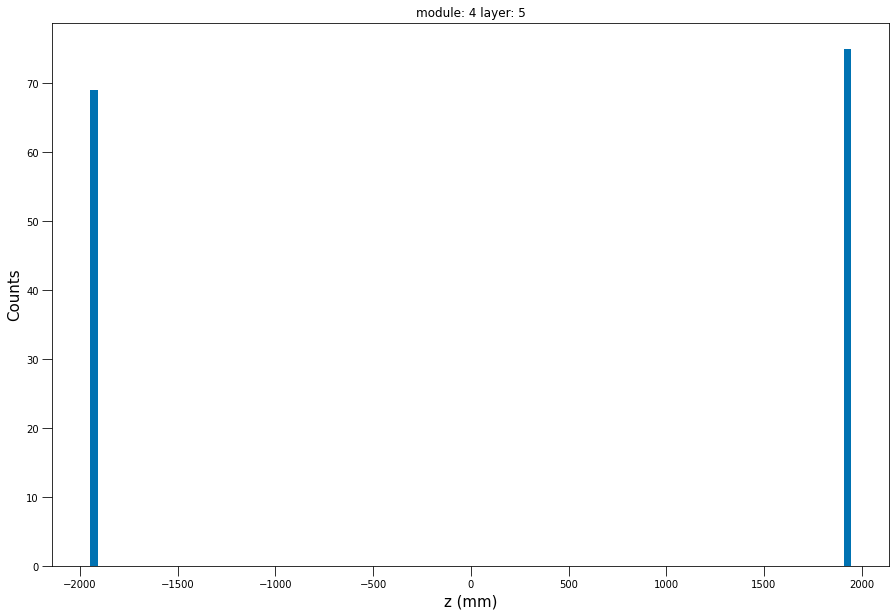

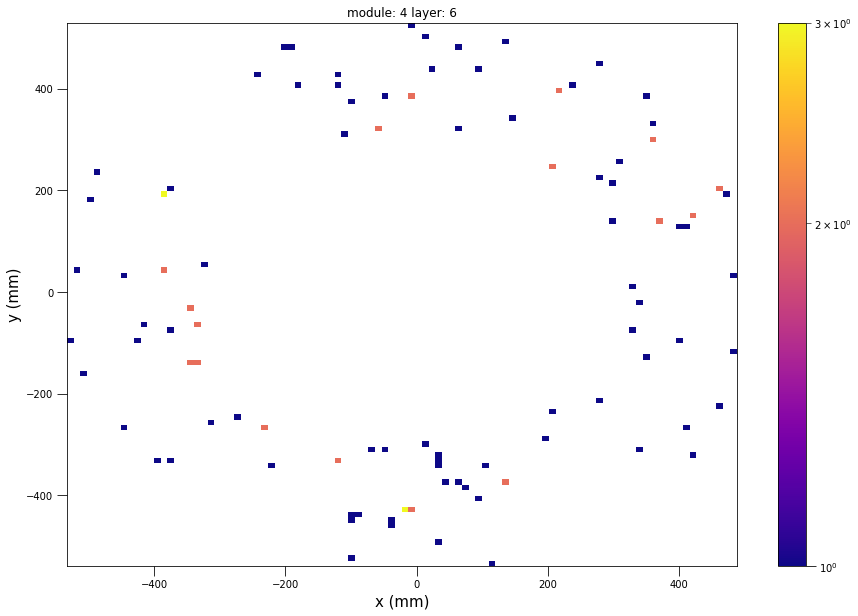

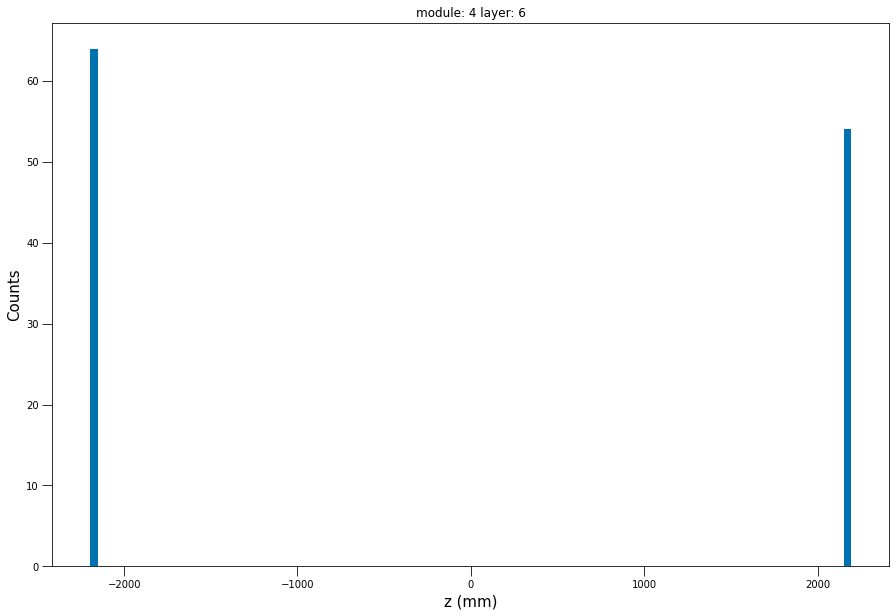

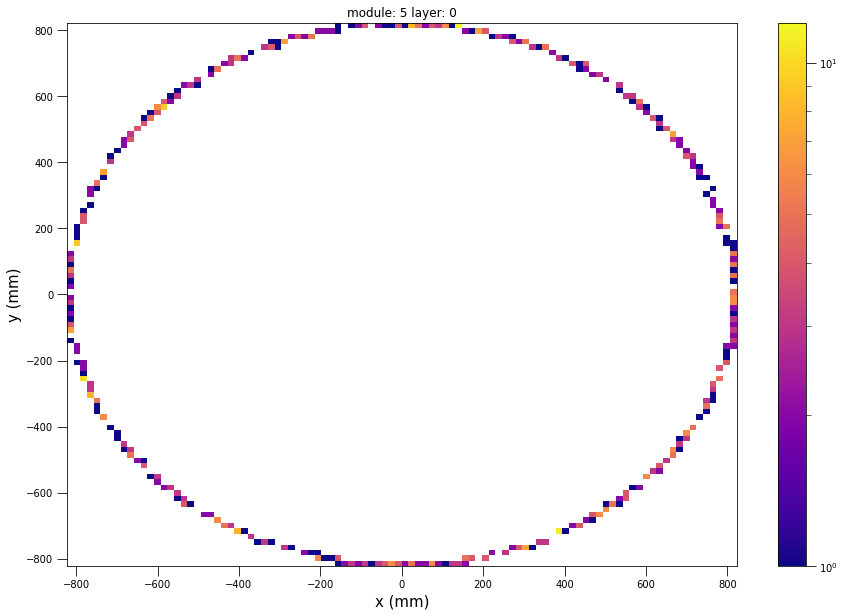

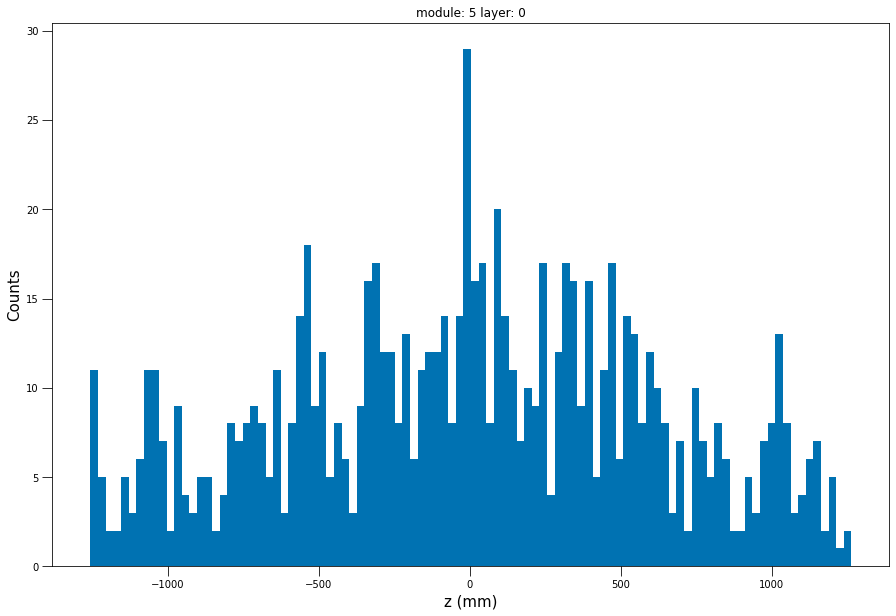

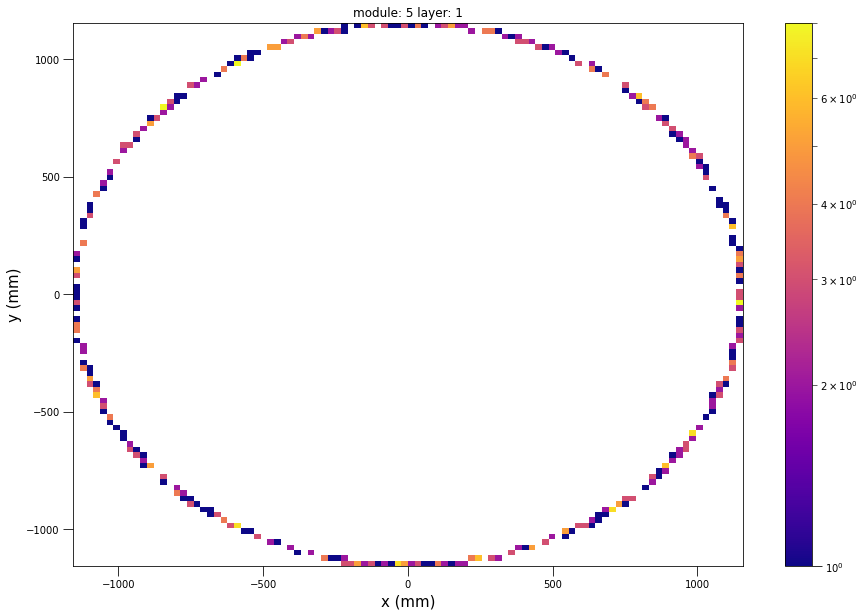

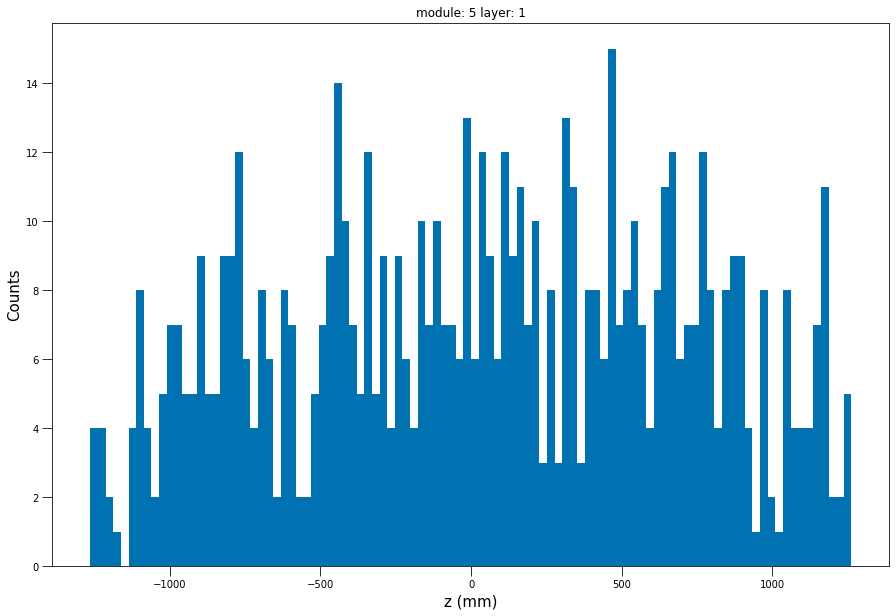

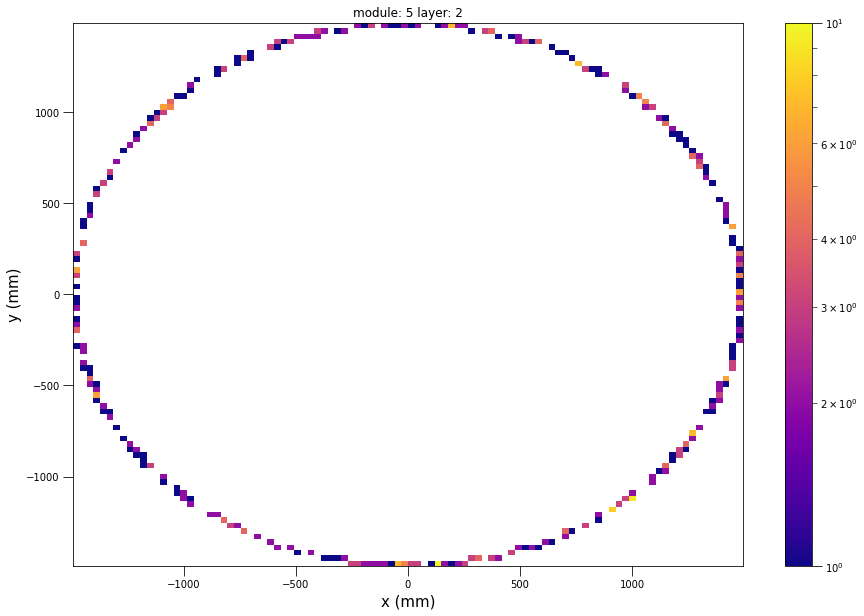

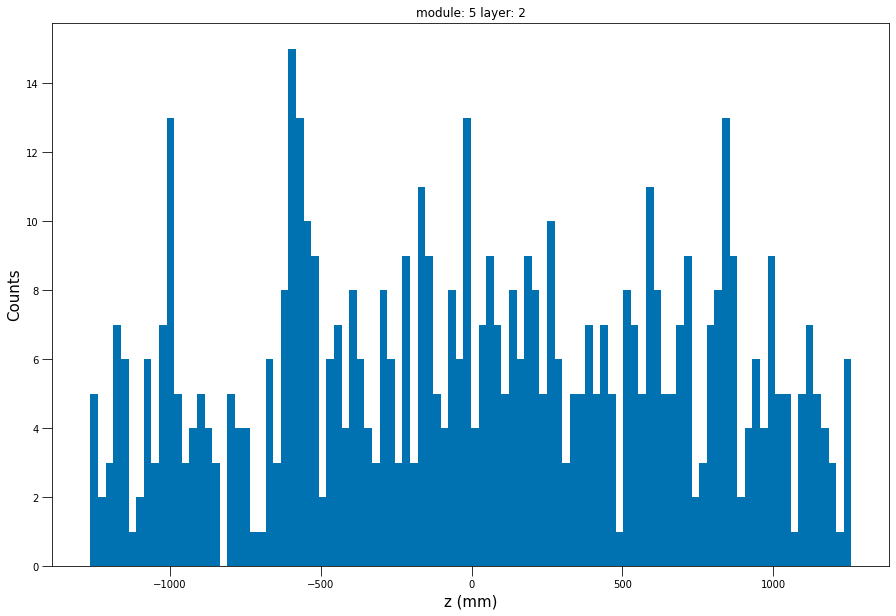

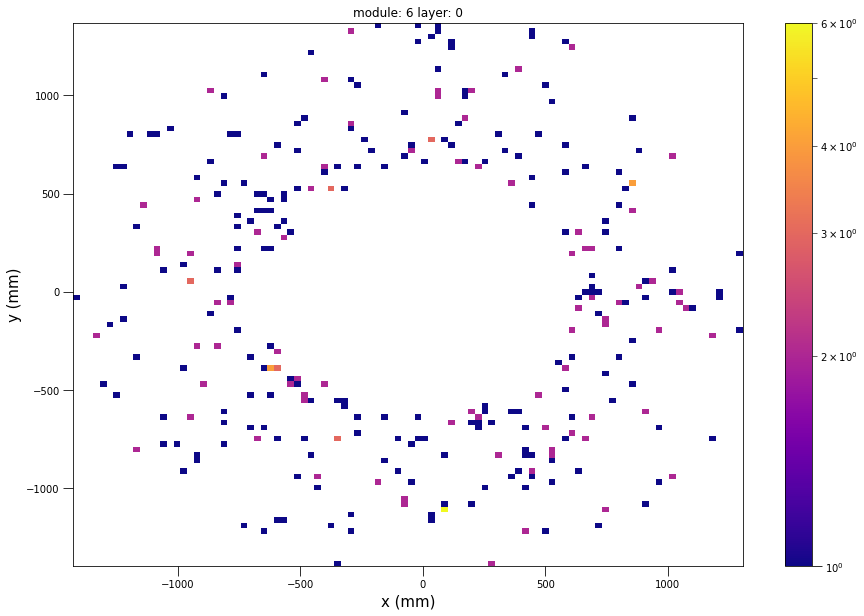

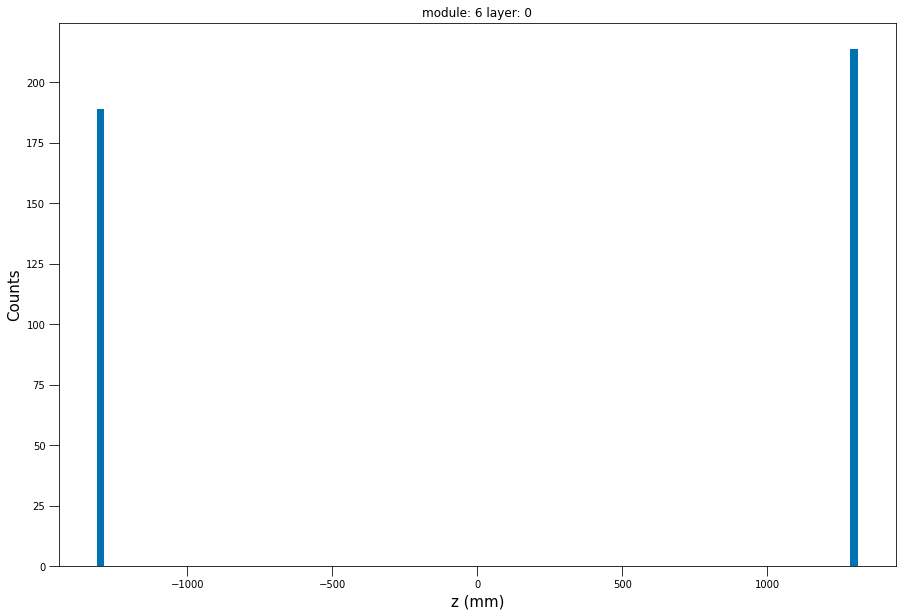

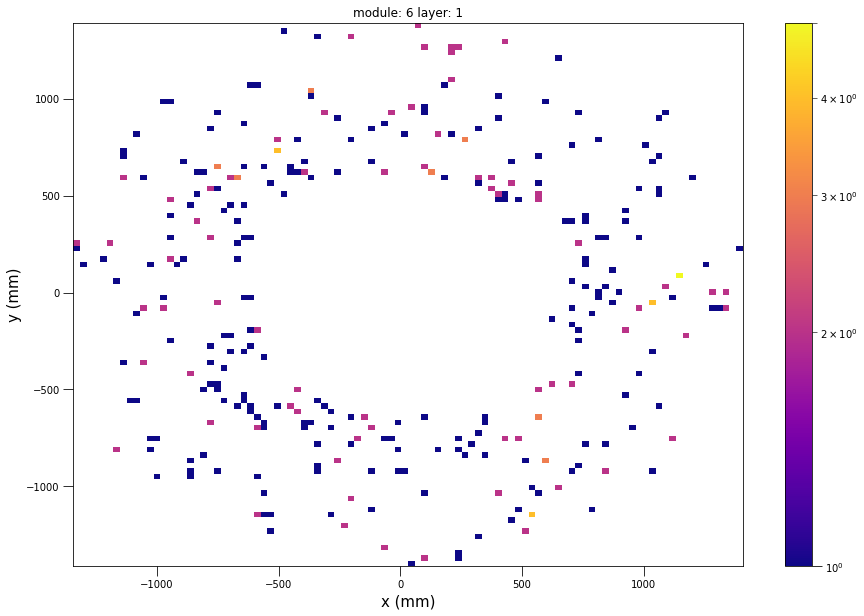

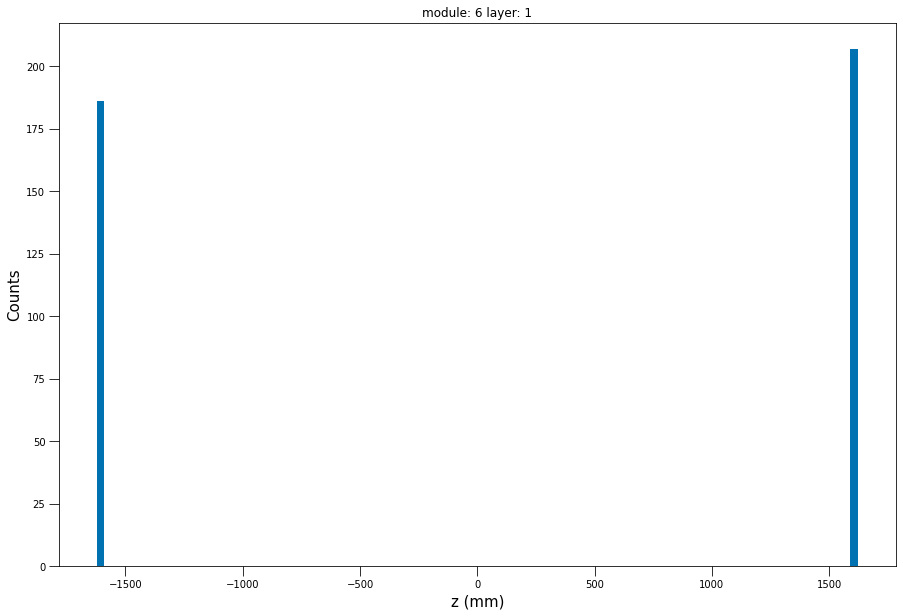

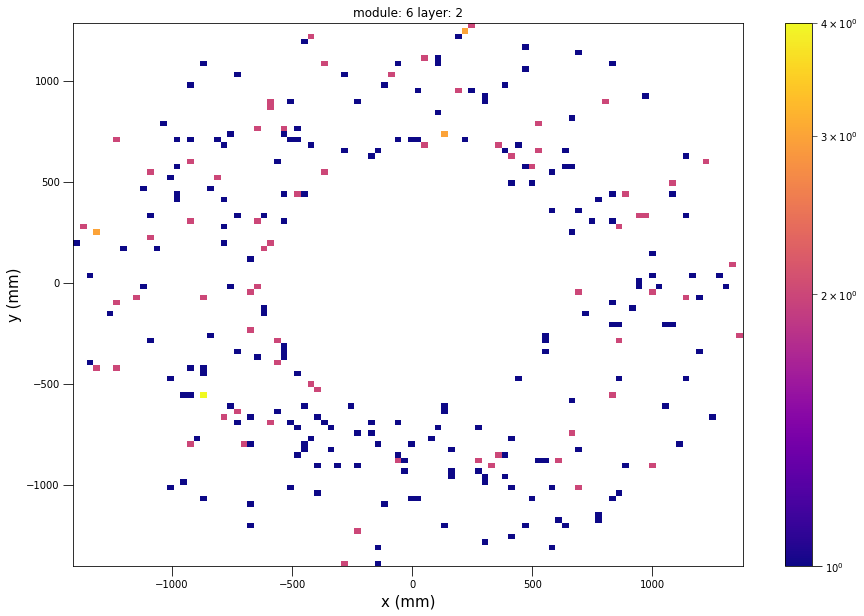

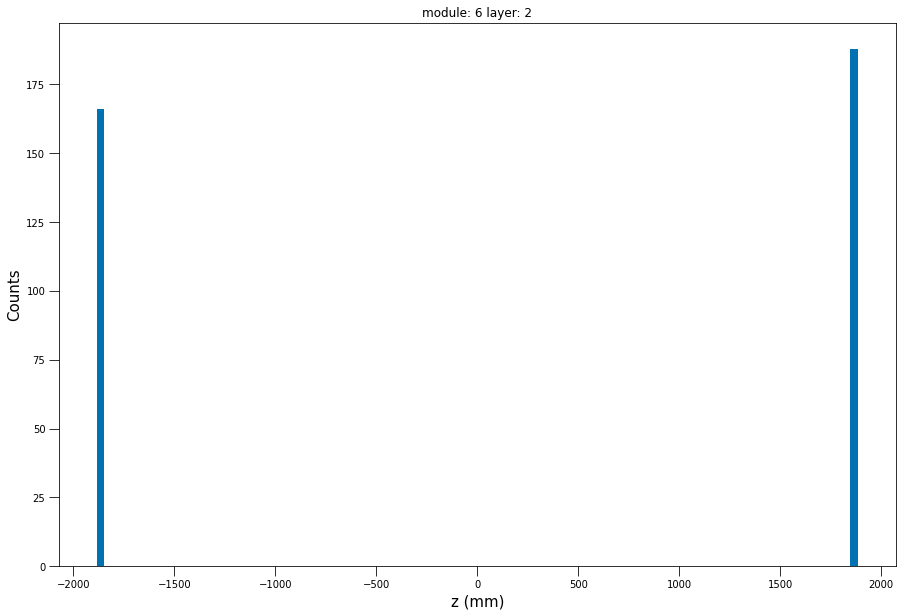

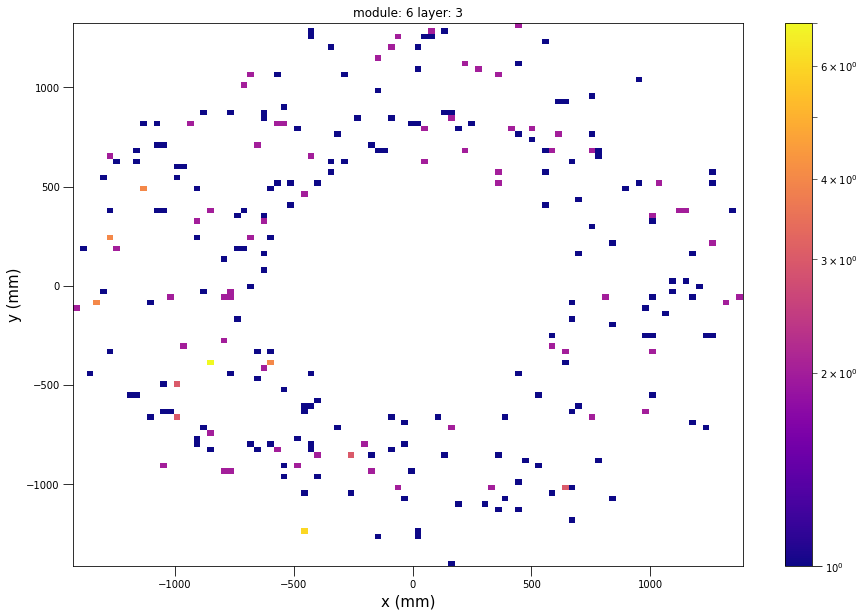

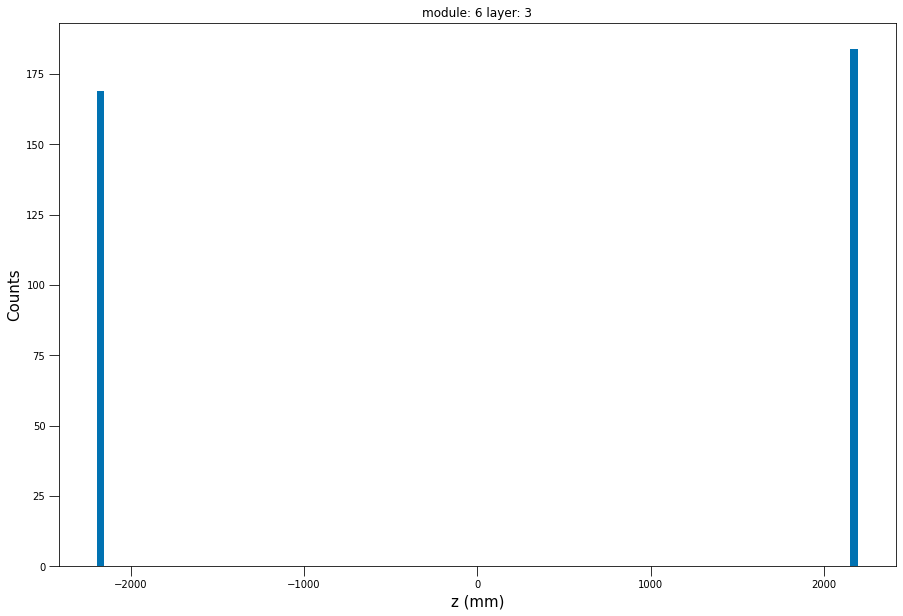

In [15]:
#Complete list of every module and layer.
#This is mostly to fix any confusion/for those who haven't looked at the geometry of the detector
for i in range(6):
    inMod=(tree["module"].array()==i+1)
    for j in range(layerPerModule[i+1]):
        inLayer=(tree["layer"].array()==j)
        inside=inLayer & inMod
        plot2DHistogram(tree["x"].array()[inside], tree["y"].array()[inside], label=("module: " +str(i+1) + " layer: " + str(j) +";x (mm);y (mm)"))
        plot1DHistogram(tree["z"].array()[inside], bins=100, label=("module: " +str(i+1) + " layer: " + str(j) +";z (mm);Counts"))

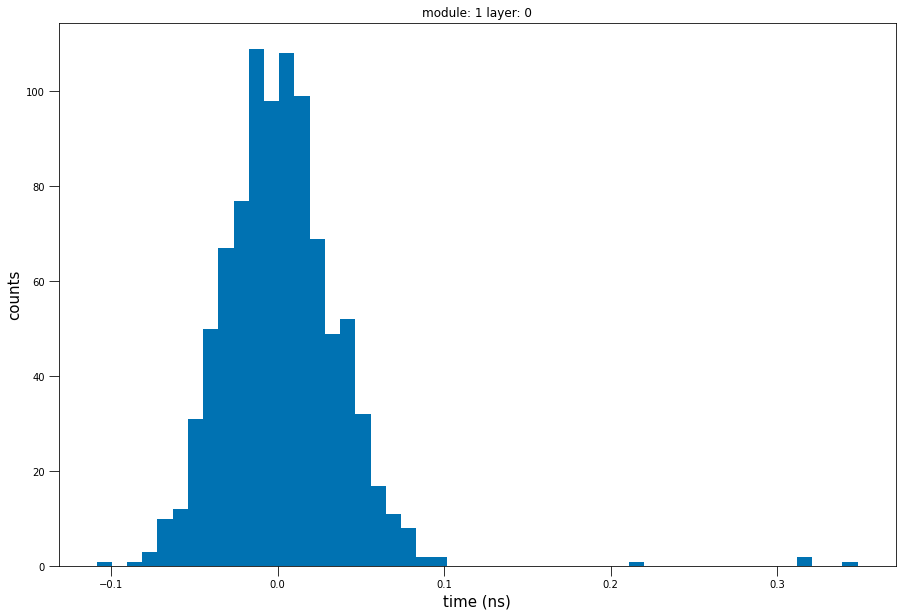

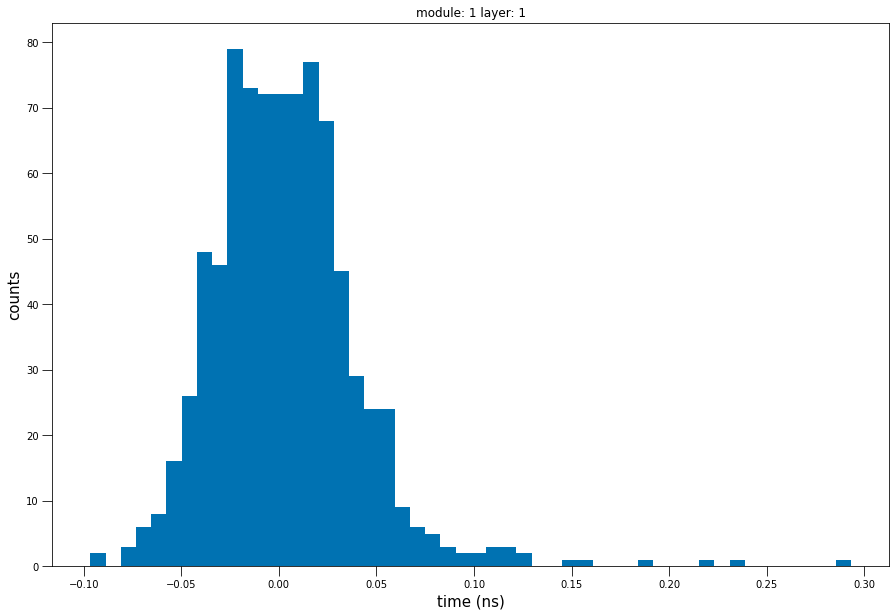

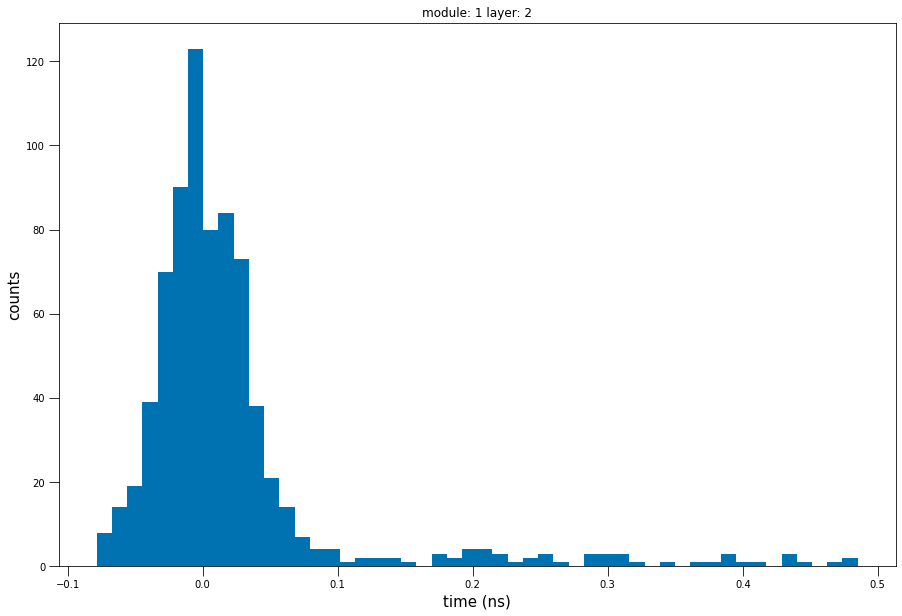

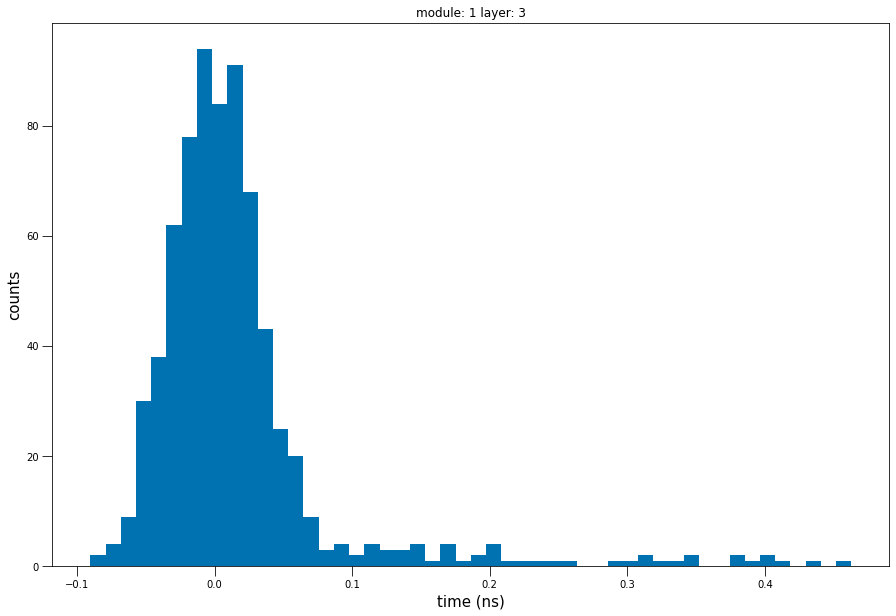

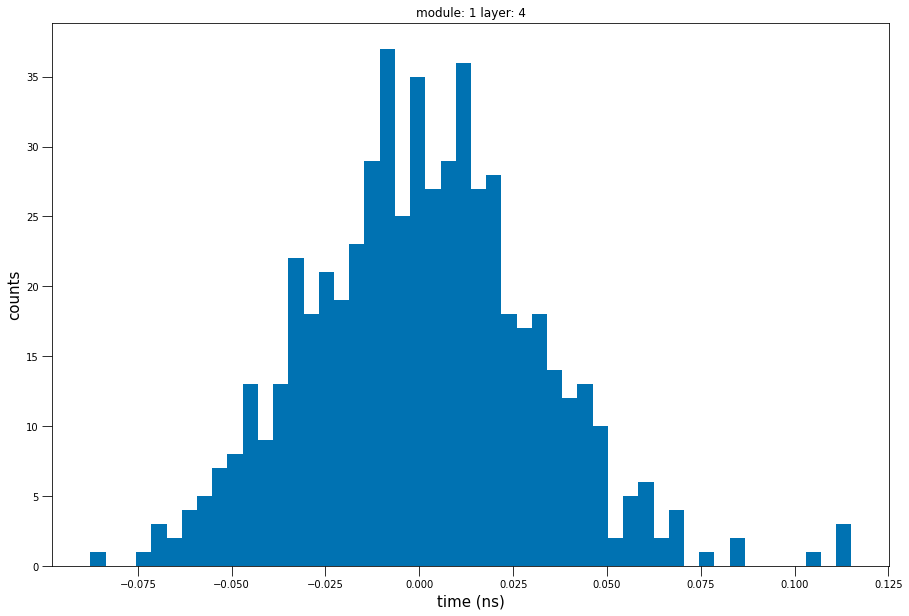

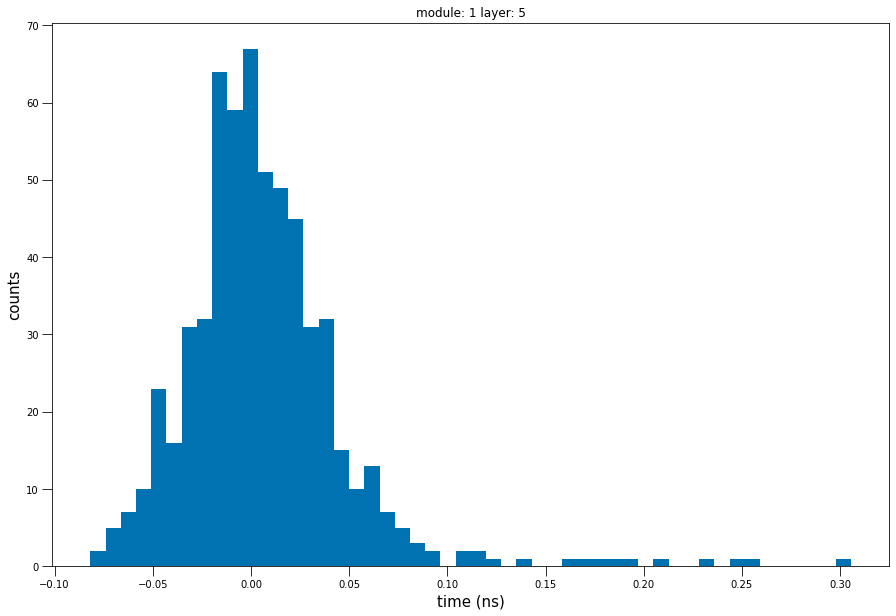

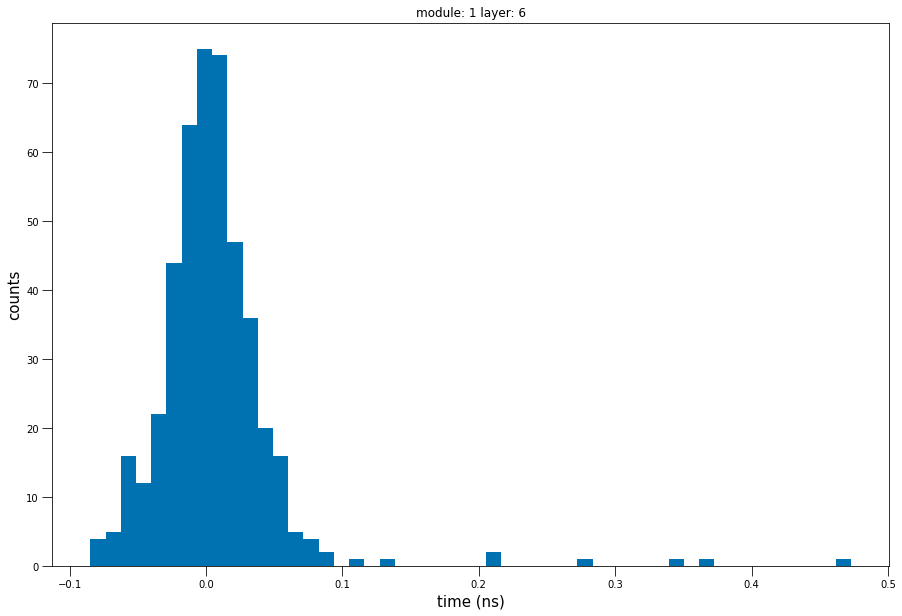

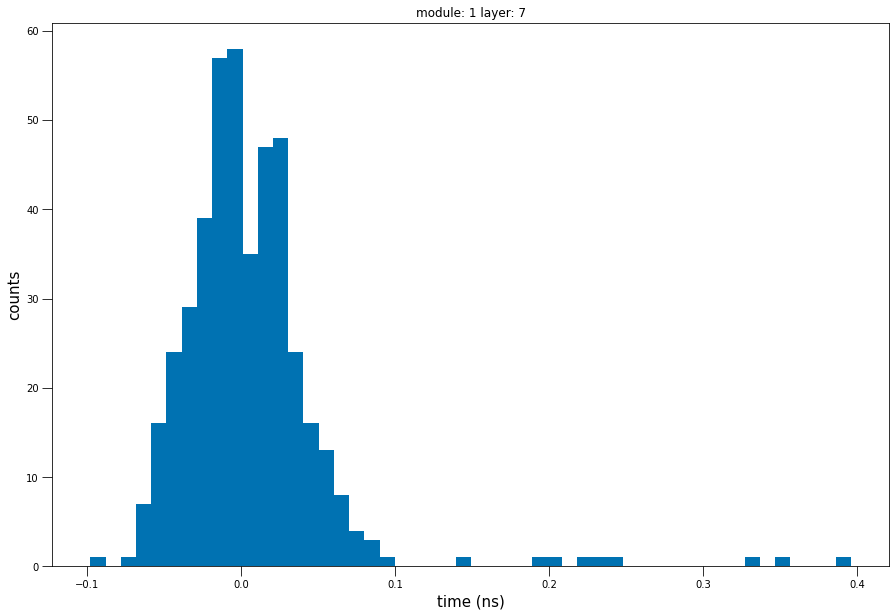

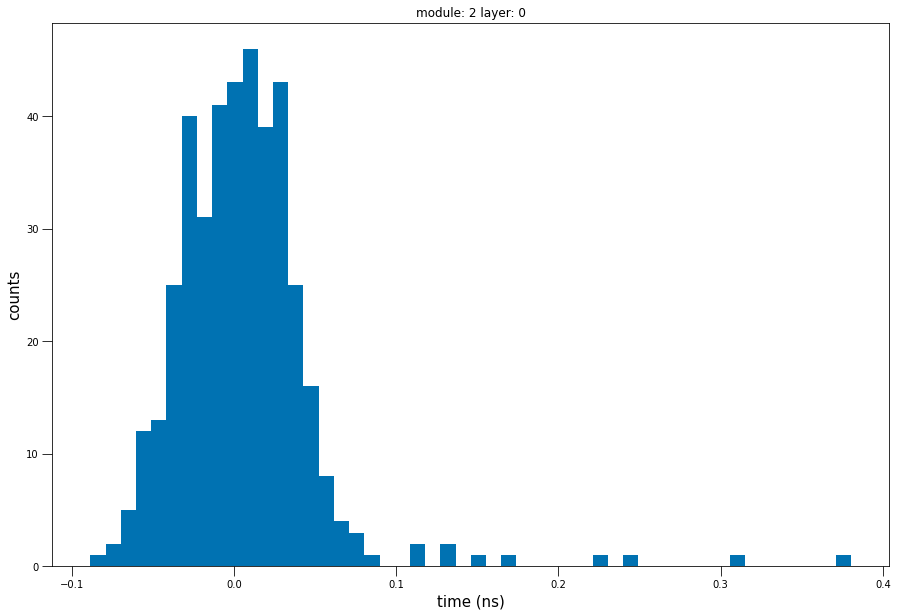

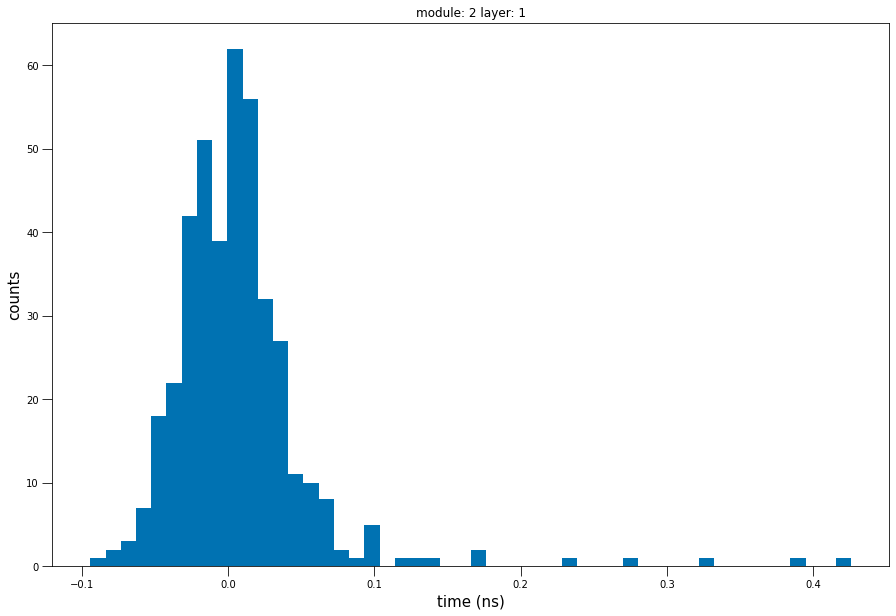

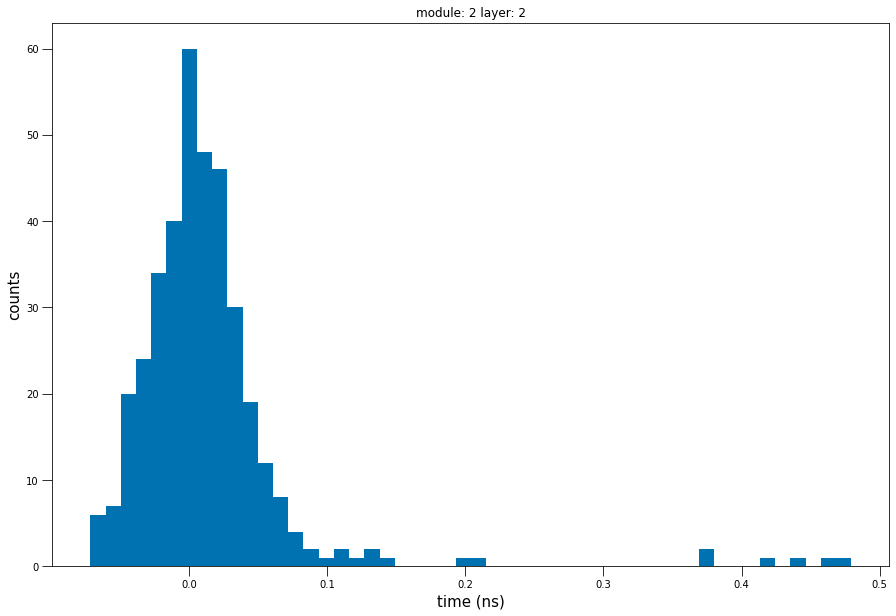

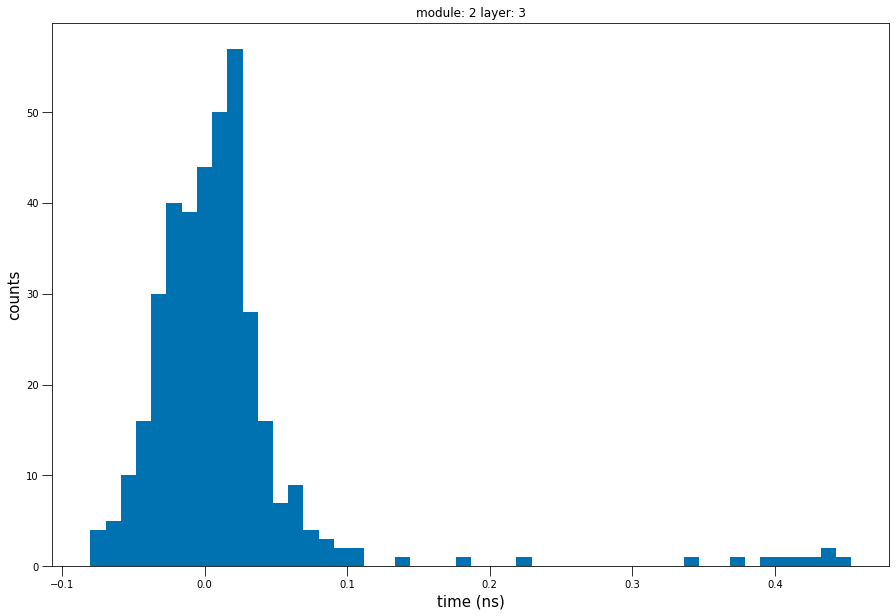

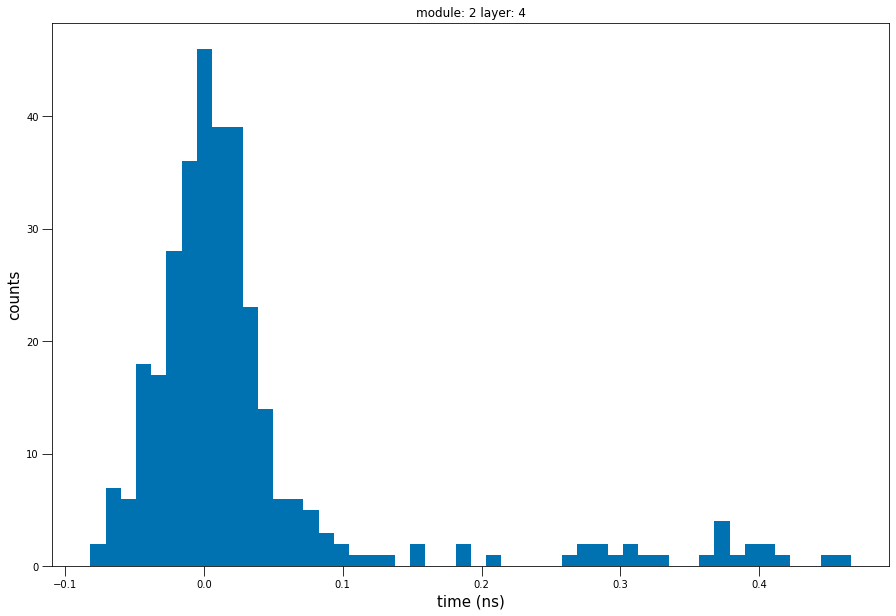

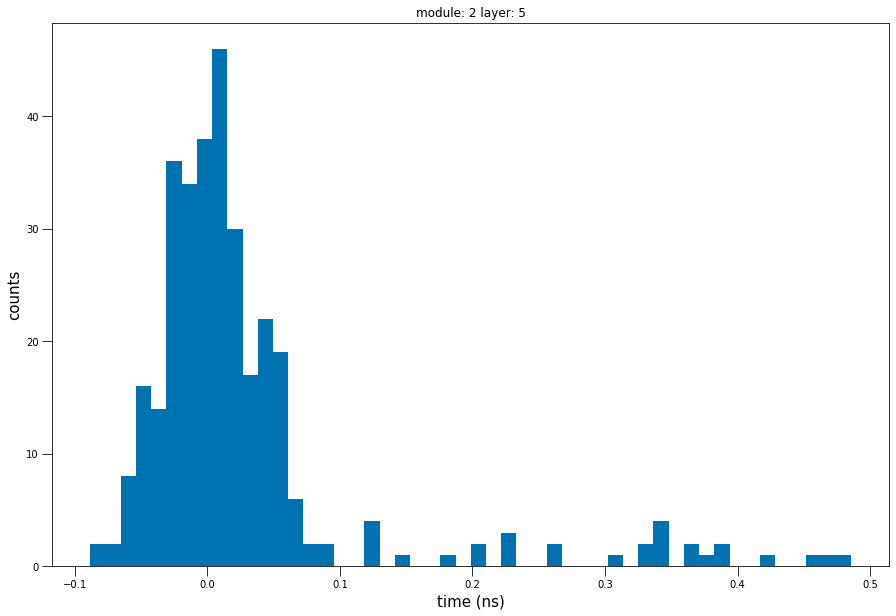

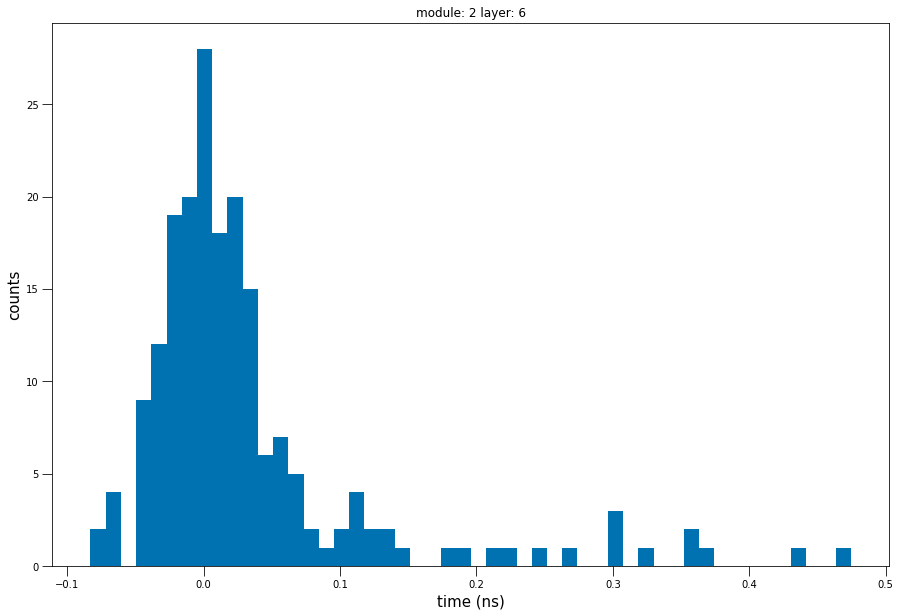

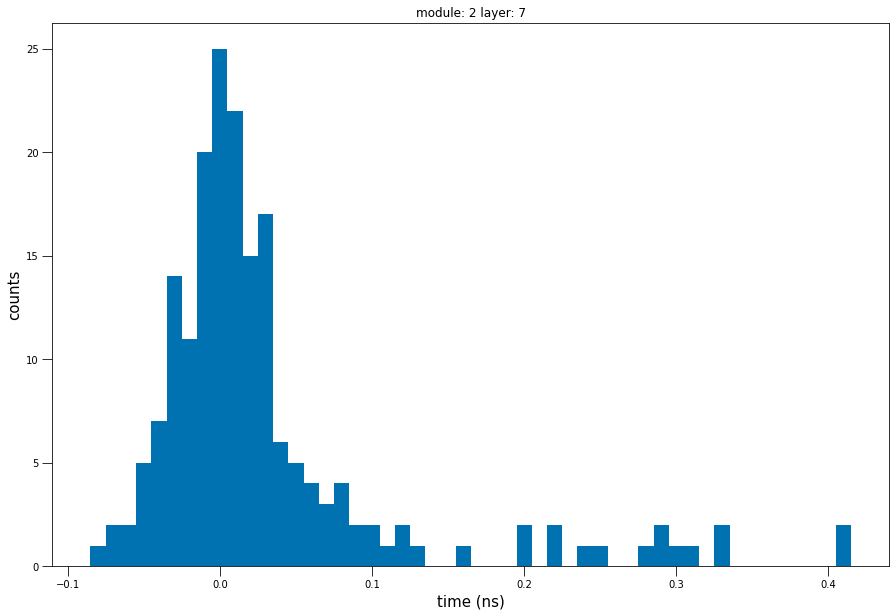

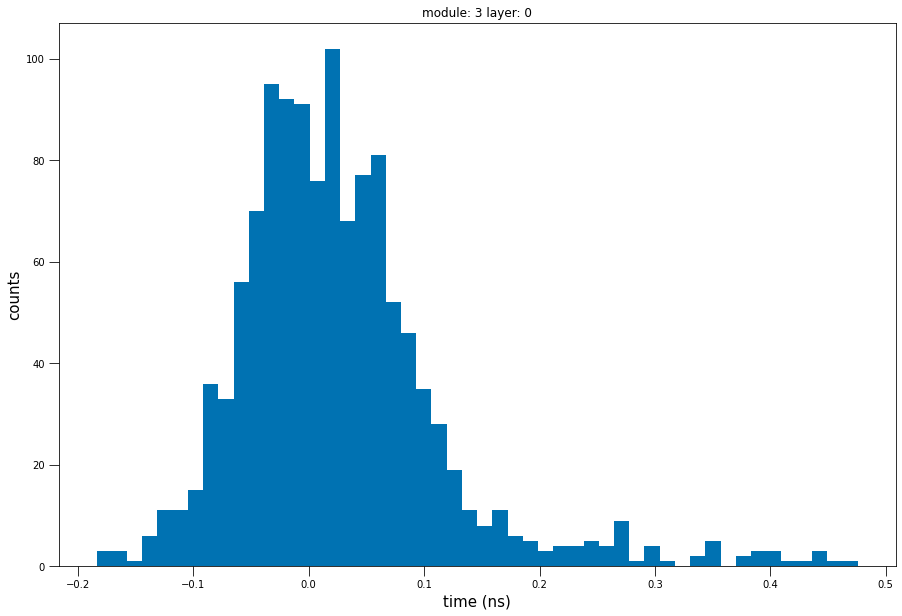

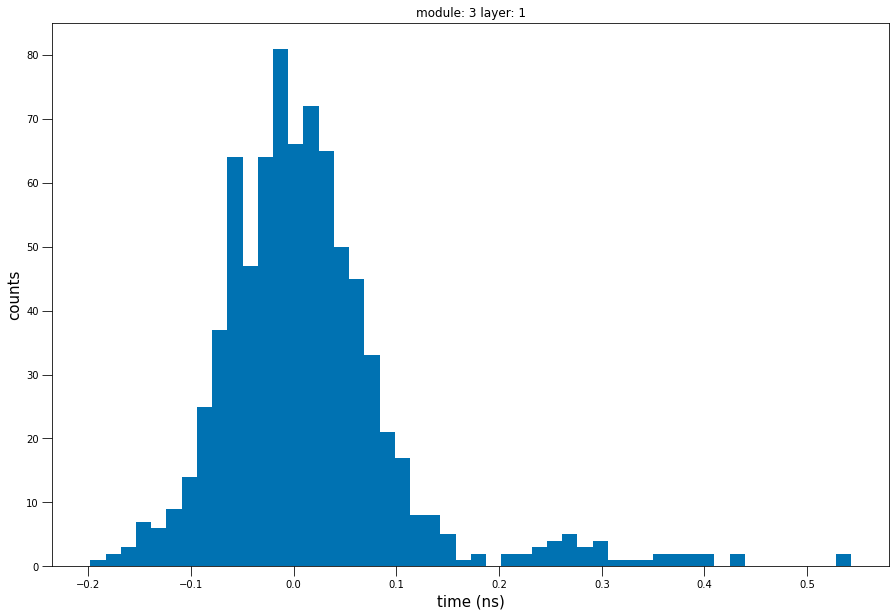

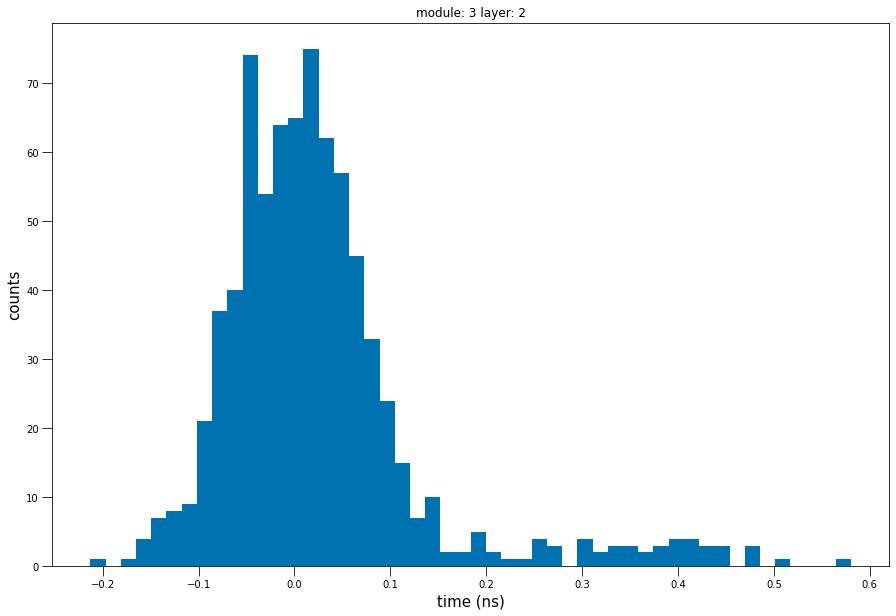

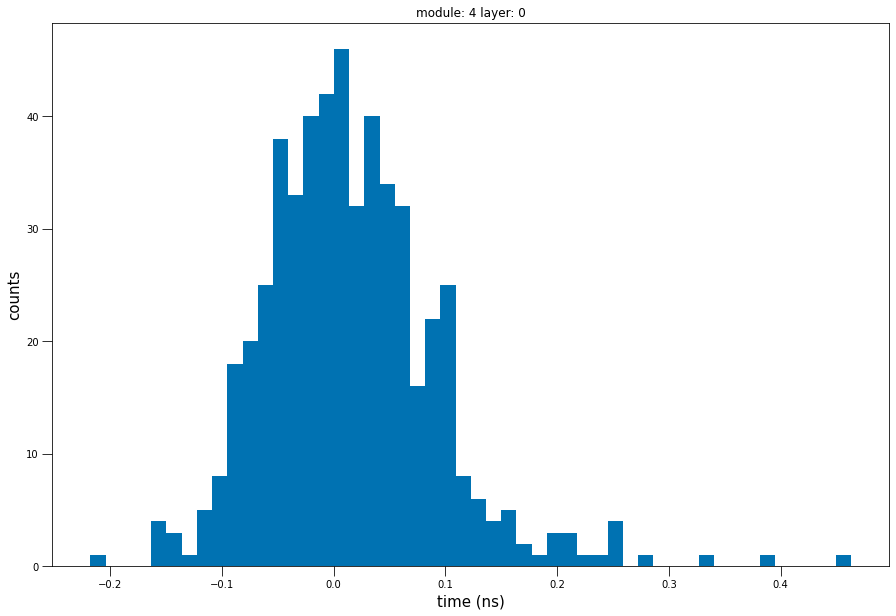

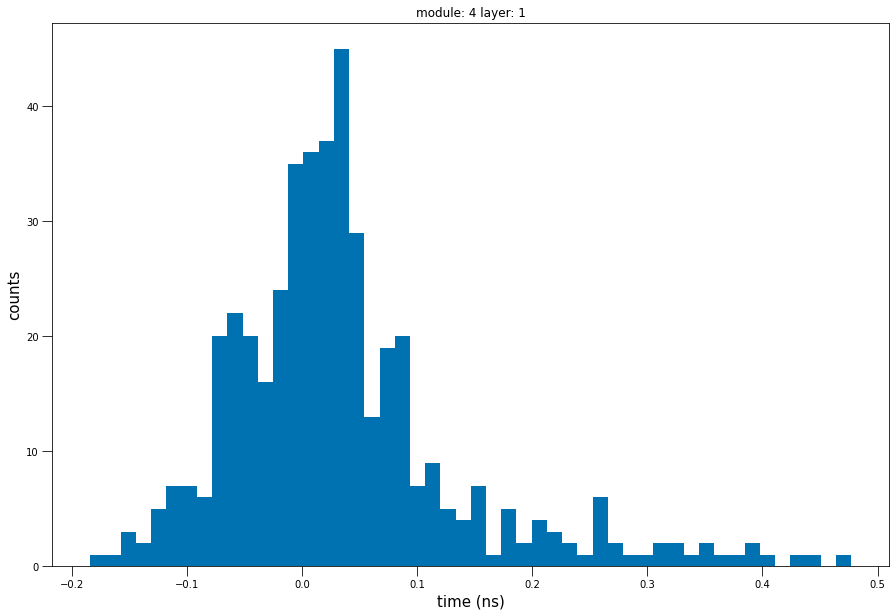

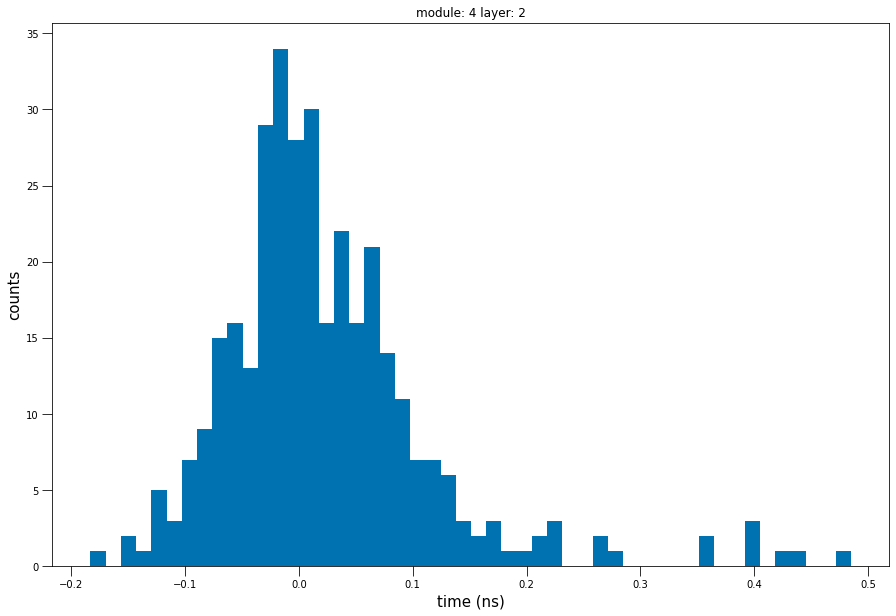

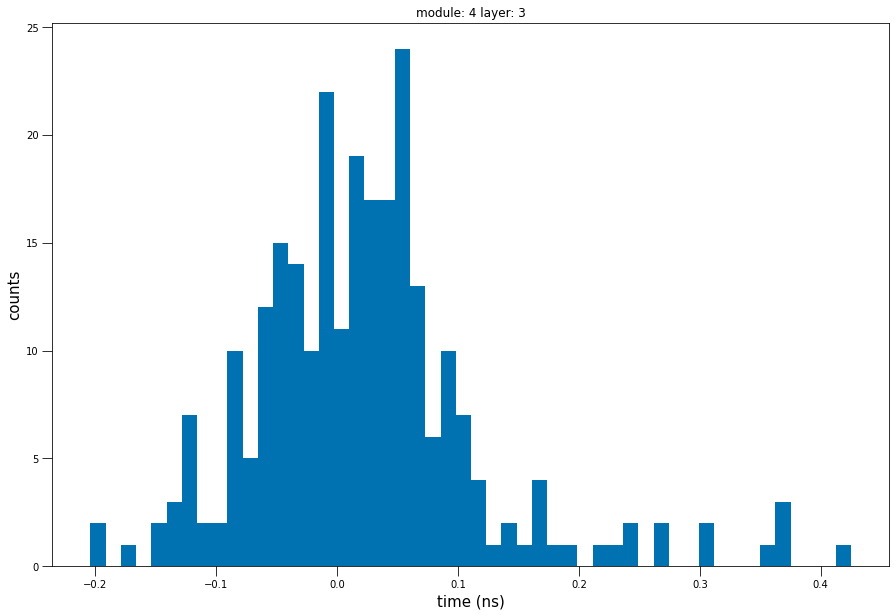

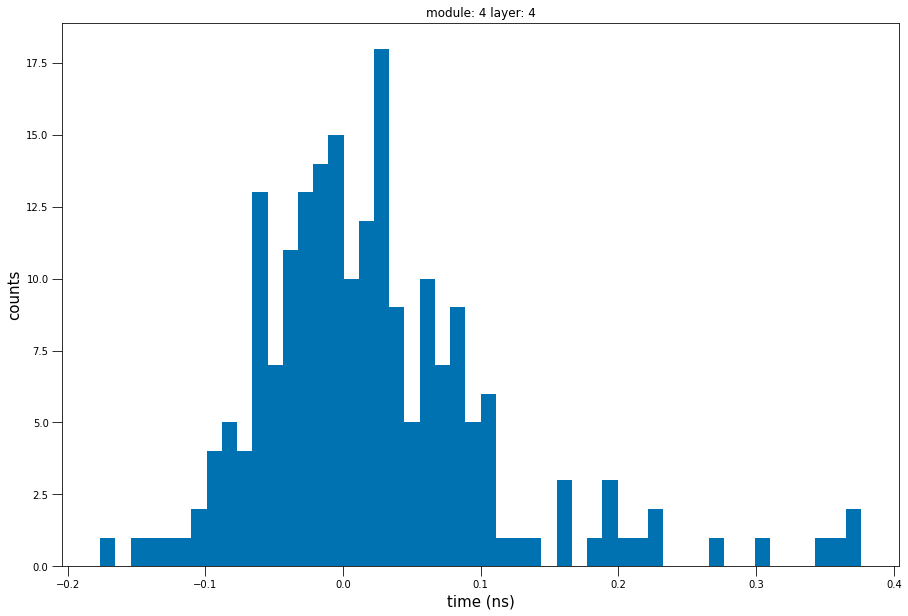

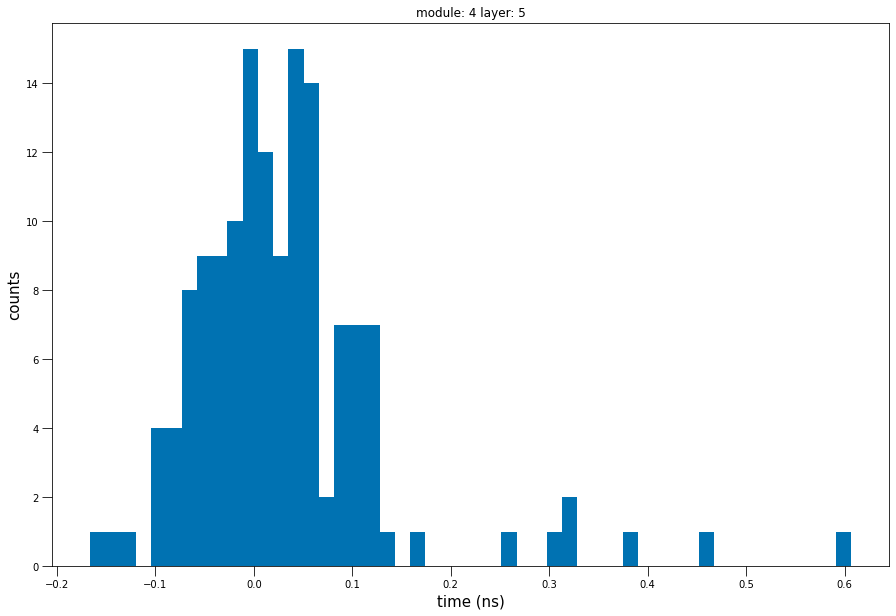

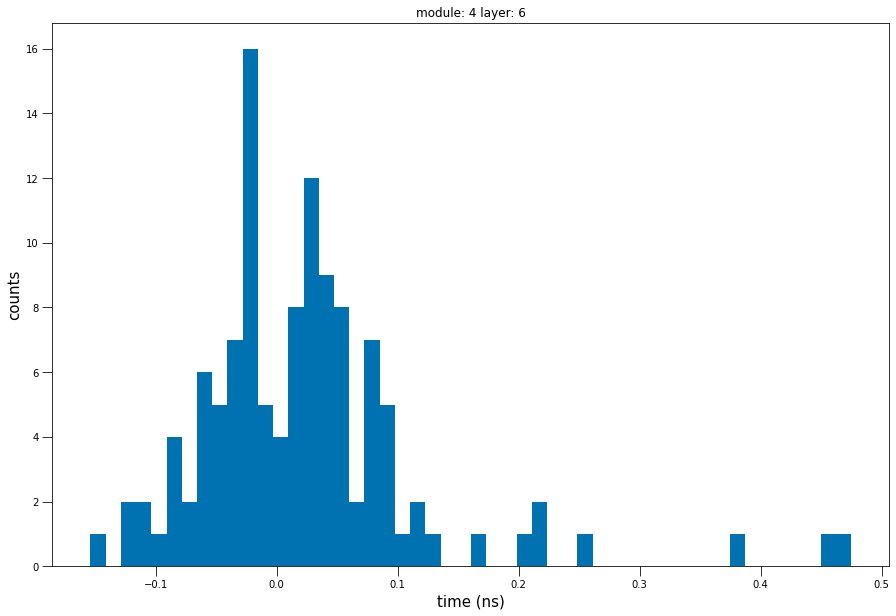

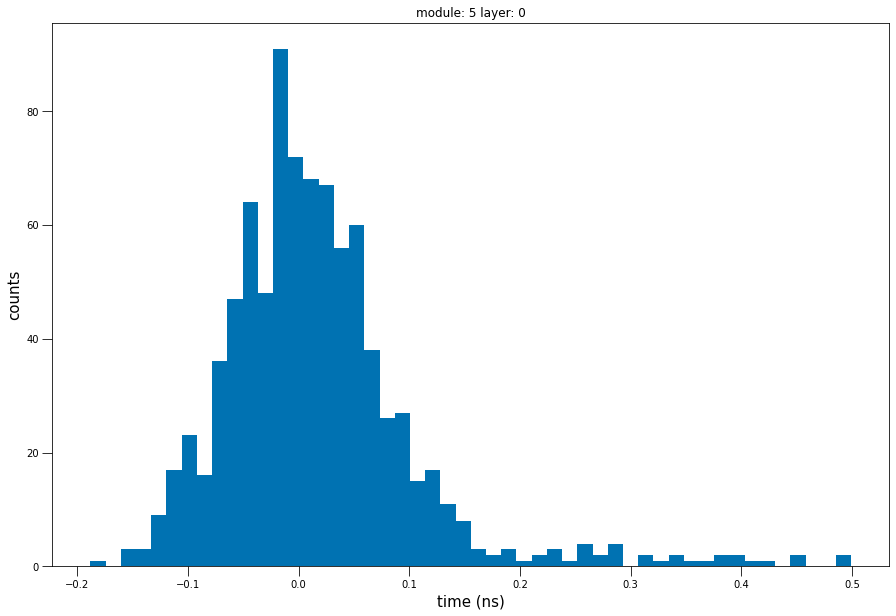

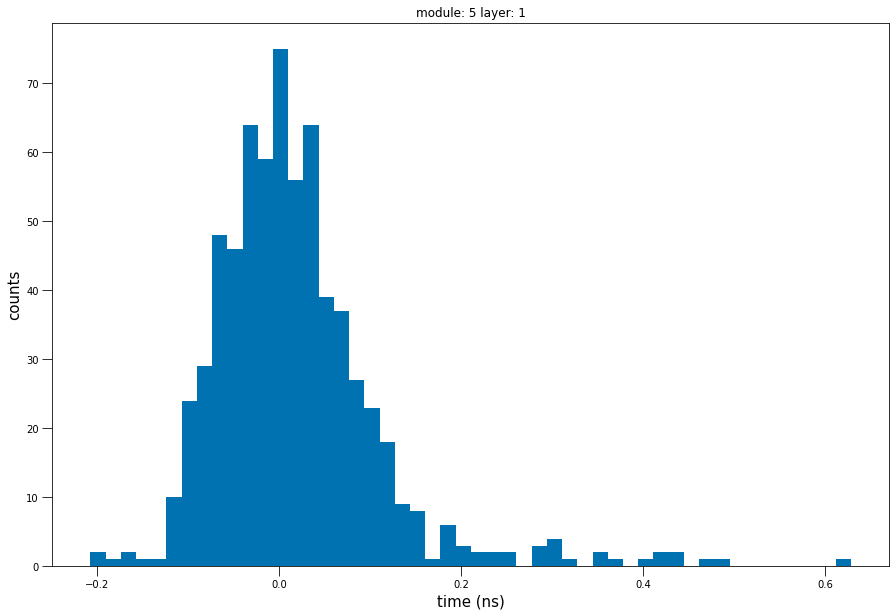

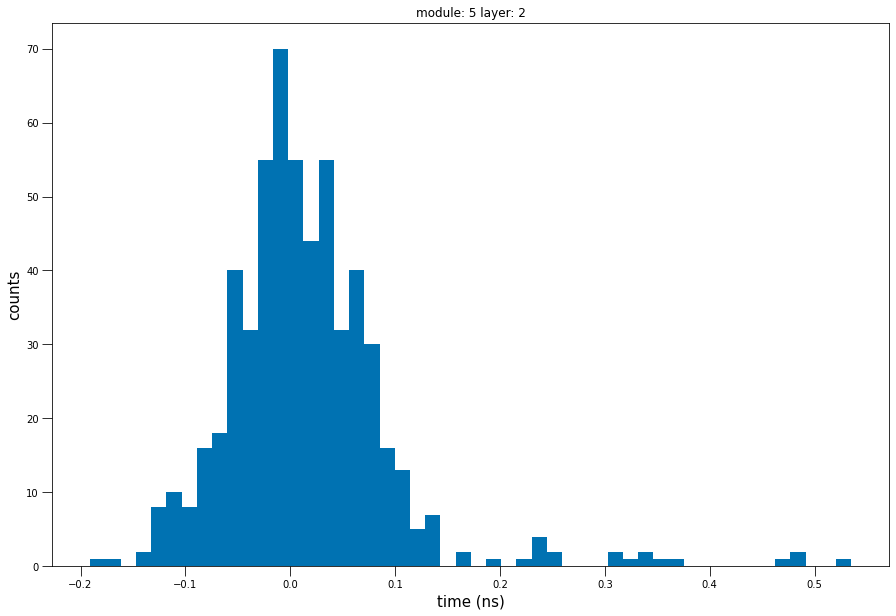

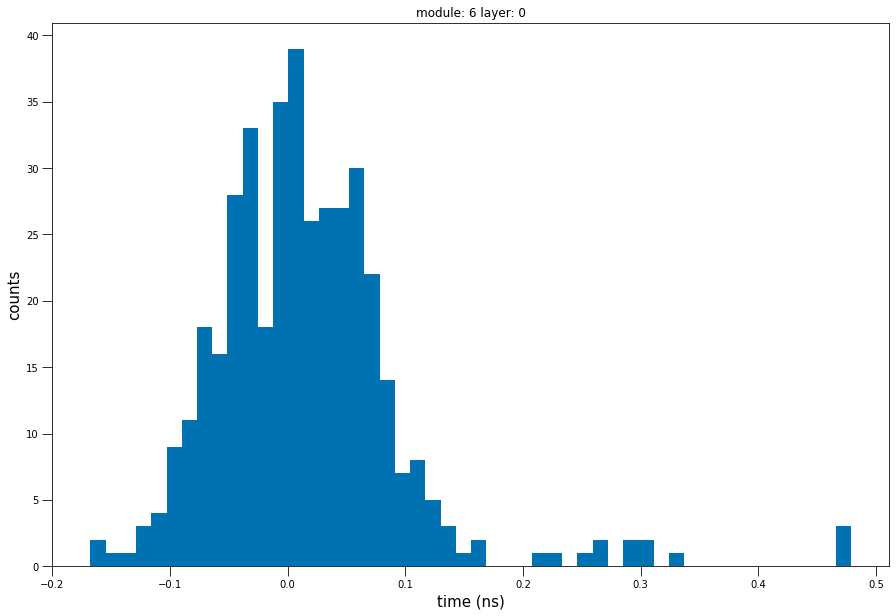

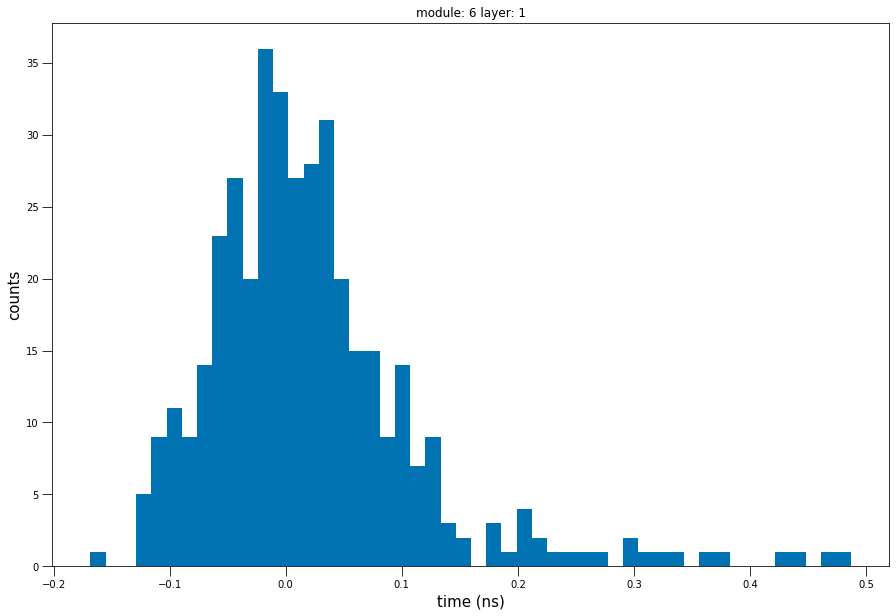

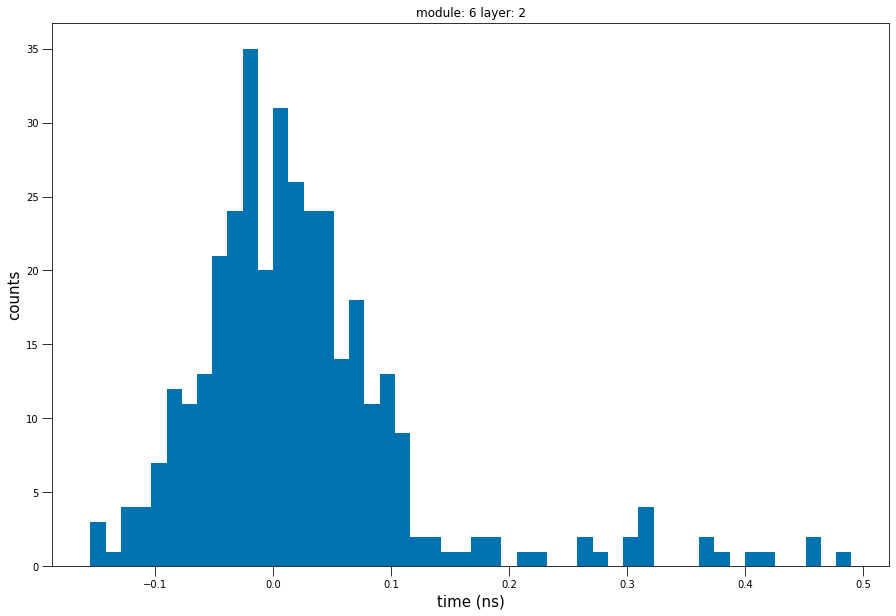

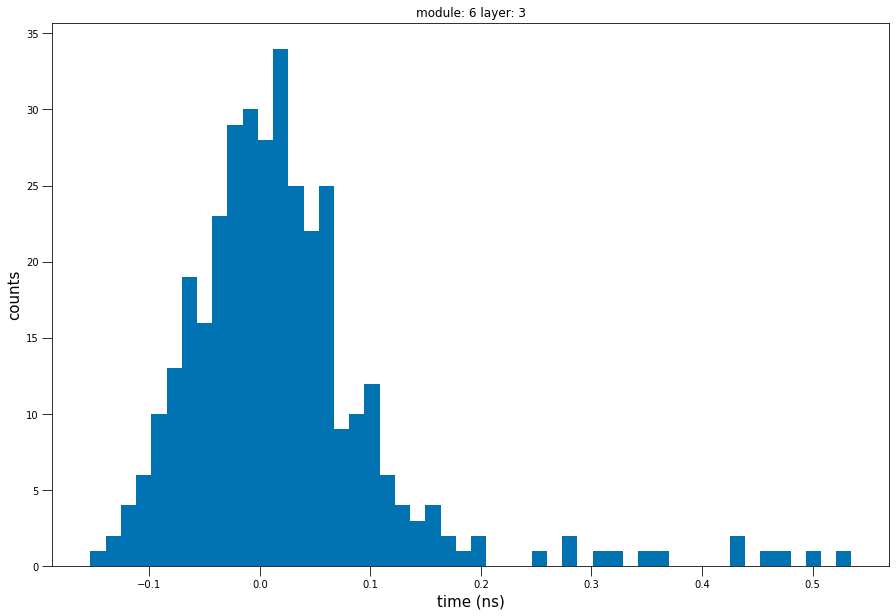

In [16]:
#Finding time distributions for every module-layer pair for truth muons
c=299792458*1000*10**(-9) #speed of light in m/s times correction to mm/s times correction to mm/ns
for i in range(6):
    inMod=(tree["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(tree["layer"].array()==j)
        inside=inLayer & inMod
        time=tree["t"].array()[inside]-np.sqrt(tree["x"].array()[inside]**2+tree["y"].array()[inside]**2+tree["z"].array()[inside]**2)/c
        if i <=1:
            time=time+norm.rvs(size=np.sum(inside), scale=0.03) #adding 30 ps time resolution to vertex hits
        else:
            time=time+norm.rvs(size=np.sum(inside), scale=0.06) #adding 60 ps time resolution to inner detector and outer detector hits
        plot1DHistogram(time, bins=50, label=("module: " +str(i+1) + " layer: " + str(j) +";time (ns);counts"))

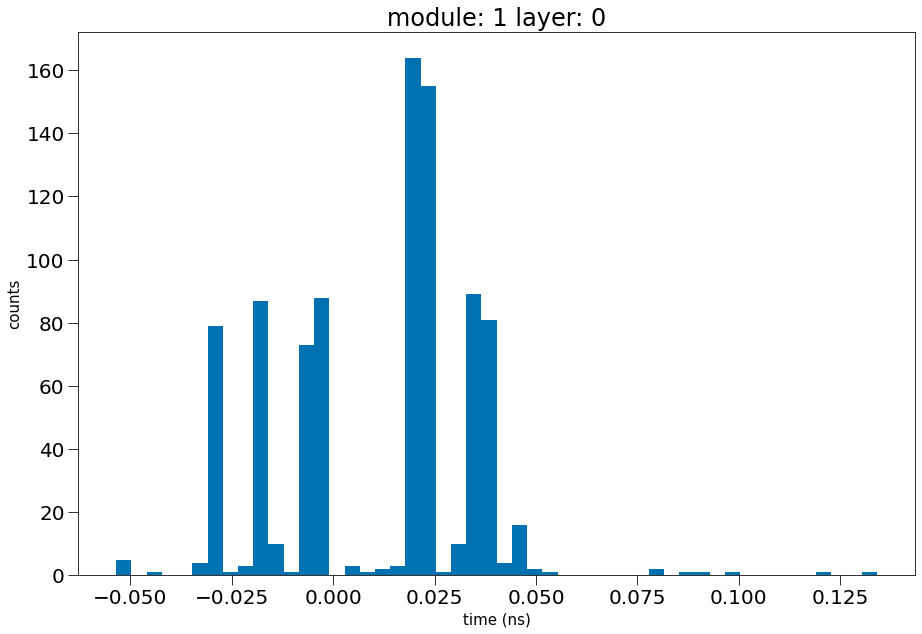

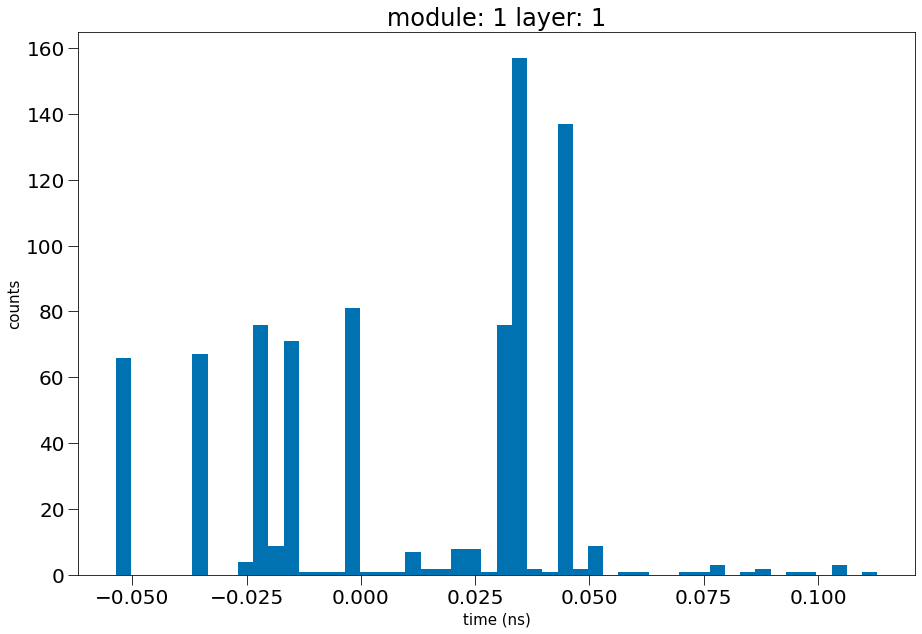

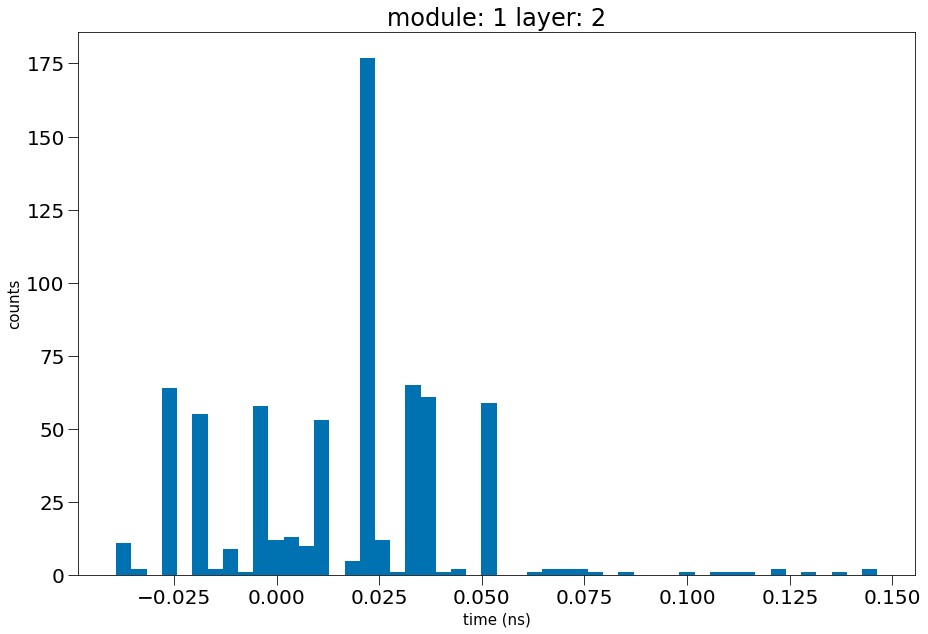

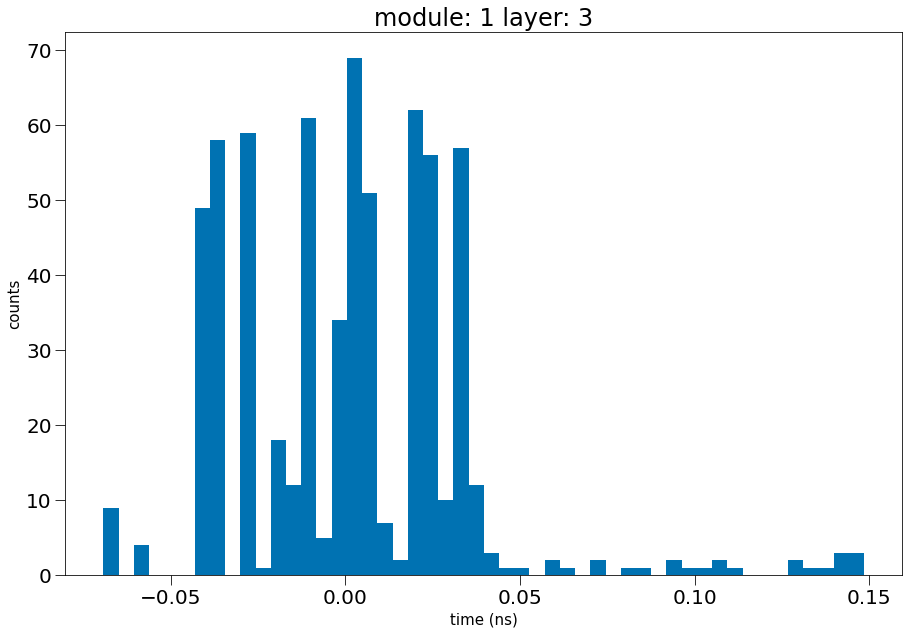

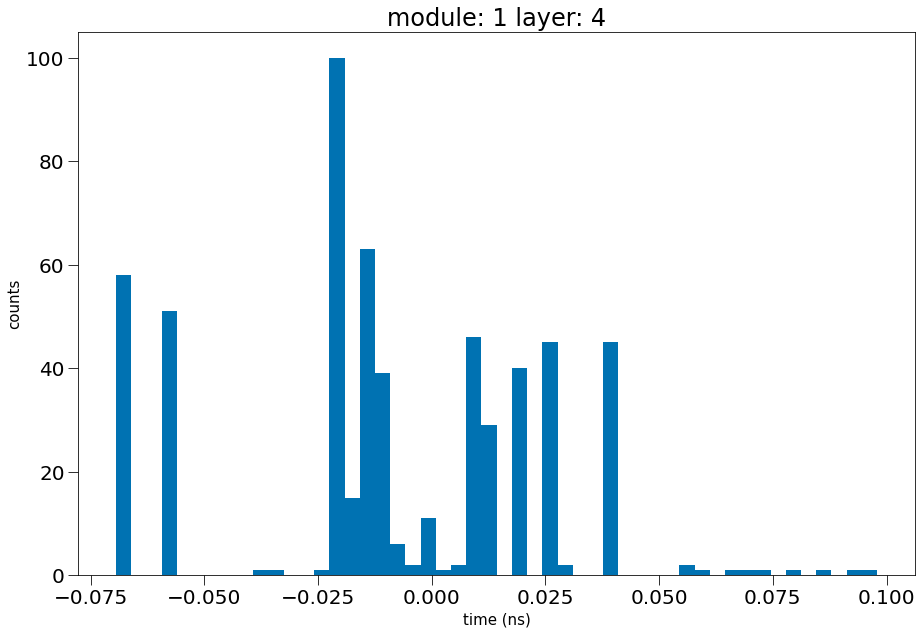

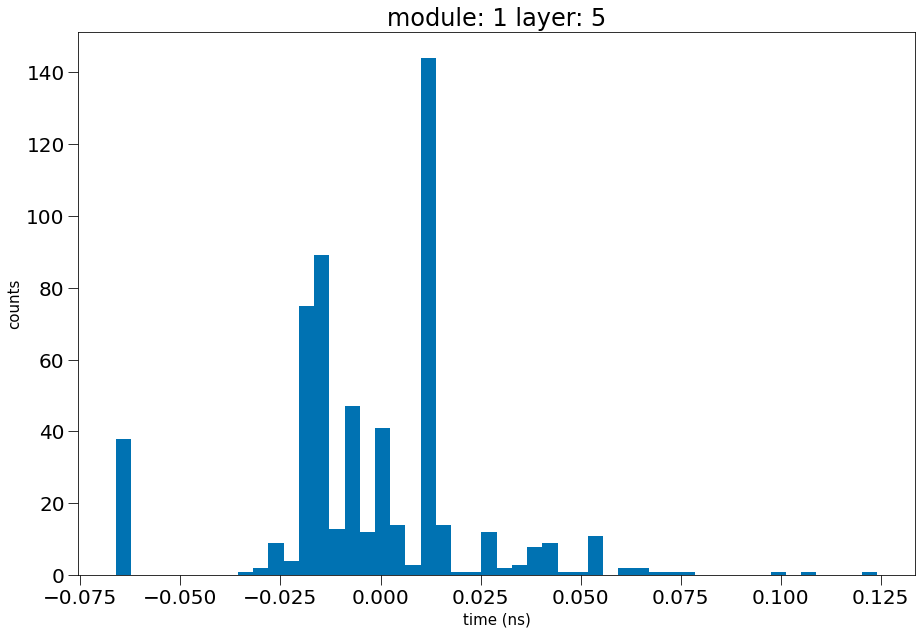

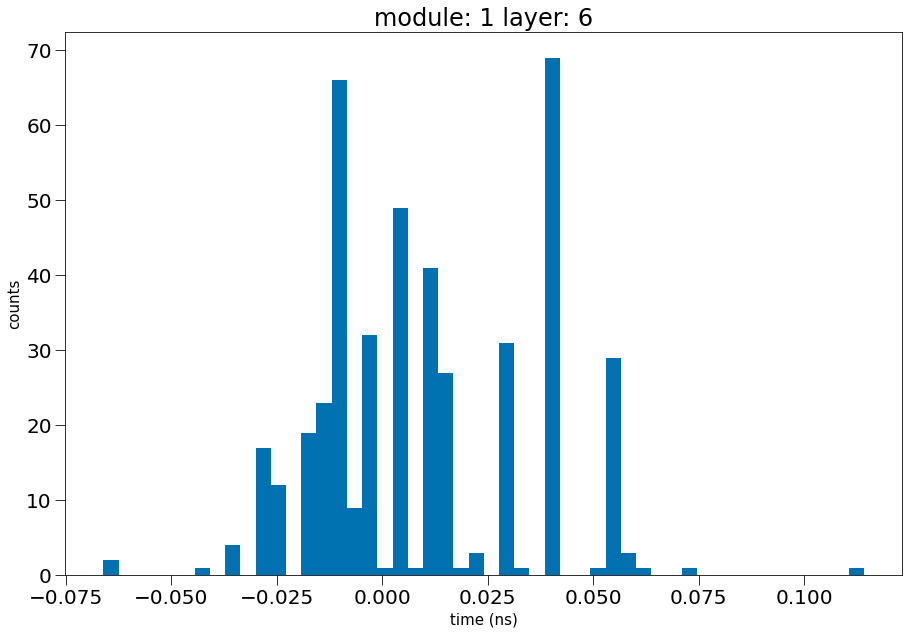

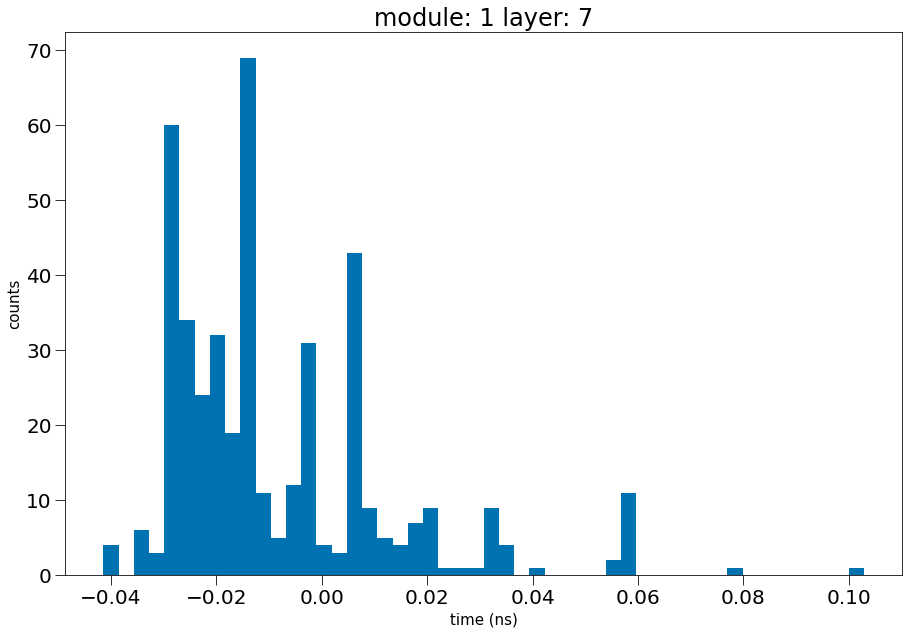

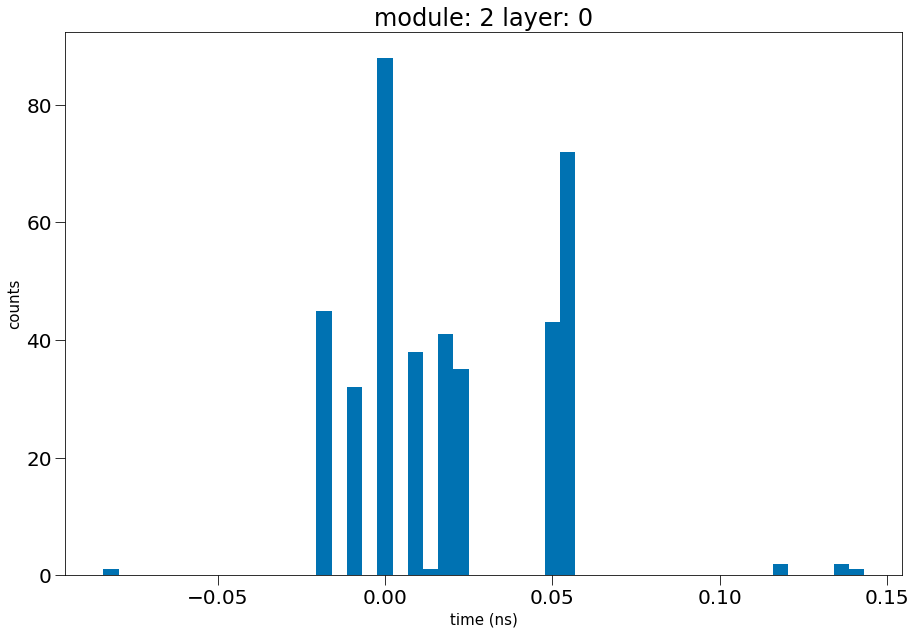

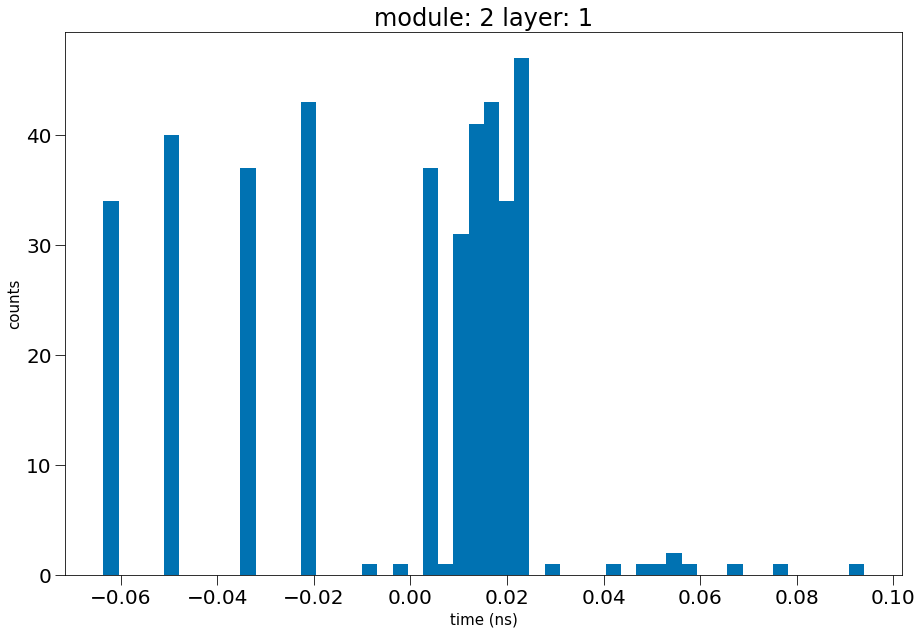

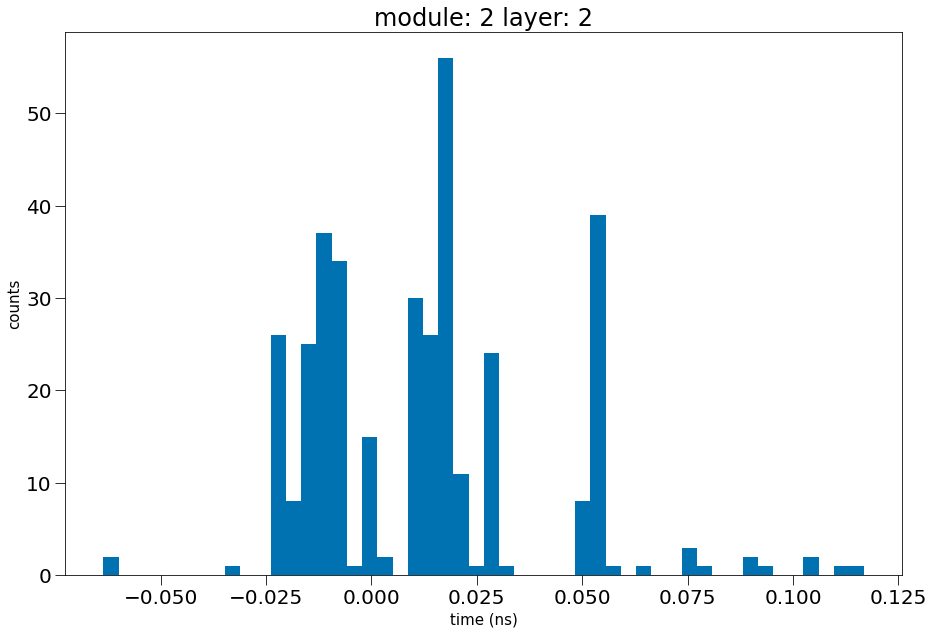

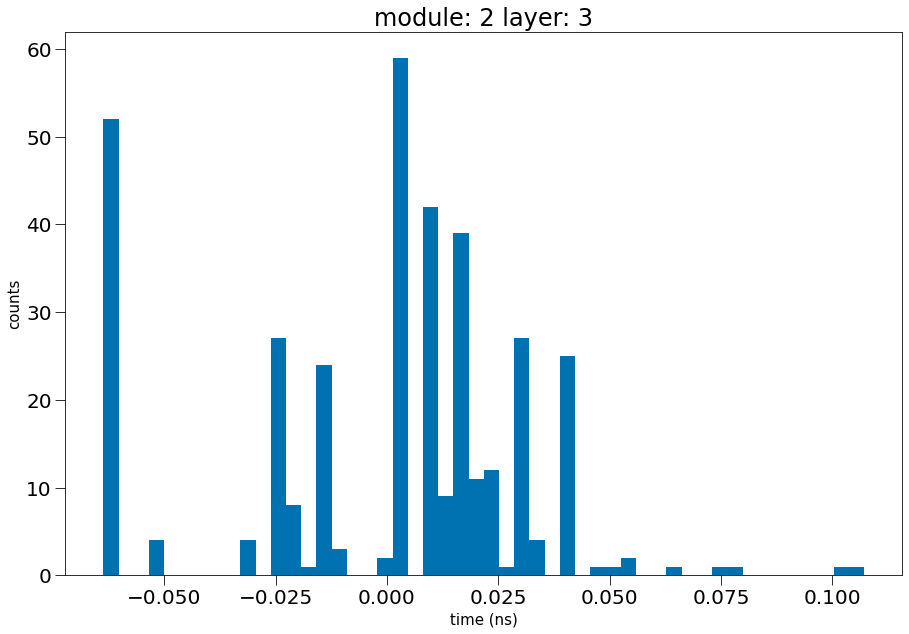

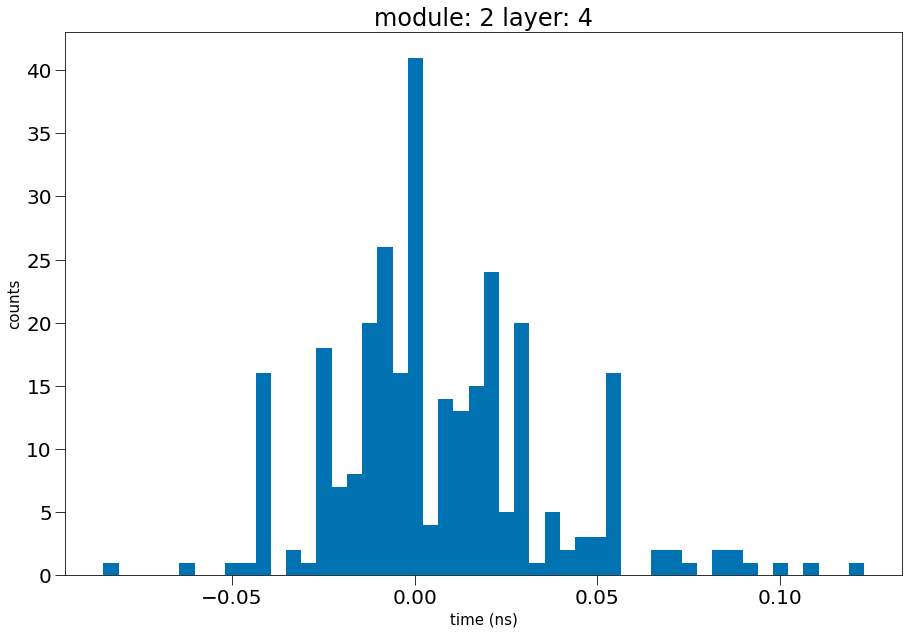

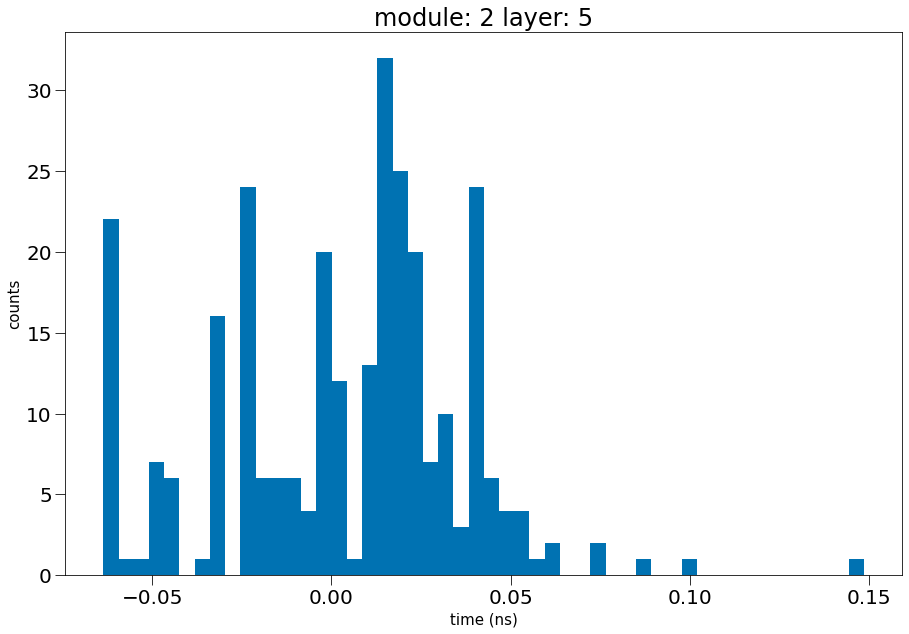

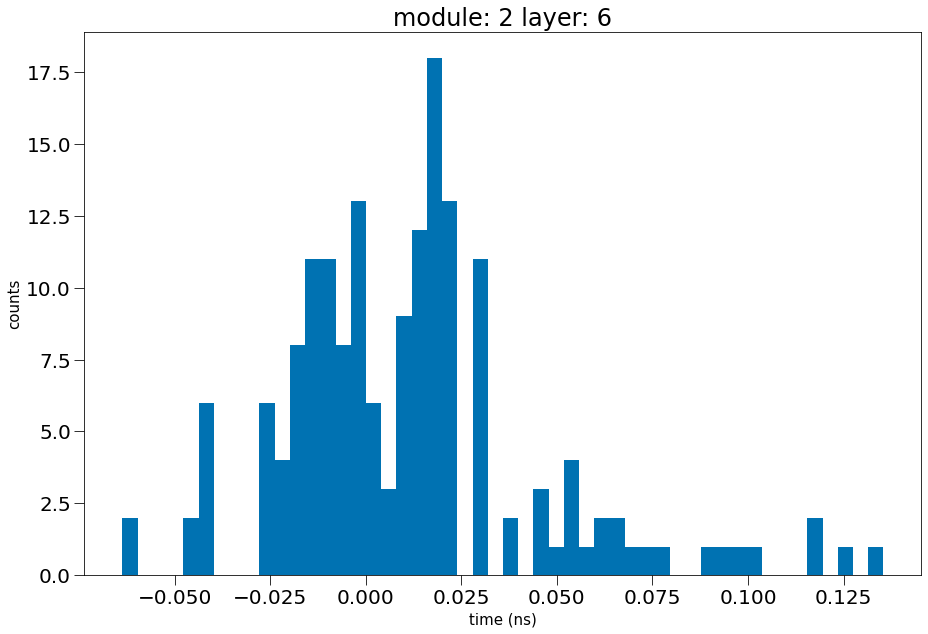

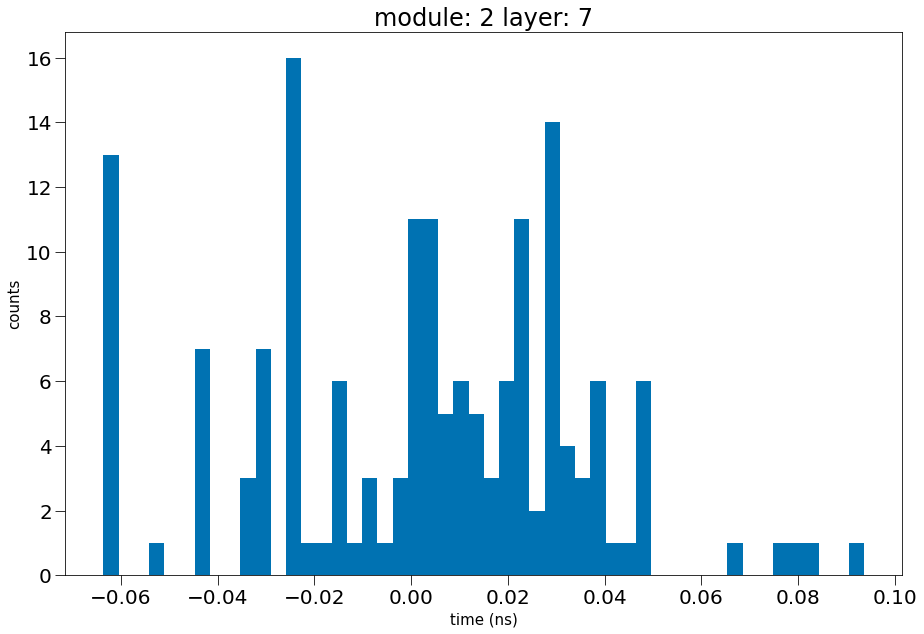

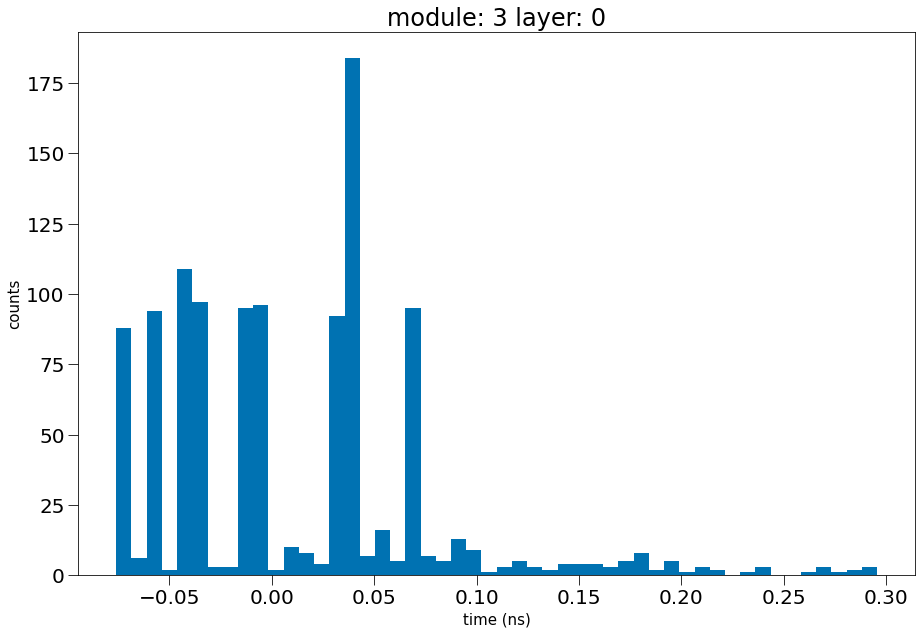

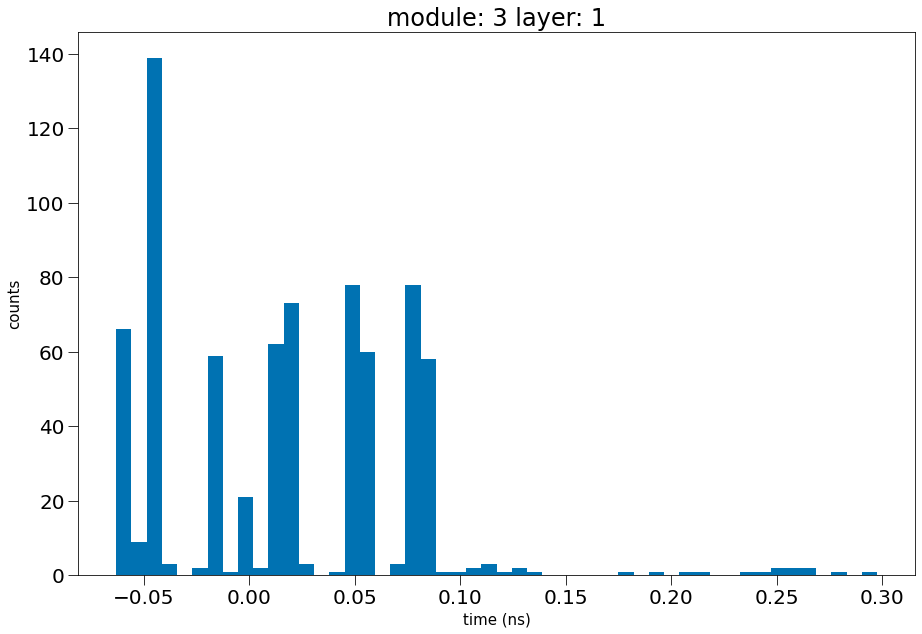

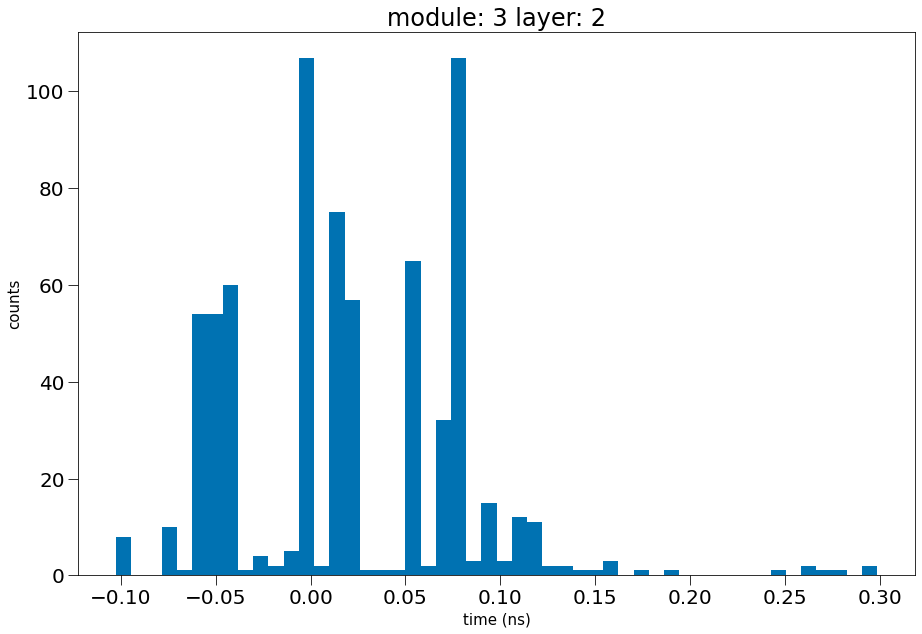

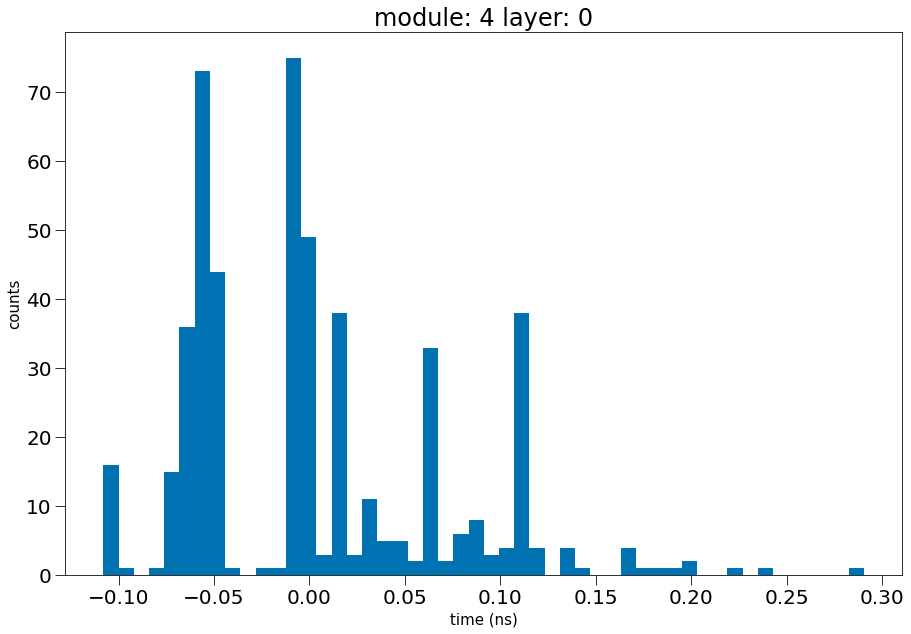

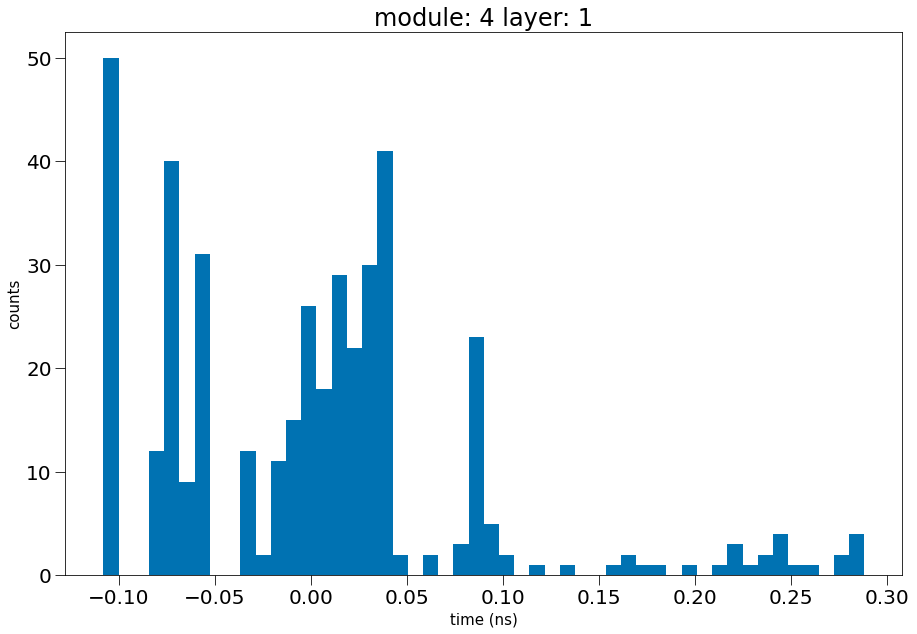

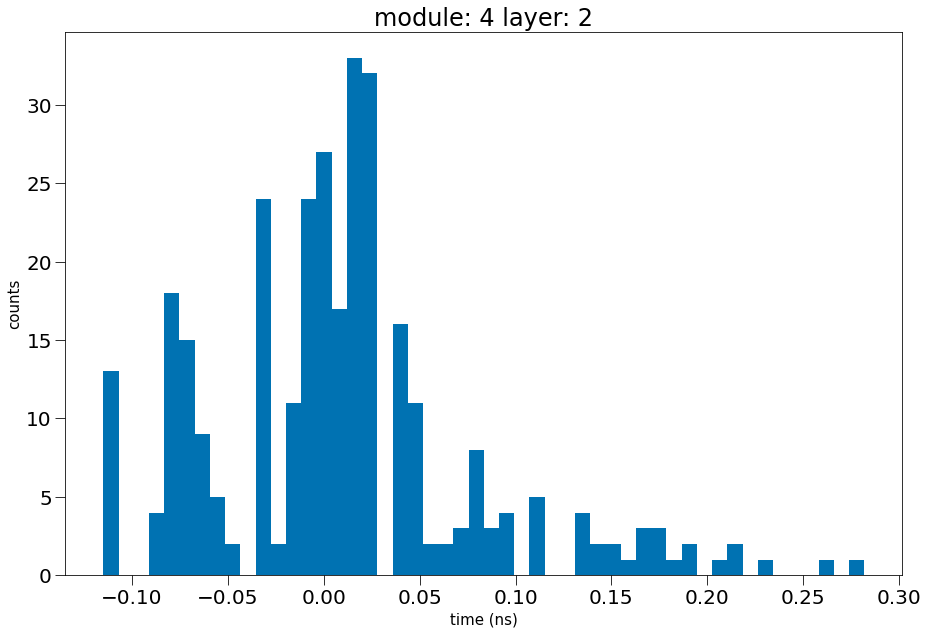

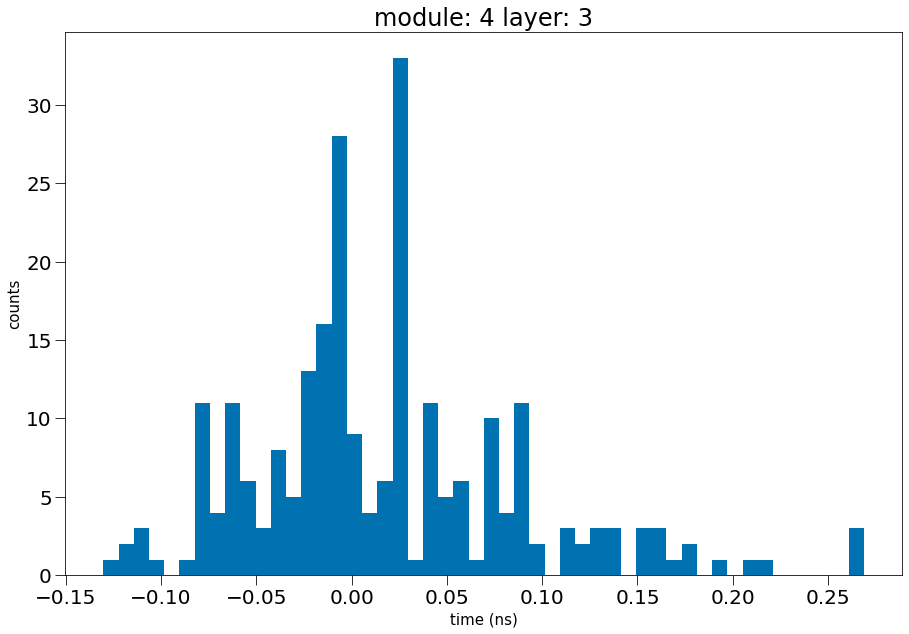

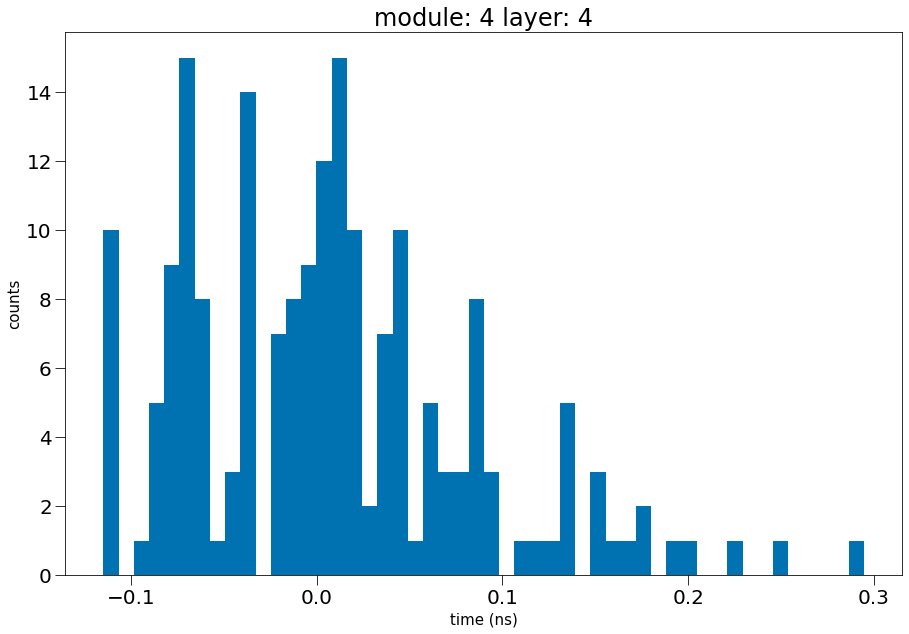

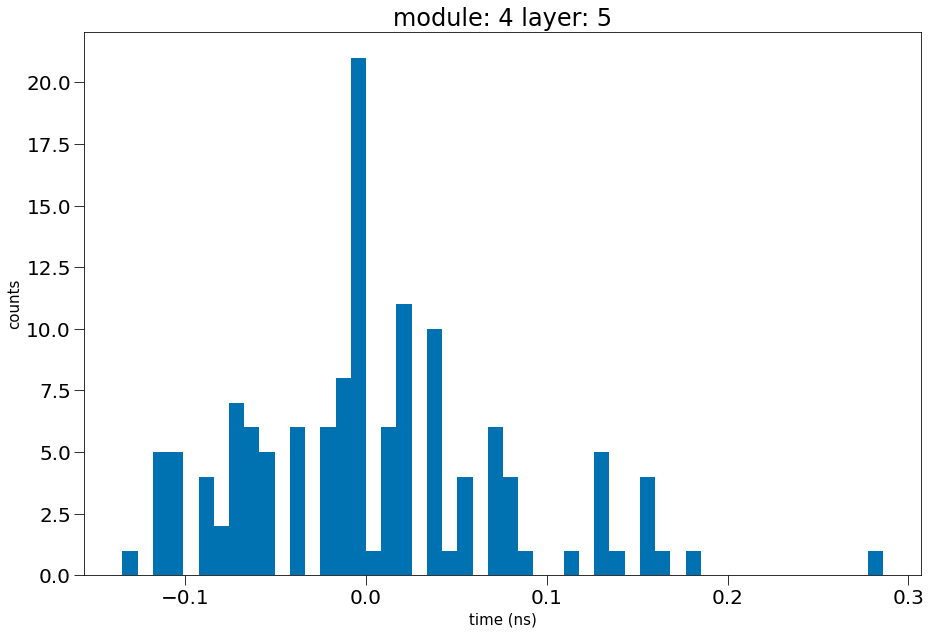

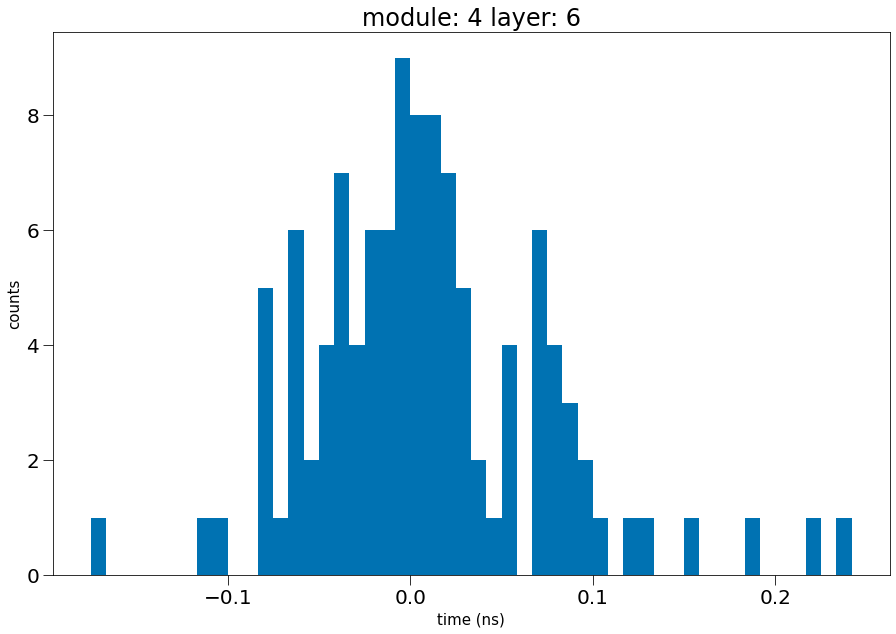

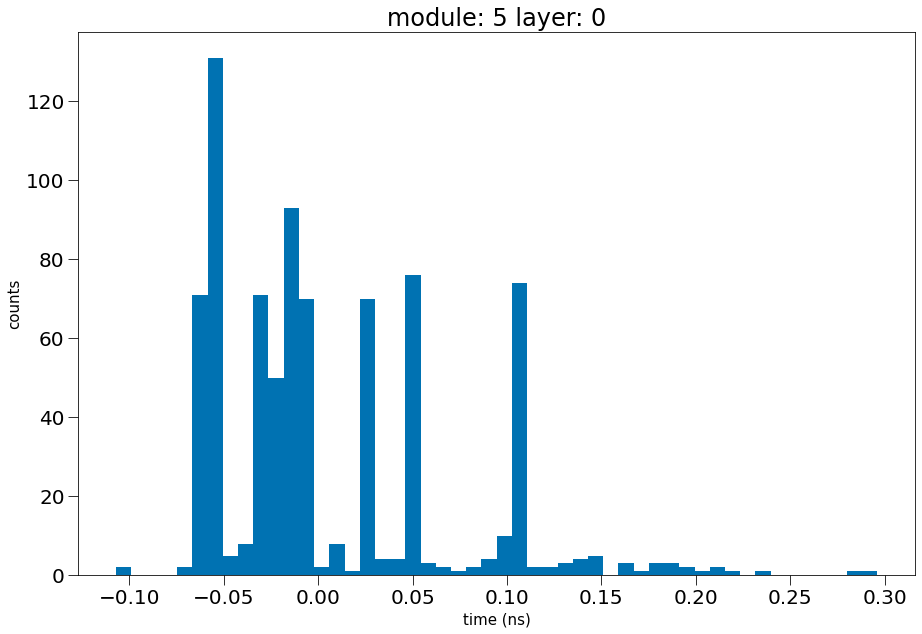

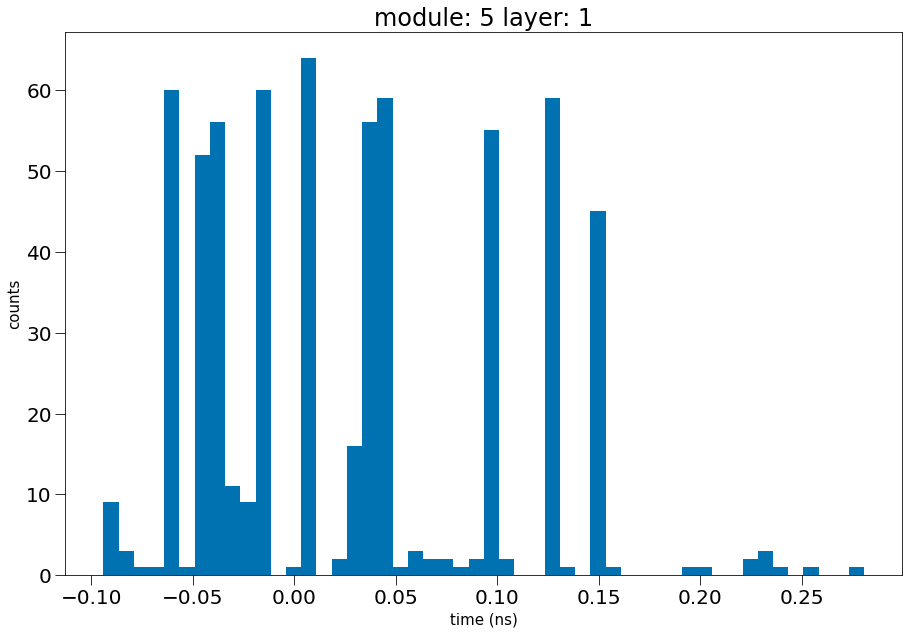

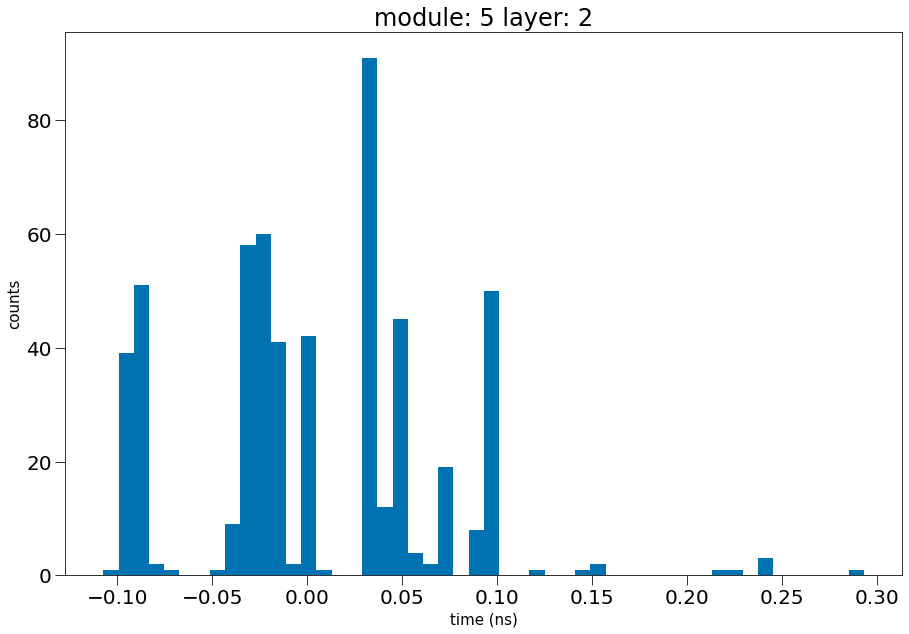

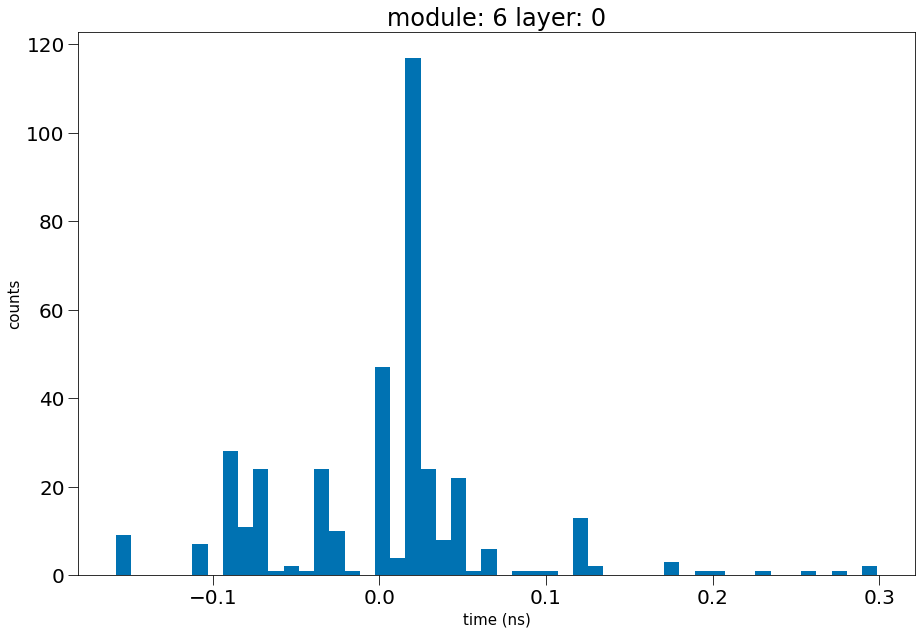

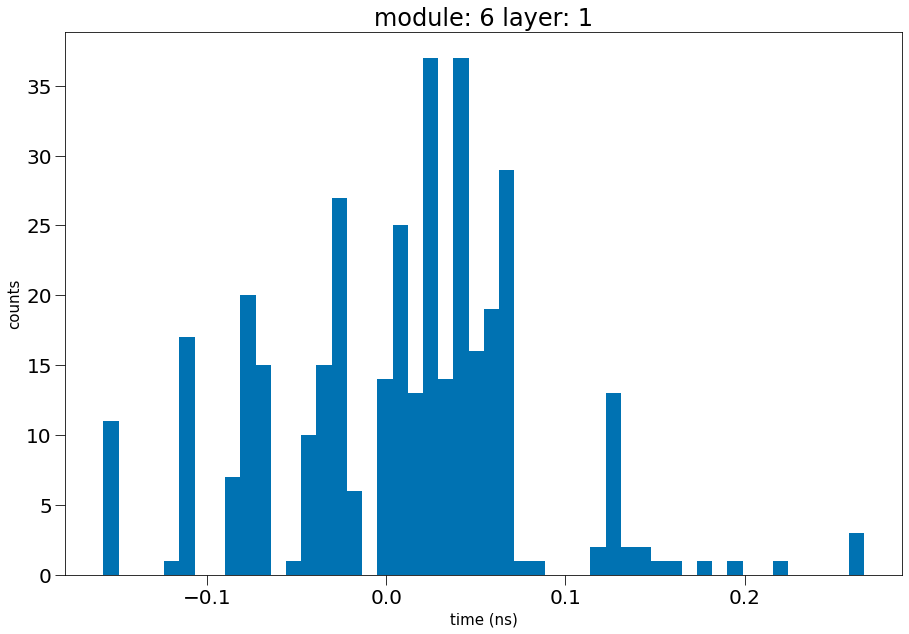

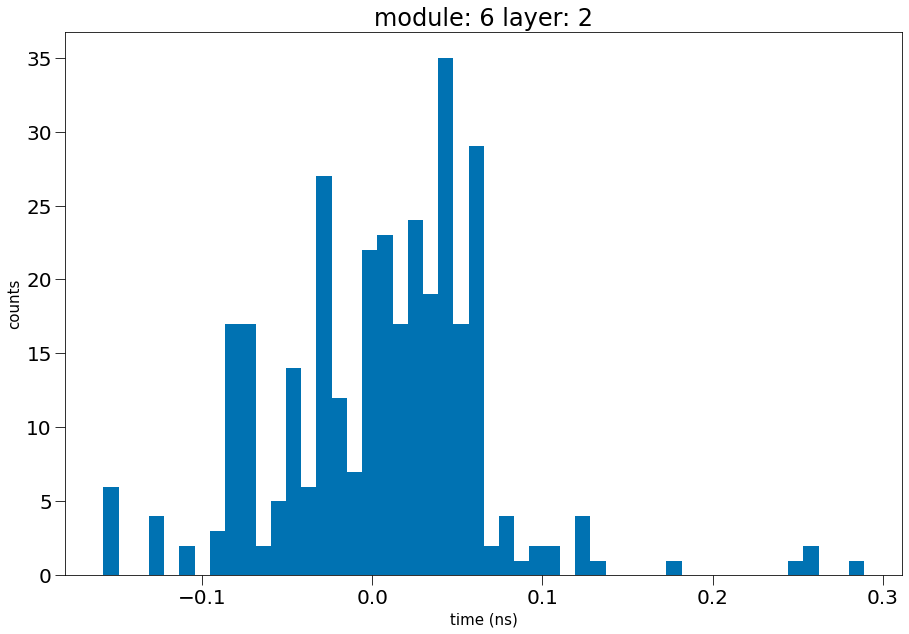

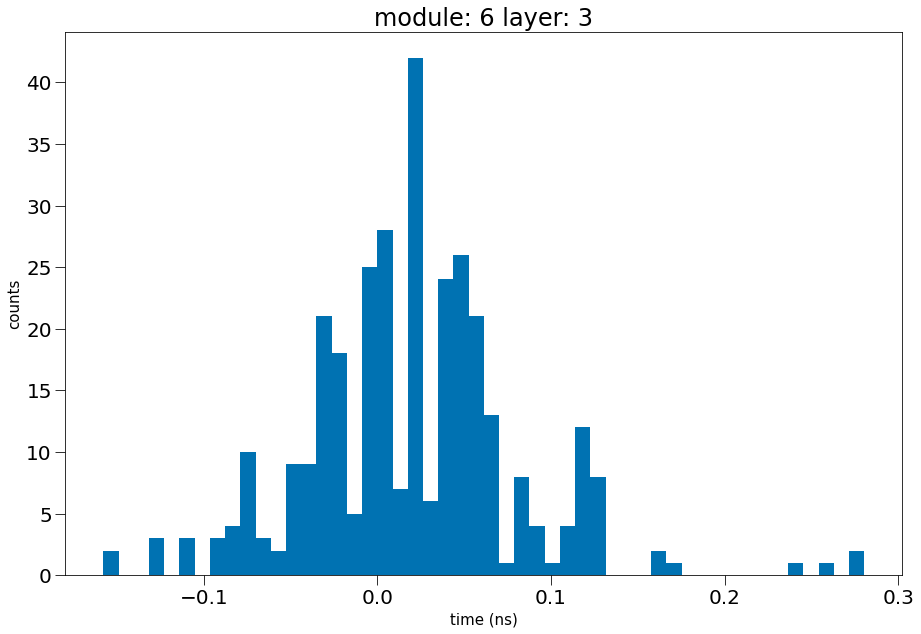

In [107]:
#Finding time distributions for every module-layer pair for truth muons in the hits collection
for i in range(6):
    inMod=(treeNOBIB["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(treeNOBIB["layer"].array()==j)
        inside=inLayer & inMod
        time=treeNOBIB["t"].array()[inside]
        plot1DHistogram(time, bins=50, label=("module: " +str(i+1) + " layer: " + str(j) +";time (ns);counts"))

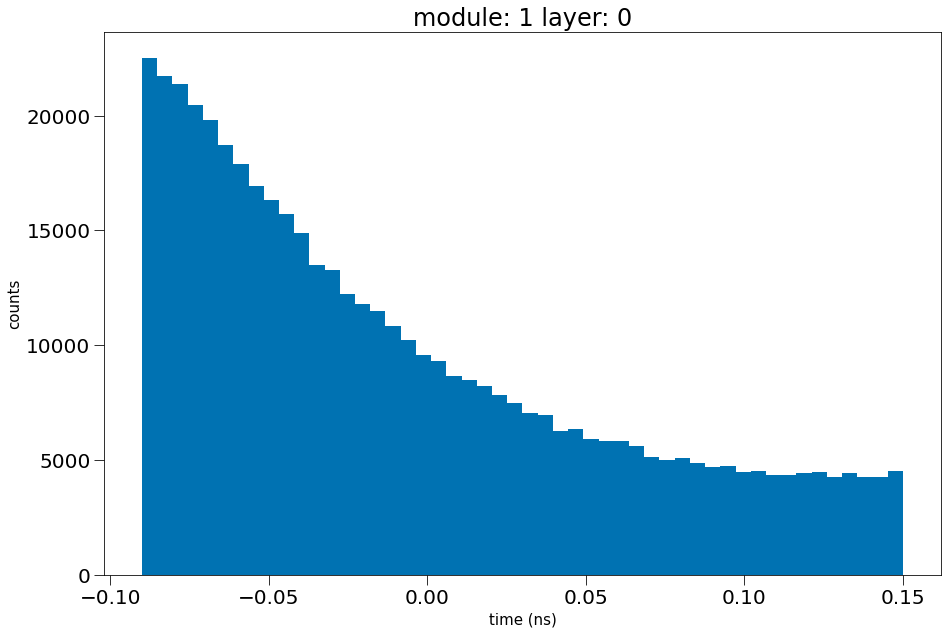

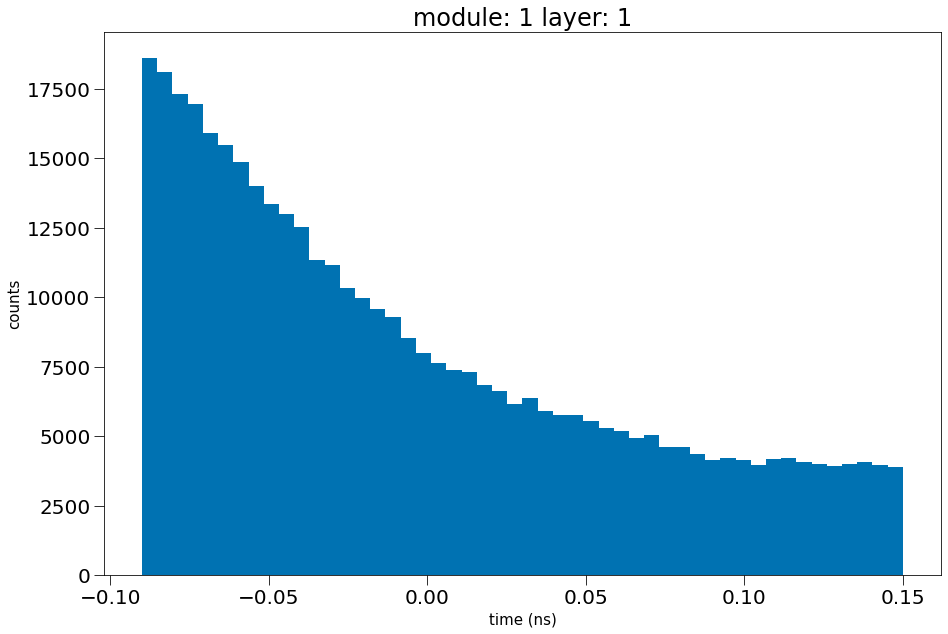

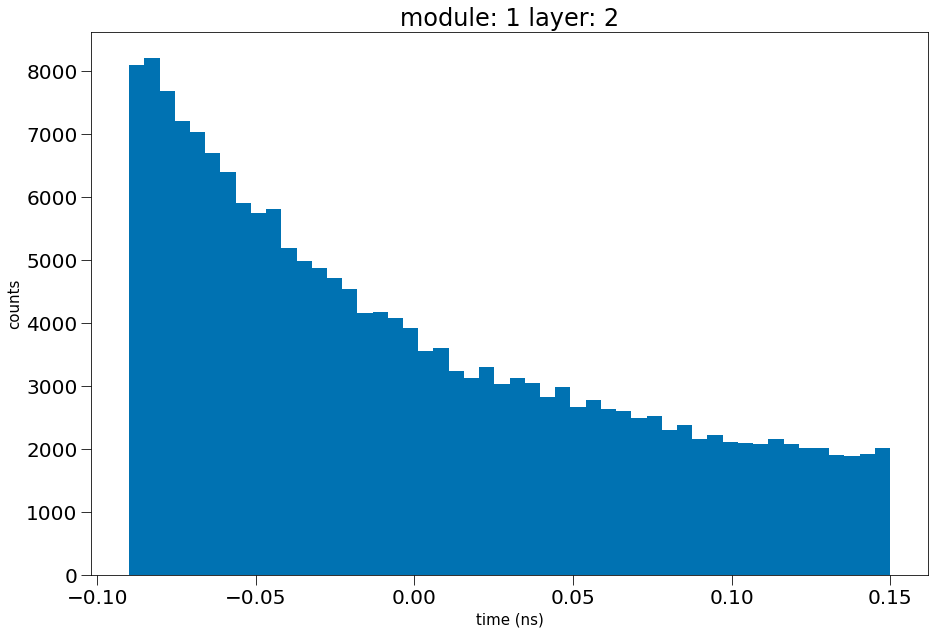

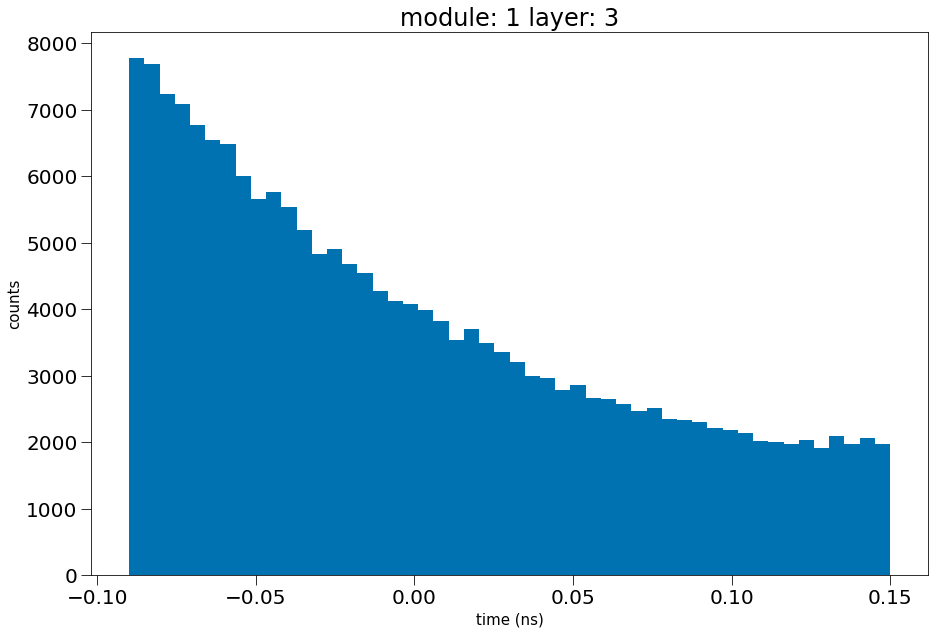

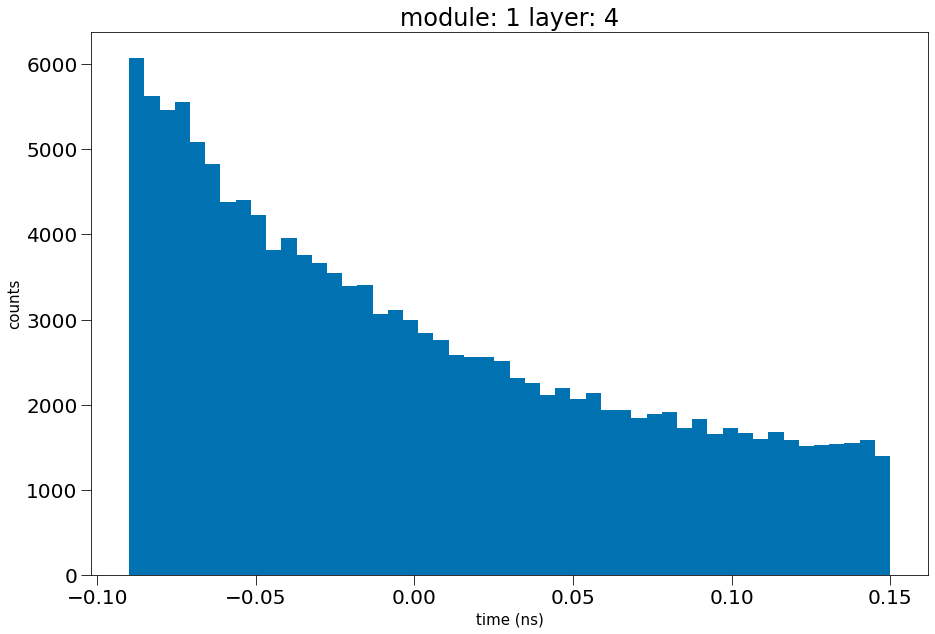

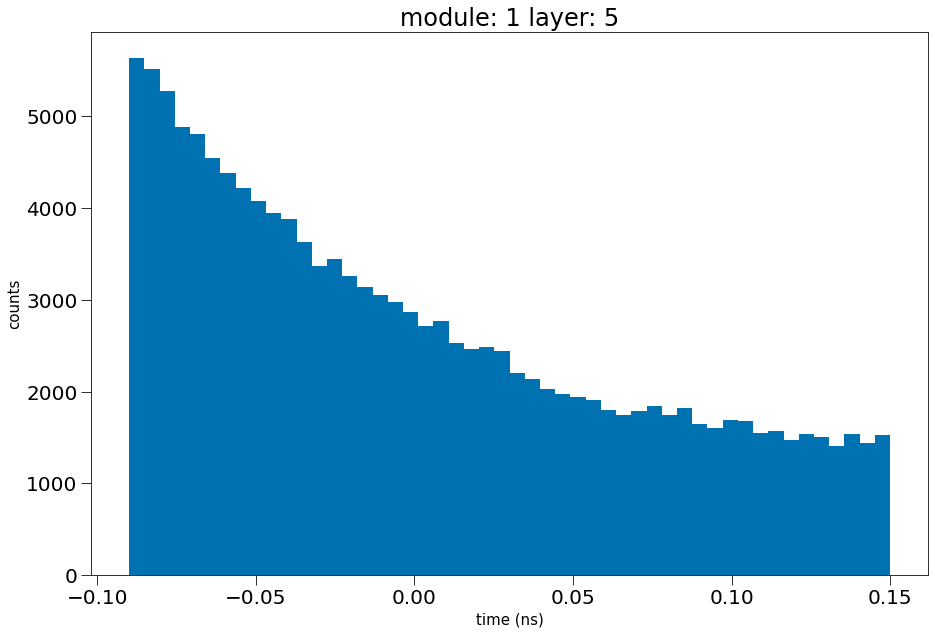

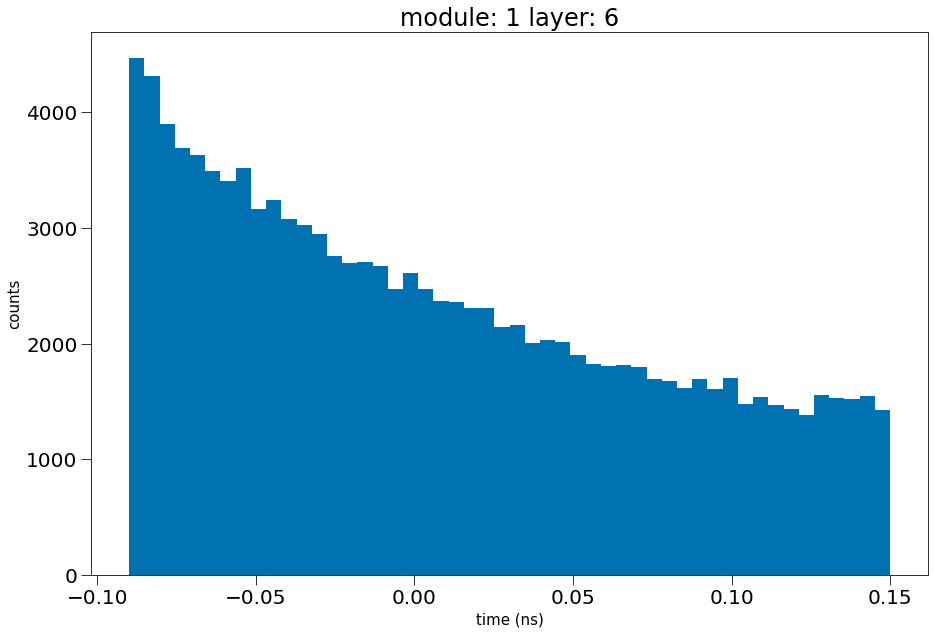

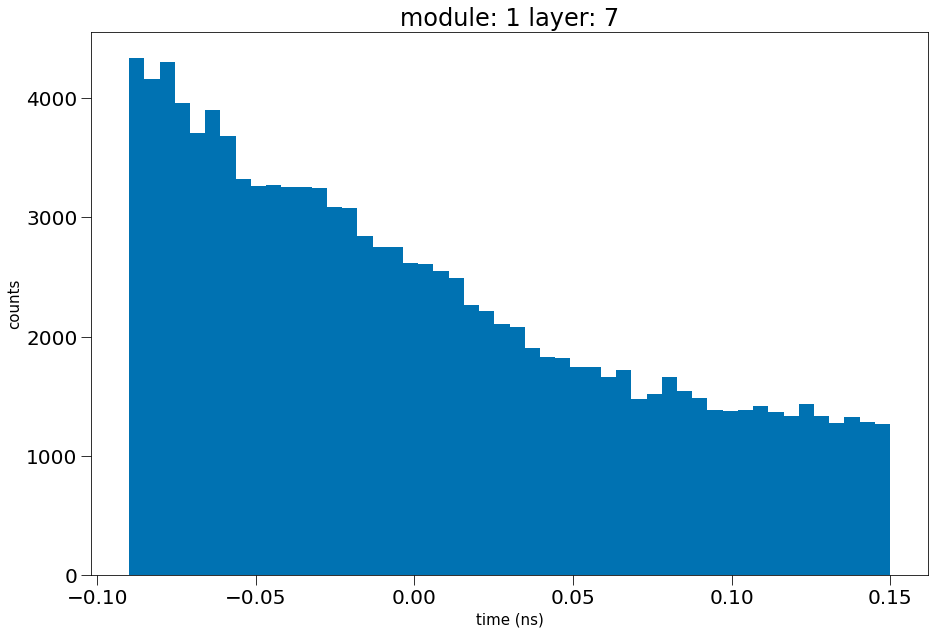

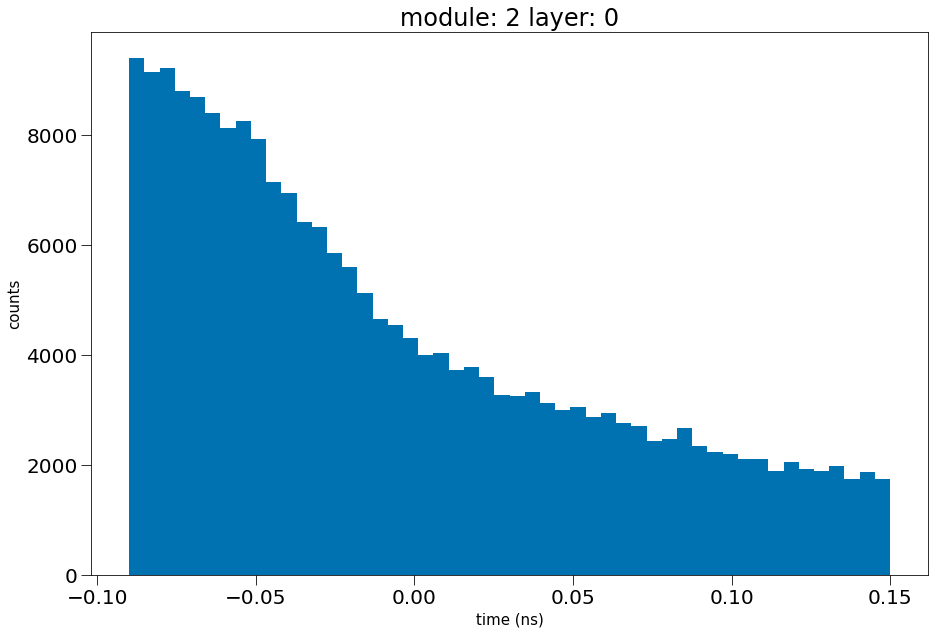

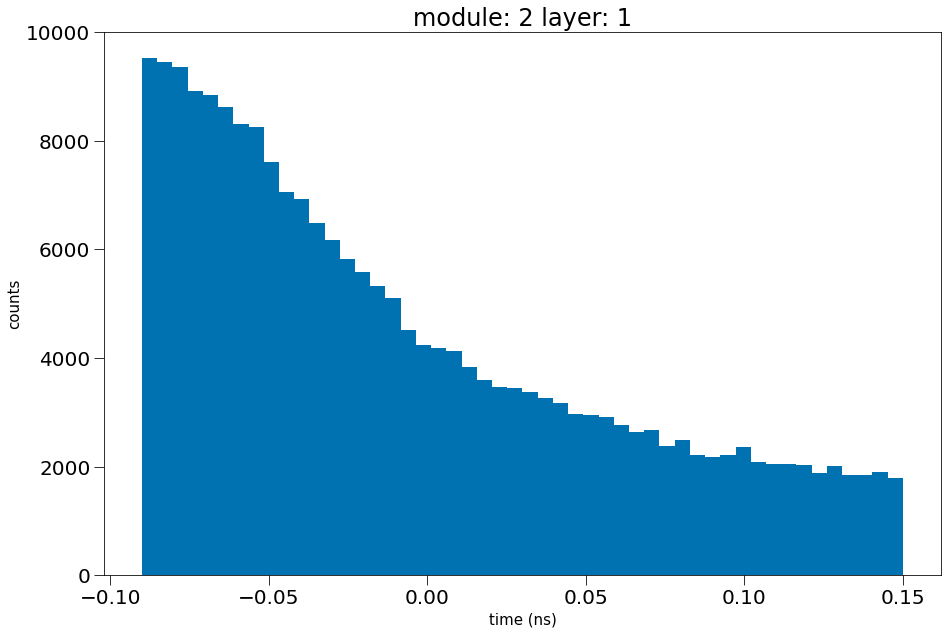

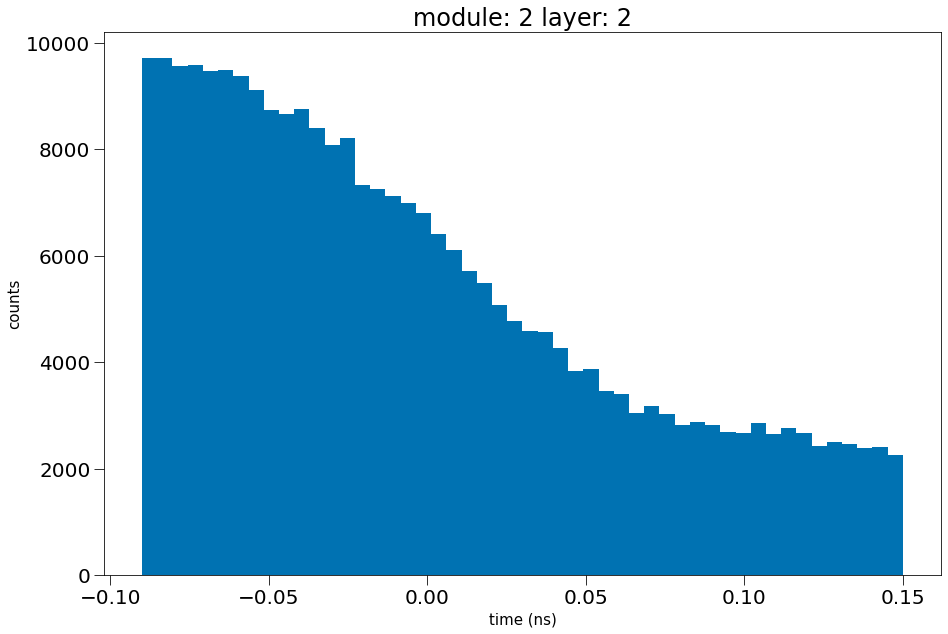

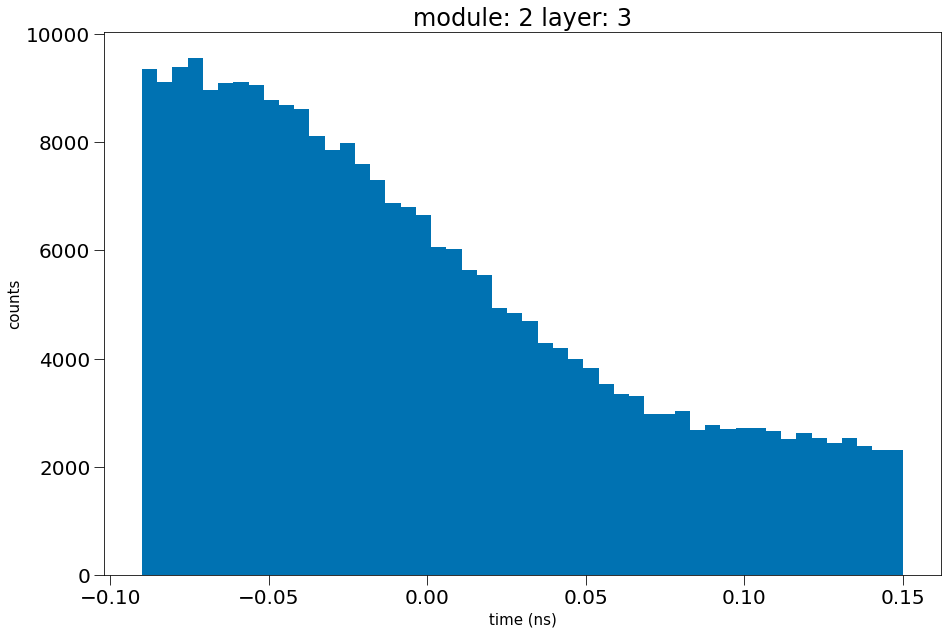

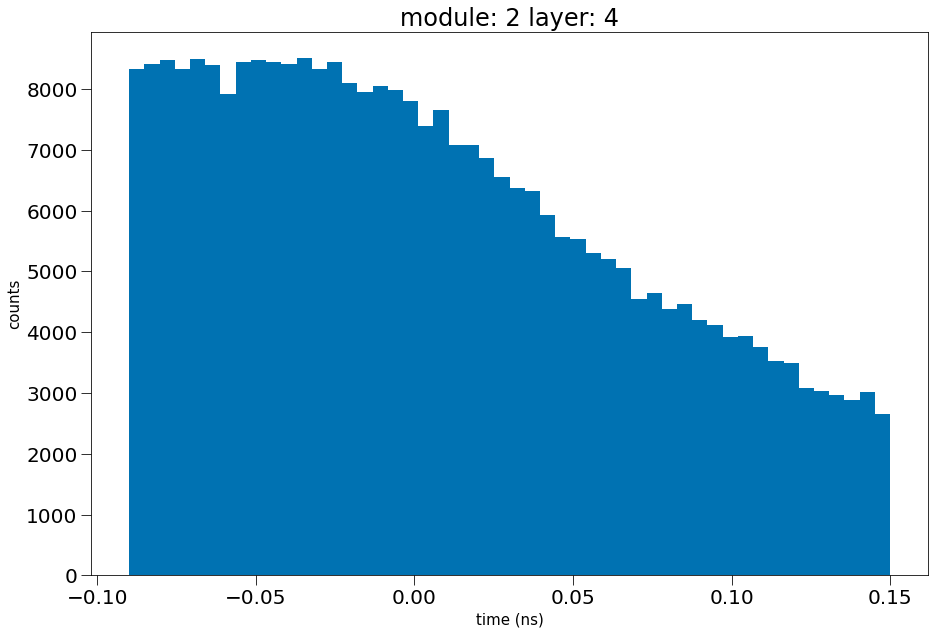

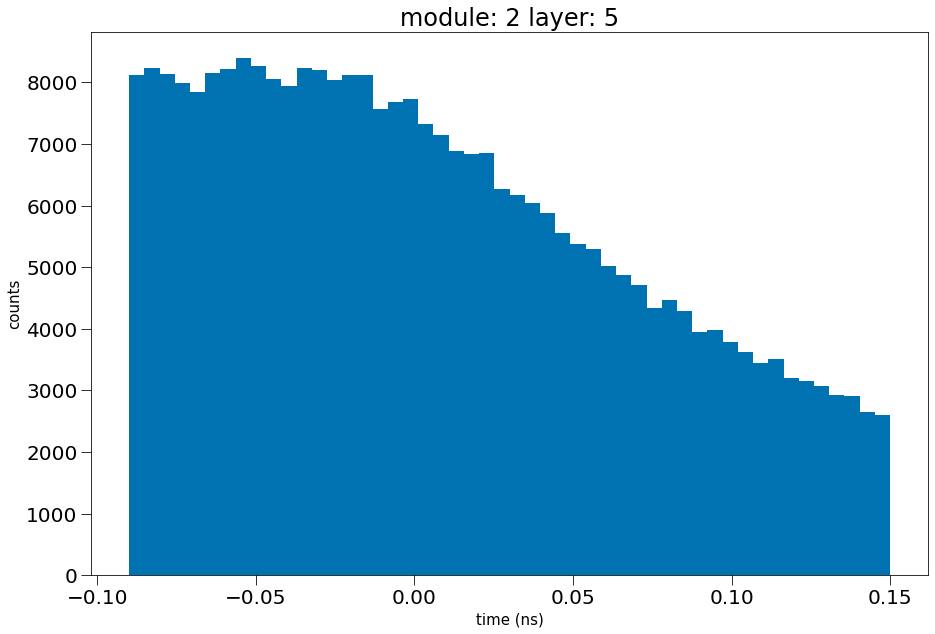

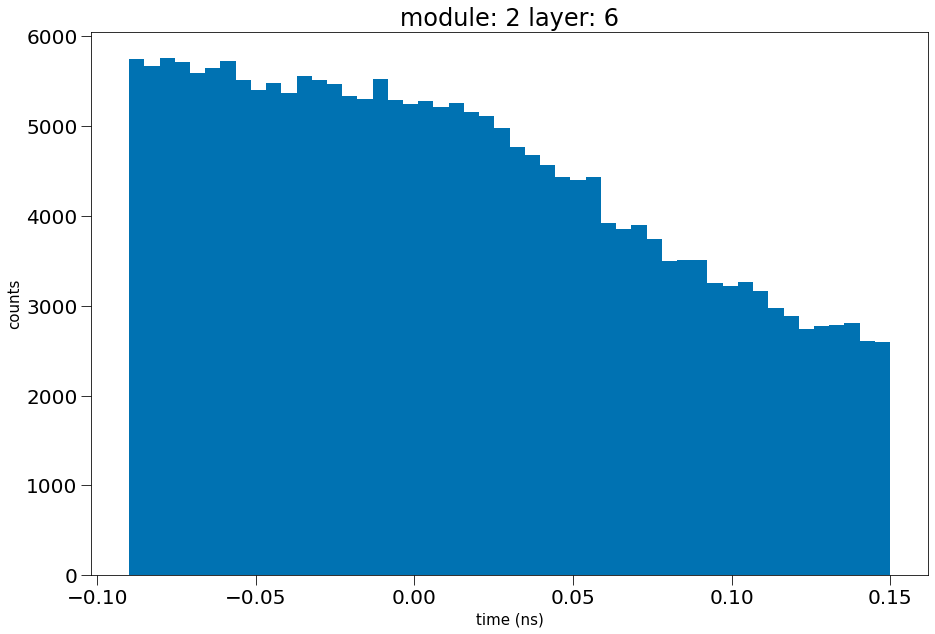

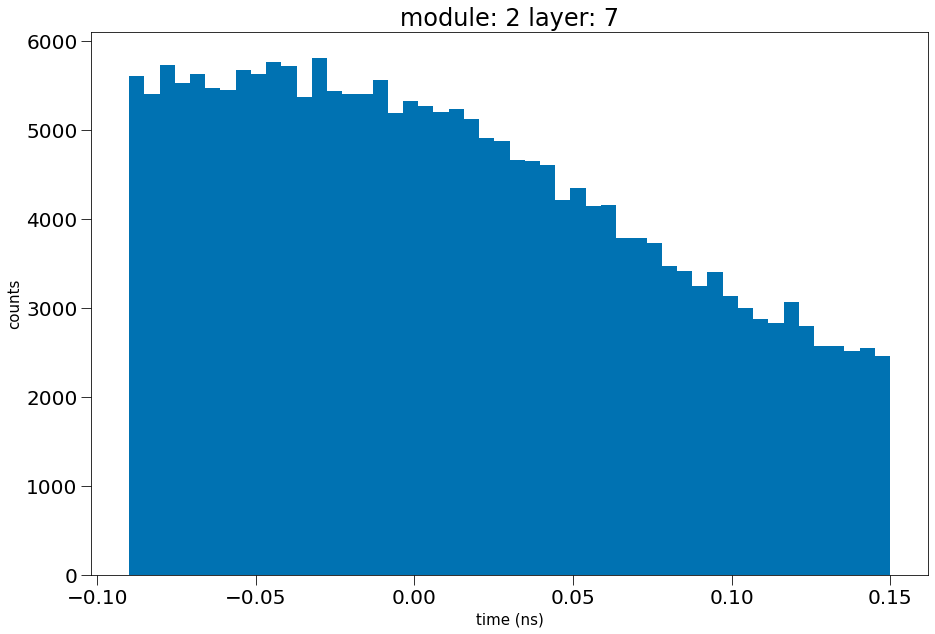

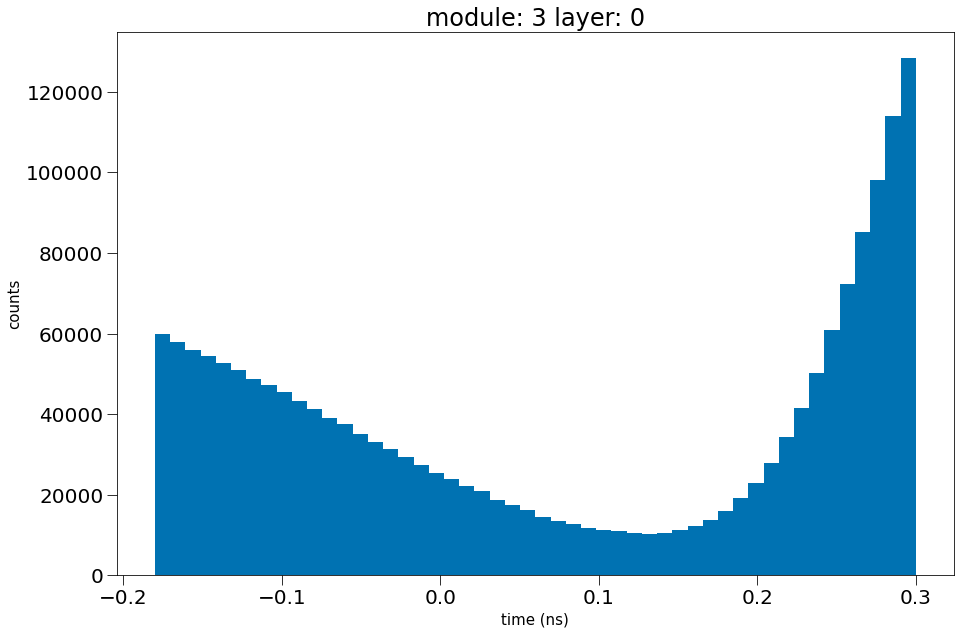

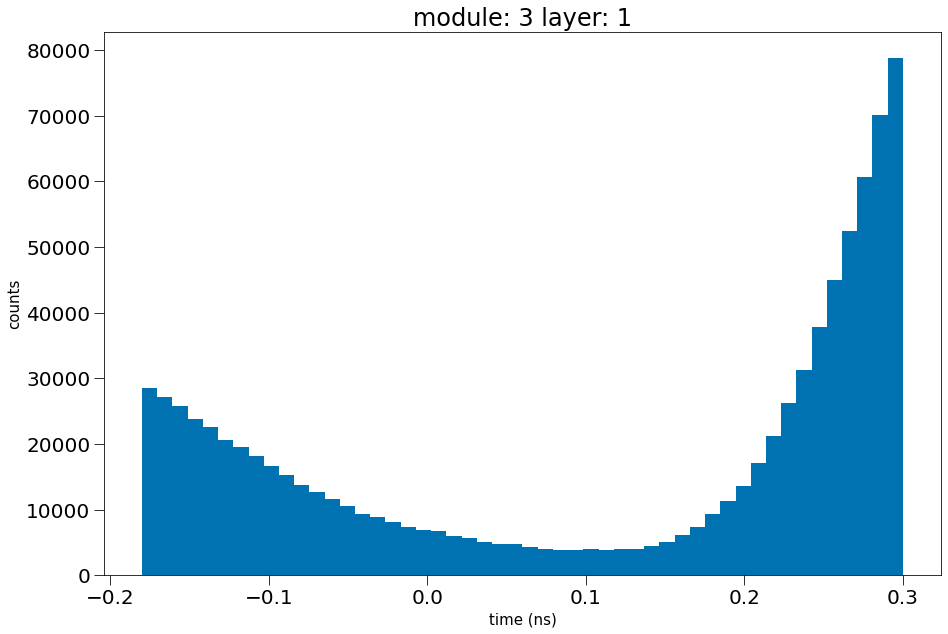

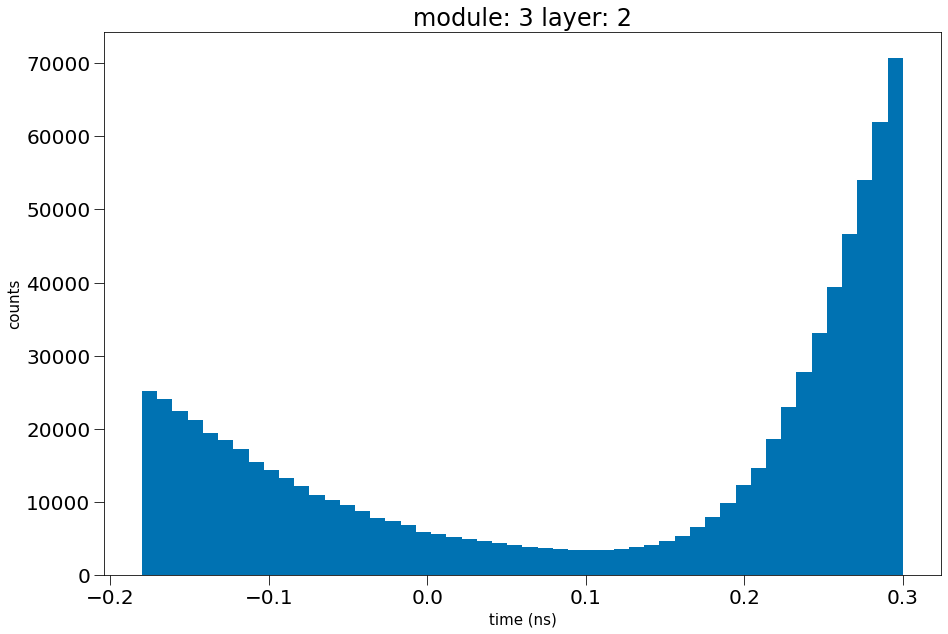

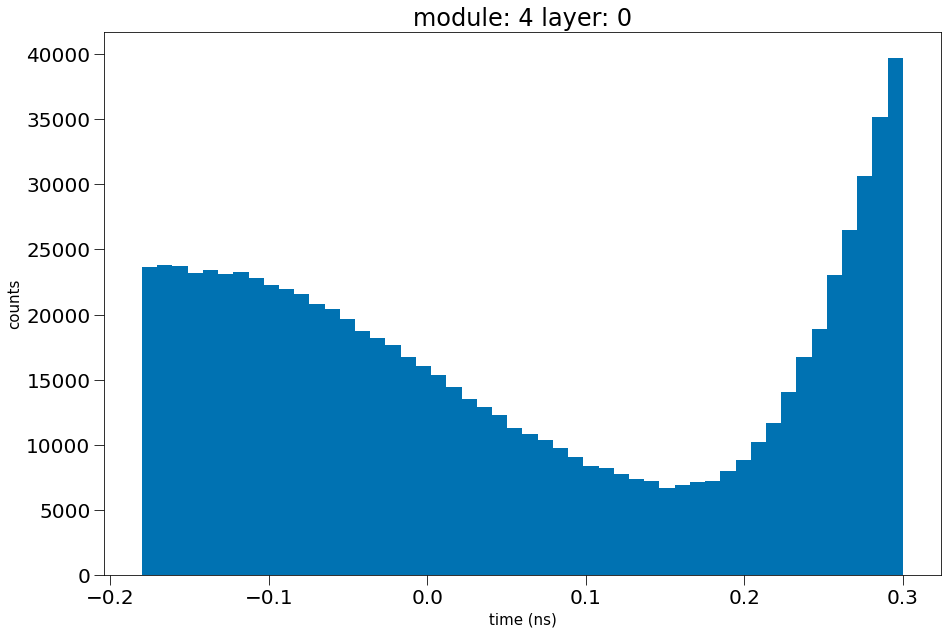

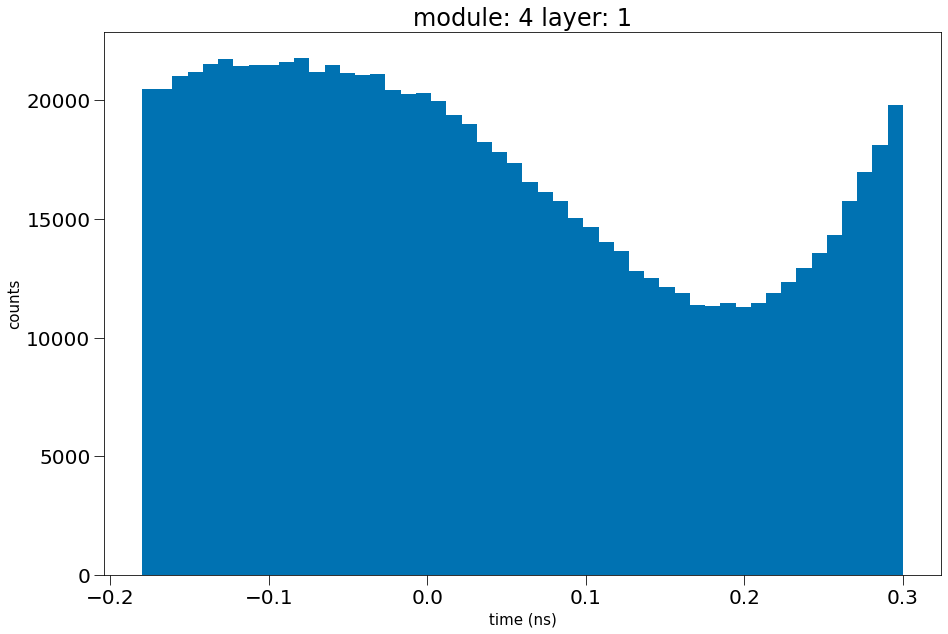

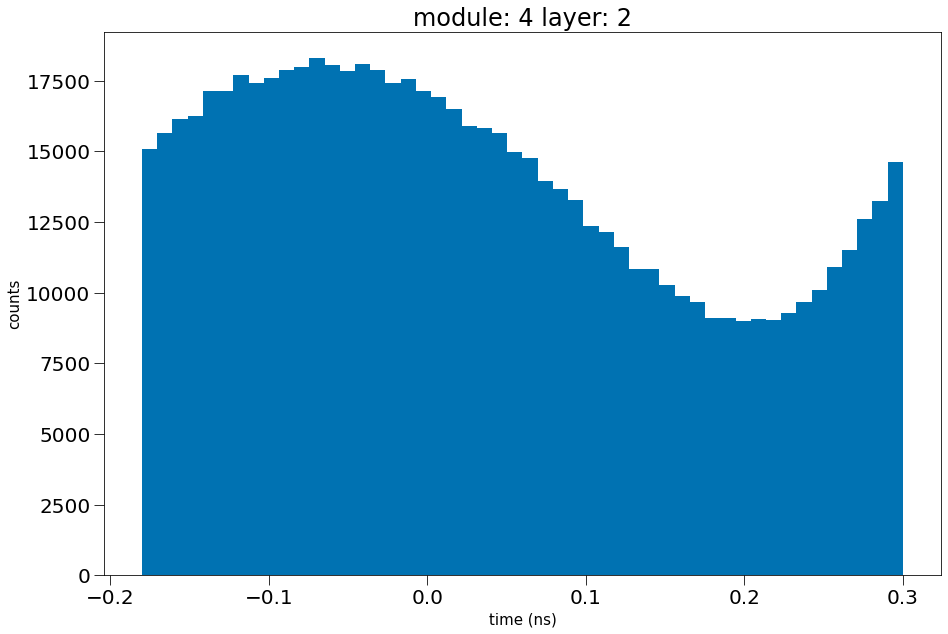

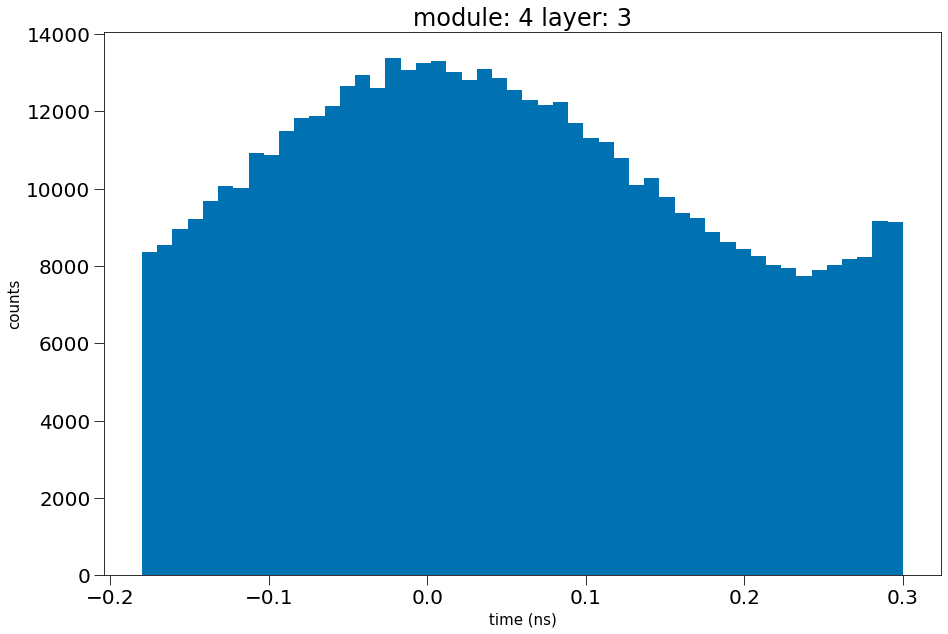

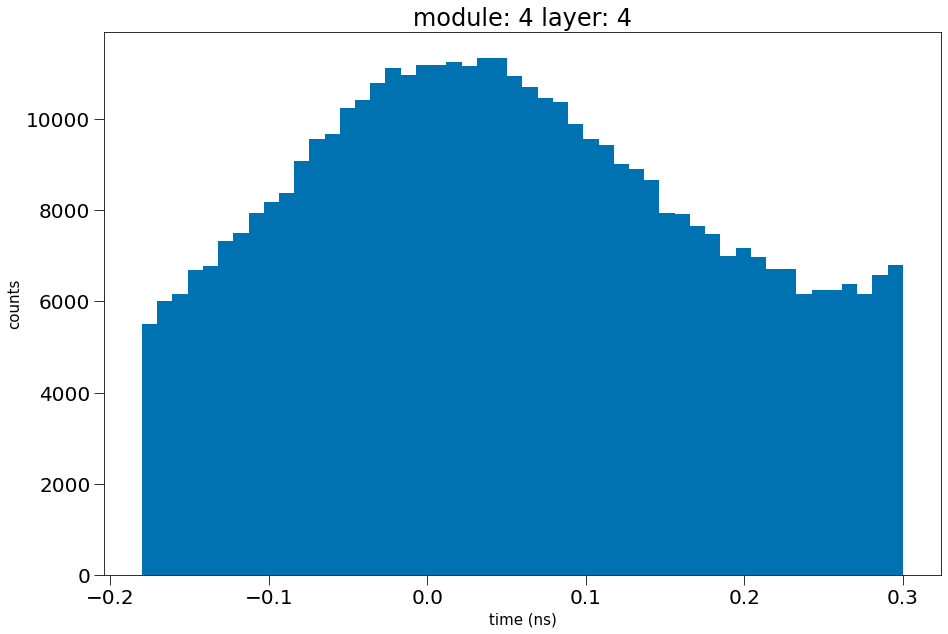

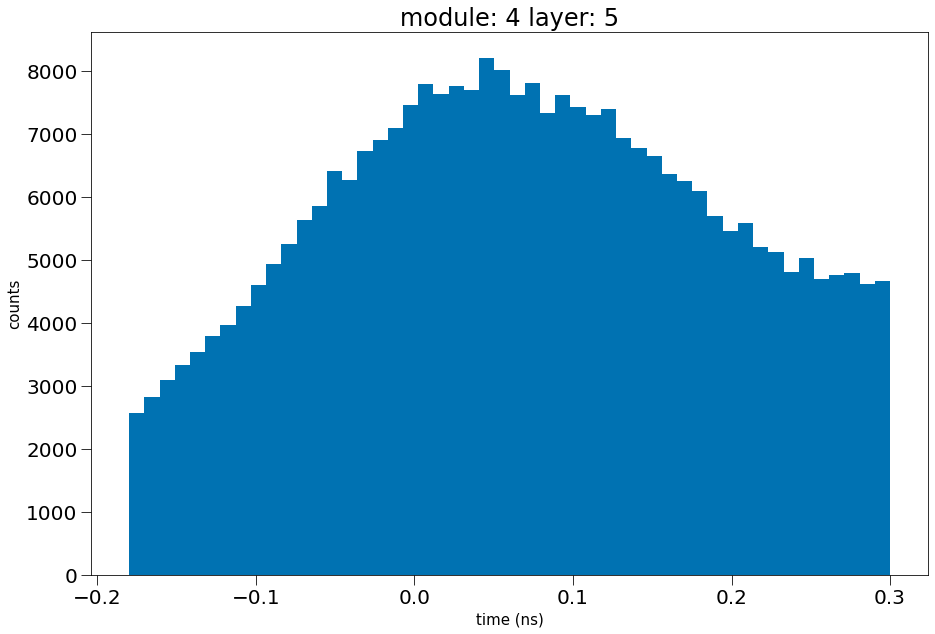

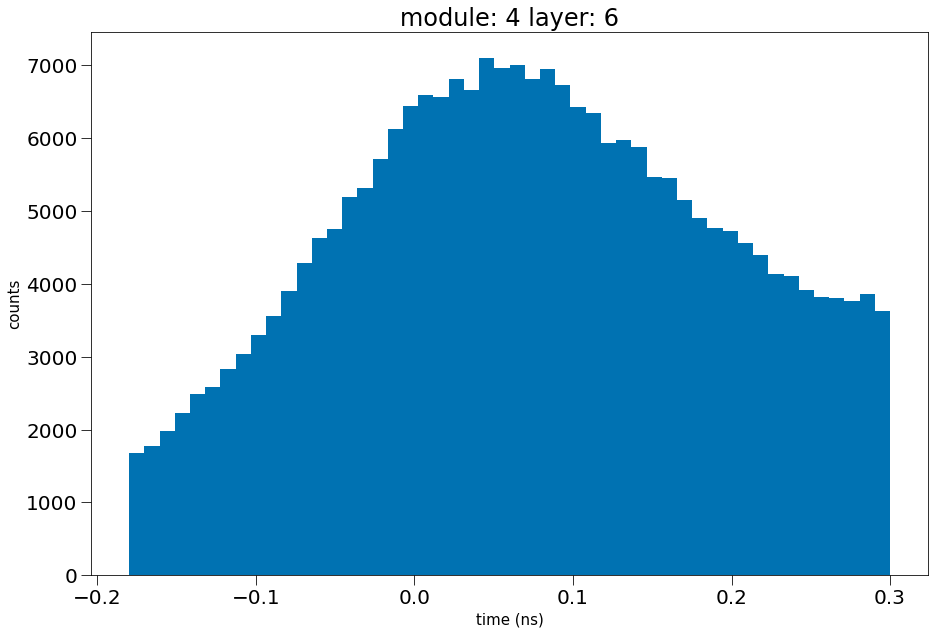

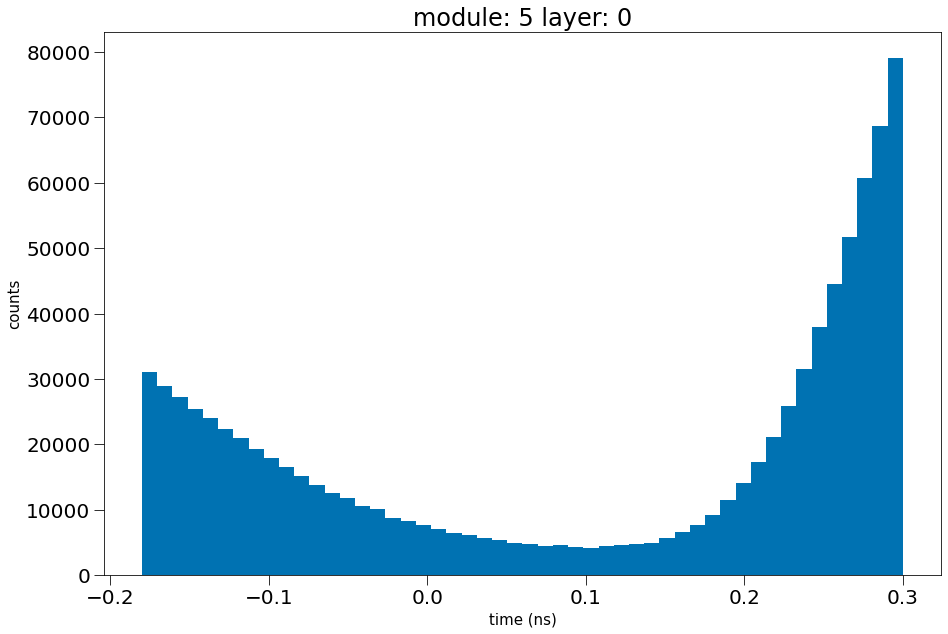

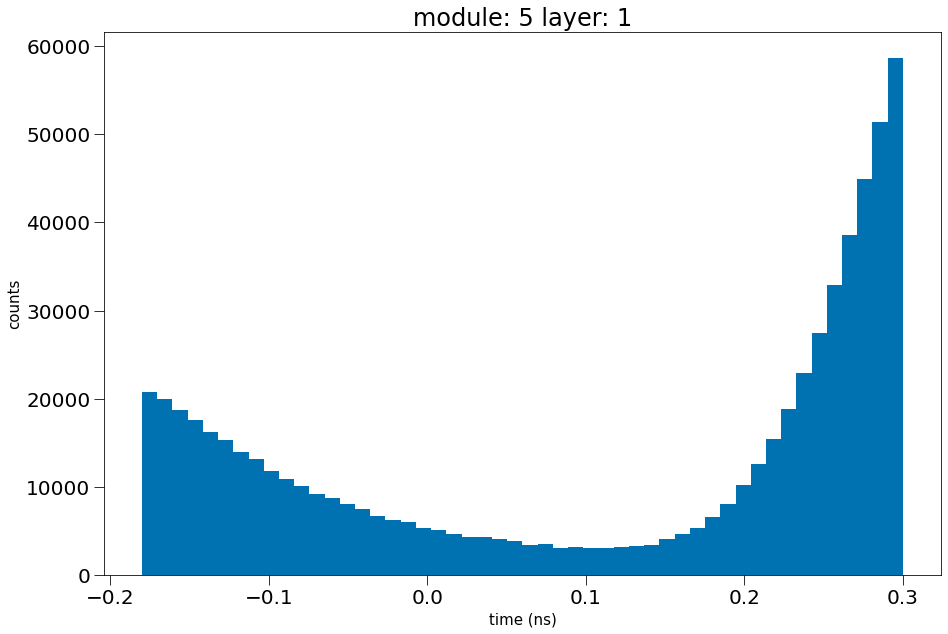

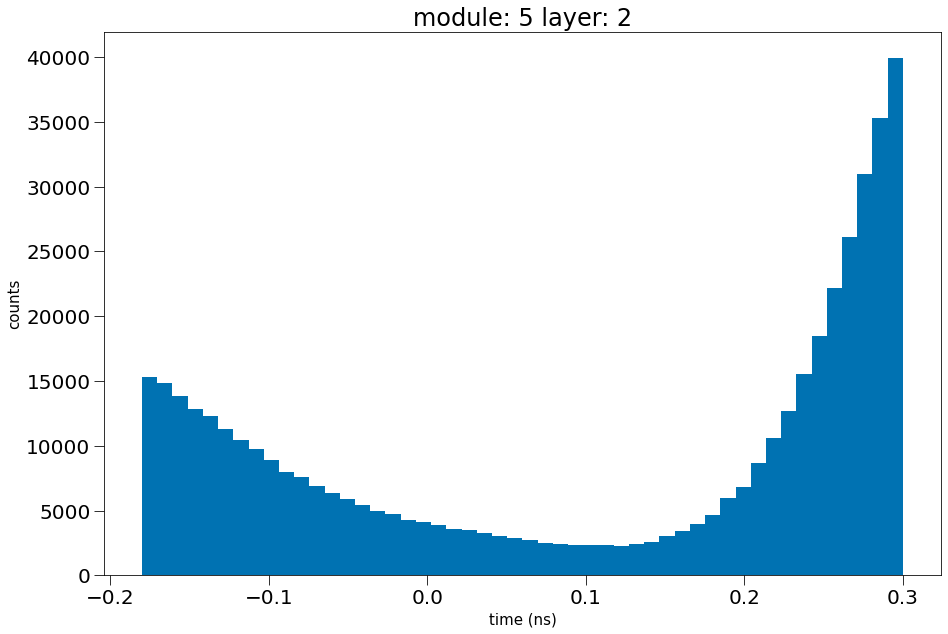

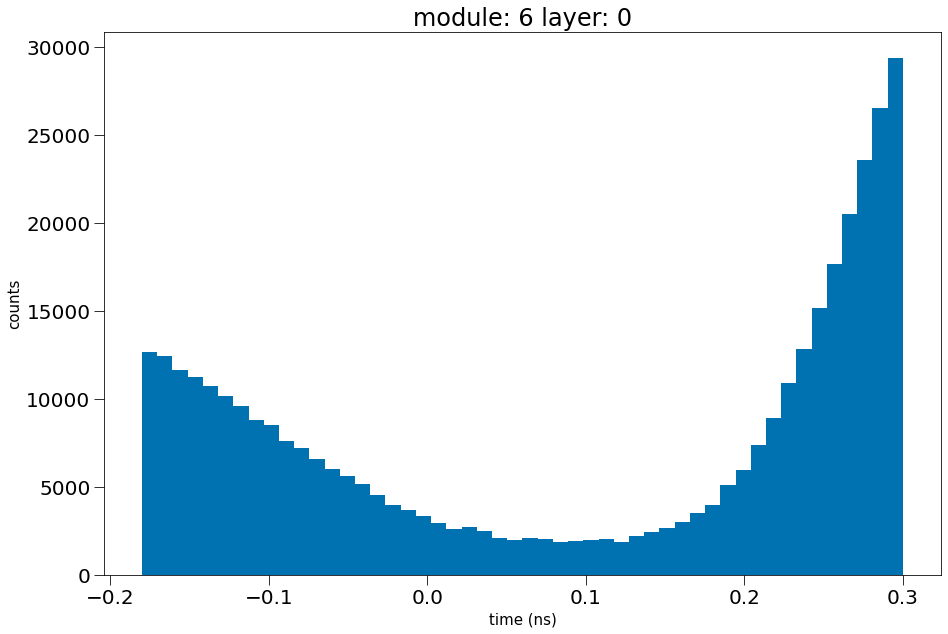

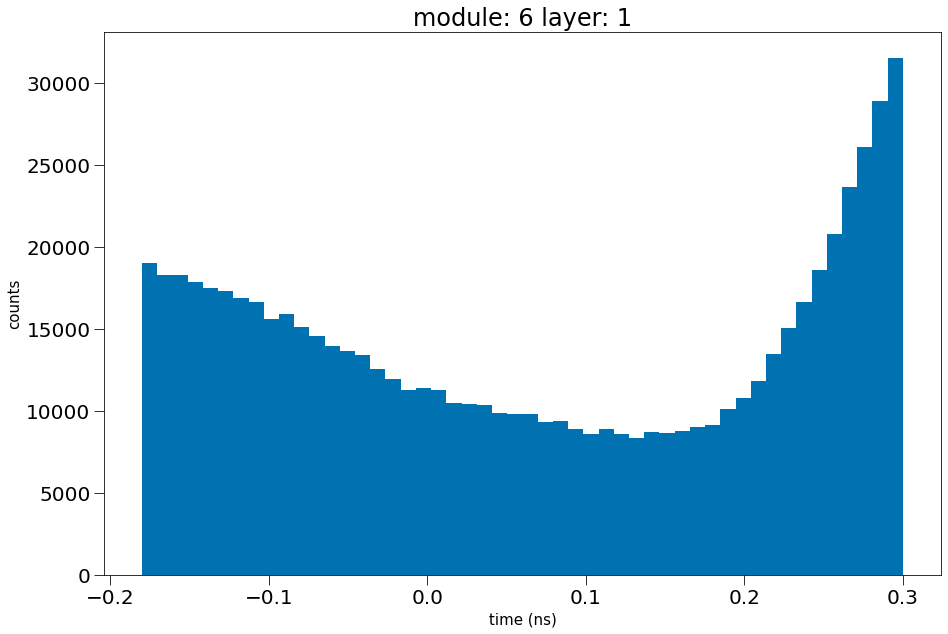

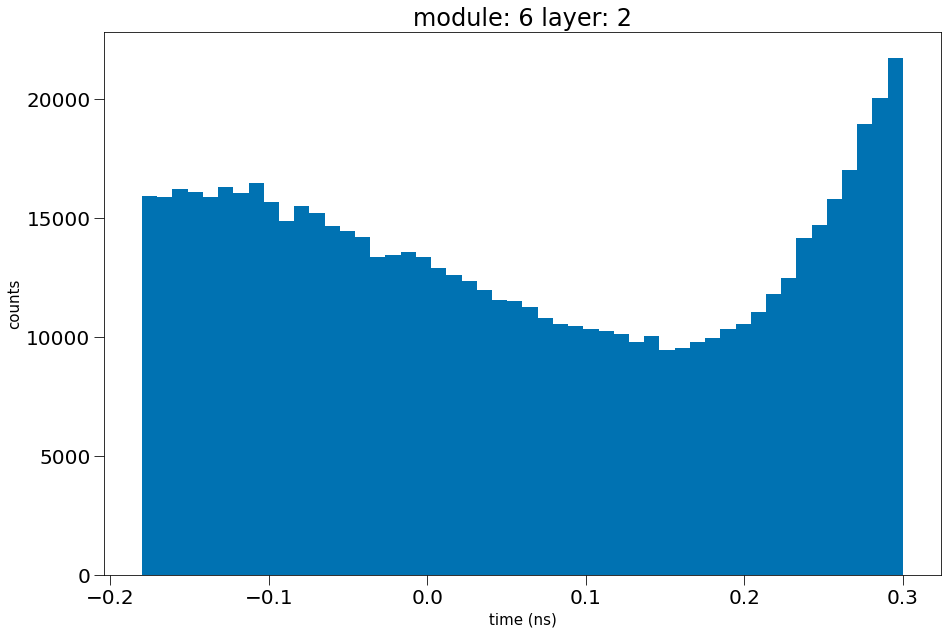

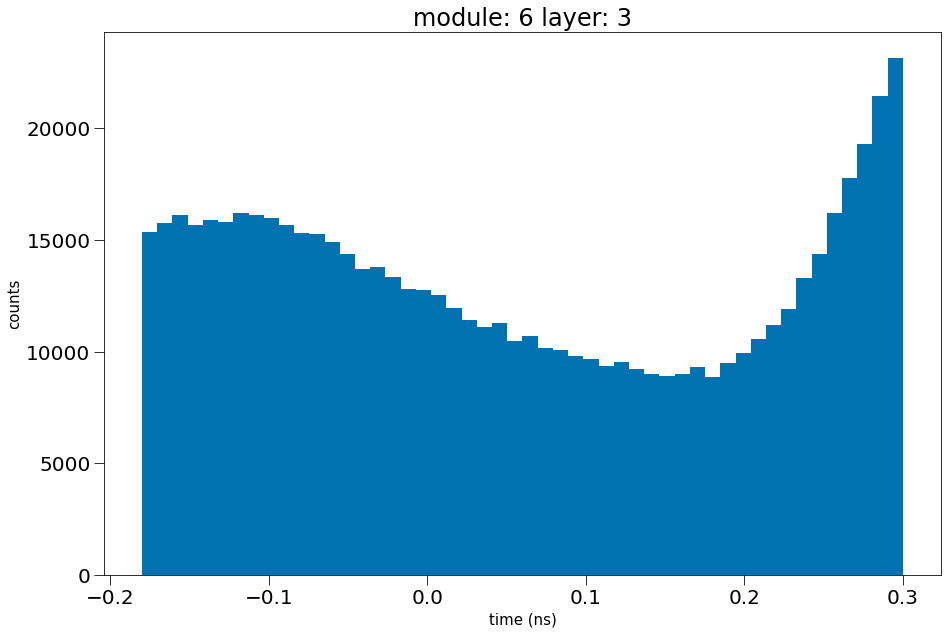

In [94]:
#Finding time distributions for every module-layer pair in the BIB
for i in range(6):
    inMod=(treeBIB["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(treeBIB["layer"].array()==j)
        inside=inLayer & inMod
        time=treeBIB["t"].array()[inside]
        plot1DHistogram(time, bins=50, label=("module: " +str(i+1) + " layer: " + str(j) +";time (ns);counts"))

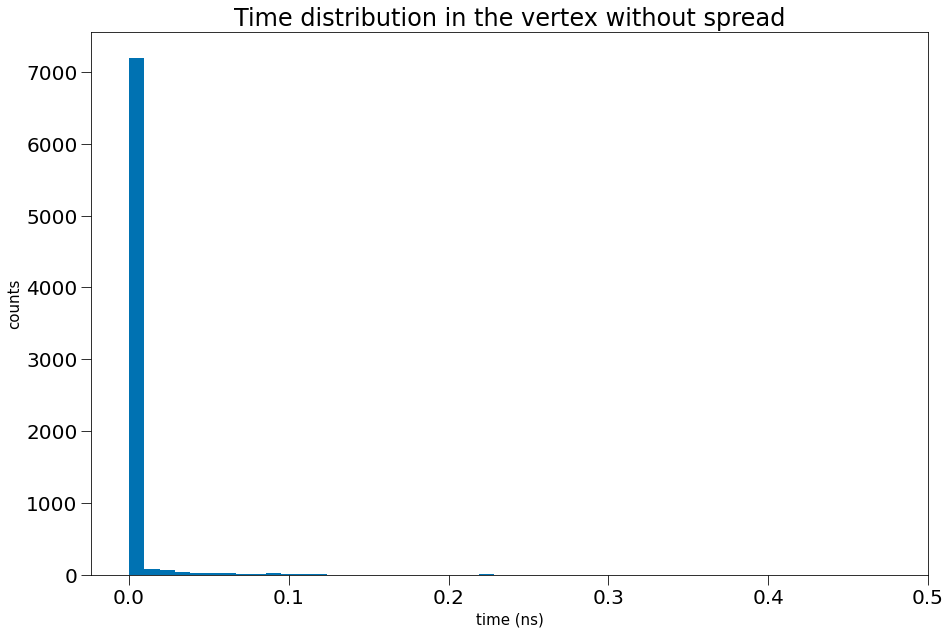

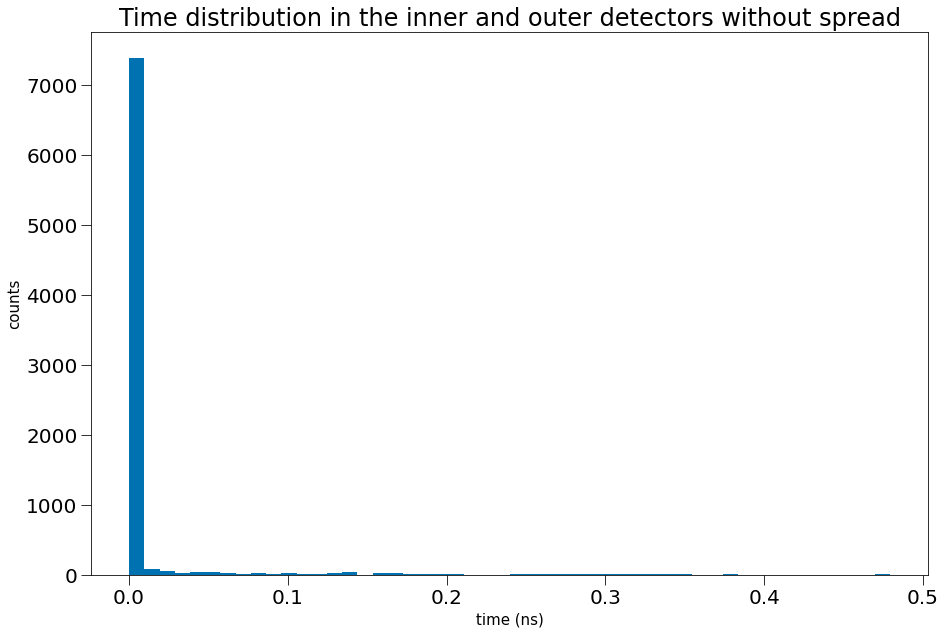

In [85]:
#Showing the distribution of hits form Silicon layer collections
t30=np.array([])
t60=np.array([])
for i in range(6):
    inMod=(tree["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(tree["layer"].array()==j)
        inside=inLayer & inMod
        time=tree["t"].array()[inside]-np.sqrt(tree["x"].array()[inside]**2+tree["y"].array()[inside]**2+tree["z"].array()[inside]**2)/c
        if i <=1:
            t30=np.append(t30,time)
        else:
            t60=np.append(t60,time)
plot1DHistogram(t30, bins=50, label=("Time distribution in the vertex without spread;time (ns);counts"), savefig=True)
plot1DHistogram(t60, bins=50, label=("Time distribution in the inner and outer detectors without spread;time (ns);counts"), savefig=True)

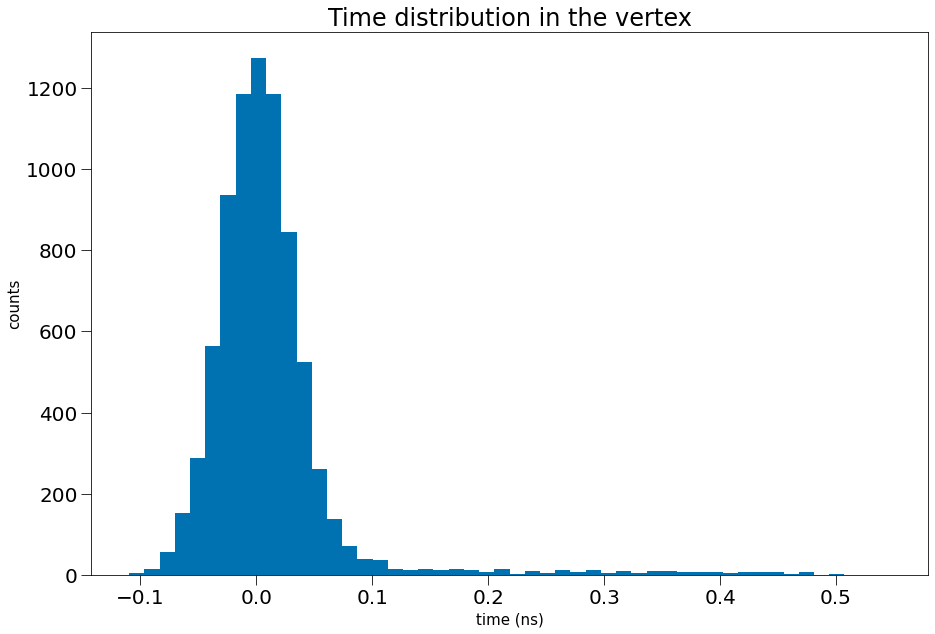

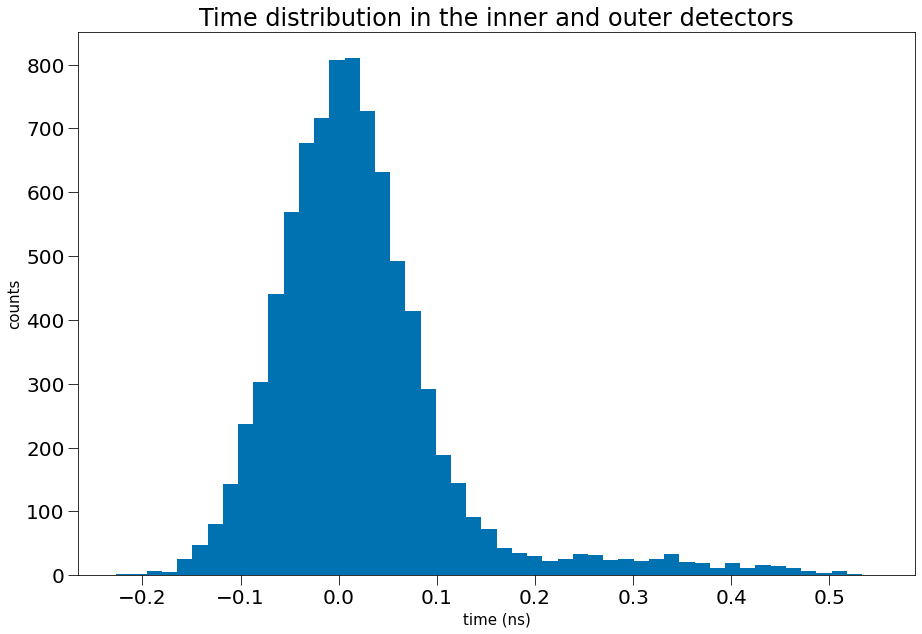

In [95]:
t30=np.array([])
t60=np.array([])
for i in range(6):
    inMod=(tree["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(tree["layer"].array()==j)
        inside=inLayer & inMod
        time=tree["t"].array()[inside]-np.sqrt(tree["x"].array()[inside]**2+tree["y"].array()[inside]**2+tree["z"].array()[inside]**2)/c
        if i <=1:
            t30=np.append(t30,time+norm.rvs(size=np.sum(inside), scale=0.03)) #adding 30 ps time resolution to vertex hits
        else:
            t60=np.append(t60,time+norm.rvs(size=np.sum(inside), scale=0.06)) #adding 60 ps time resolution to inner detector and outer detector hits
plot1DHistogram(t30, bins=50, label=("Time distribution in the vertex;time (ns);counts"))
plot1DHistogram(t60, bins=50, label=("Time distribution in the inner and outer detectors;time (ns);counts"))

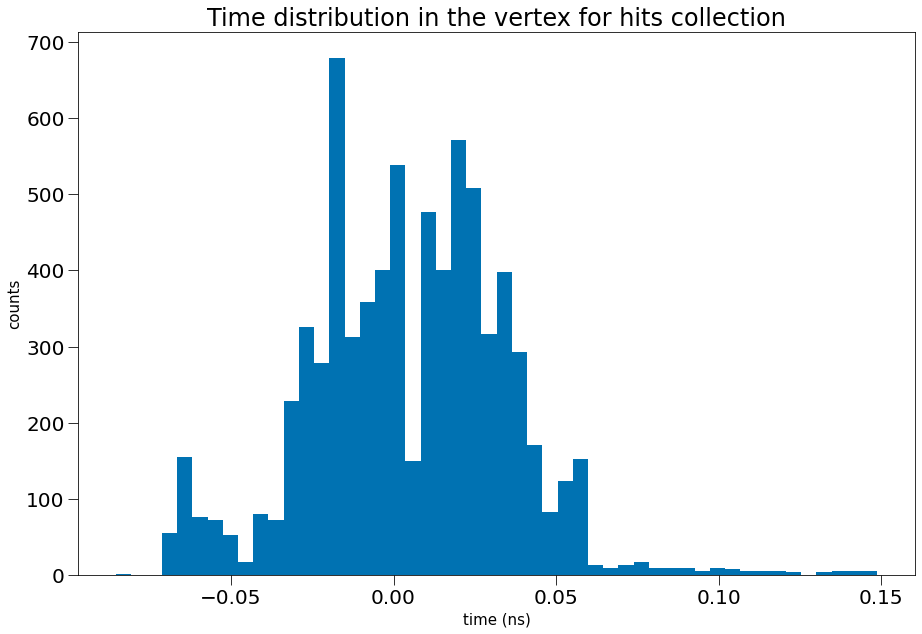

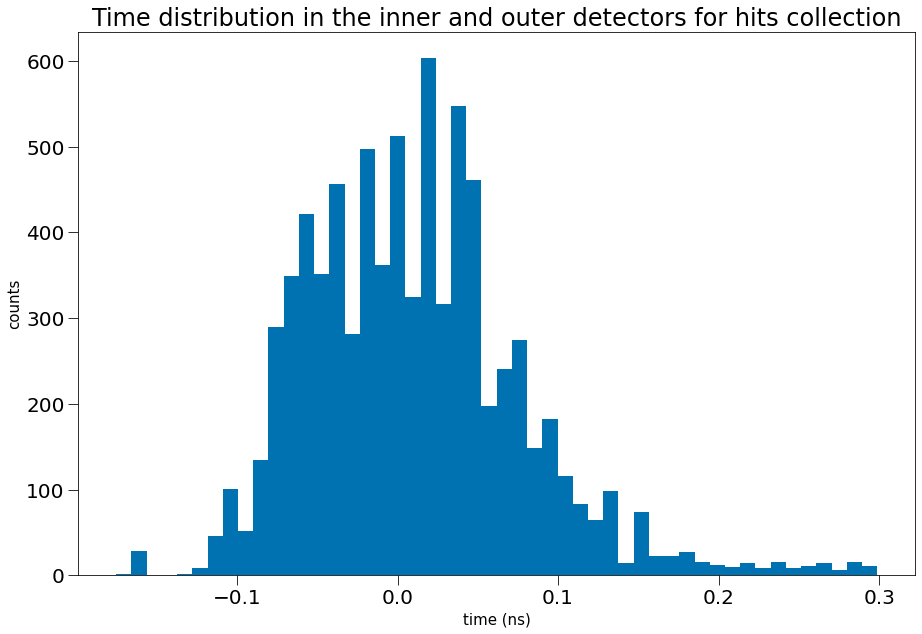

In [106]:
t30=np.array([])
t60=np.array([])
for i in range(6):
    inMod=(treeNOBIB["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(treeNOBIB["layer"].array()==j)
        inside=inLayer & inMod
        time=treeNOBIB["t"].array()[inside]
        if i <=1:
            t30=np.append(t30,time)
        else:
            t60=np.append(t60,time)
plot1DHistogram(t30, bins=50, label=("Time distribution in the vertex for hits collection;time (ns);counts"))
plot1DHistogram(t60, bins=50, label=("Time distribution in the inner and outer detectors for hits collection;time (ns);counts"))

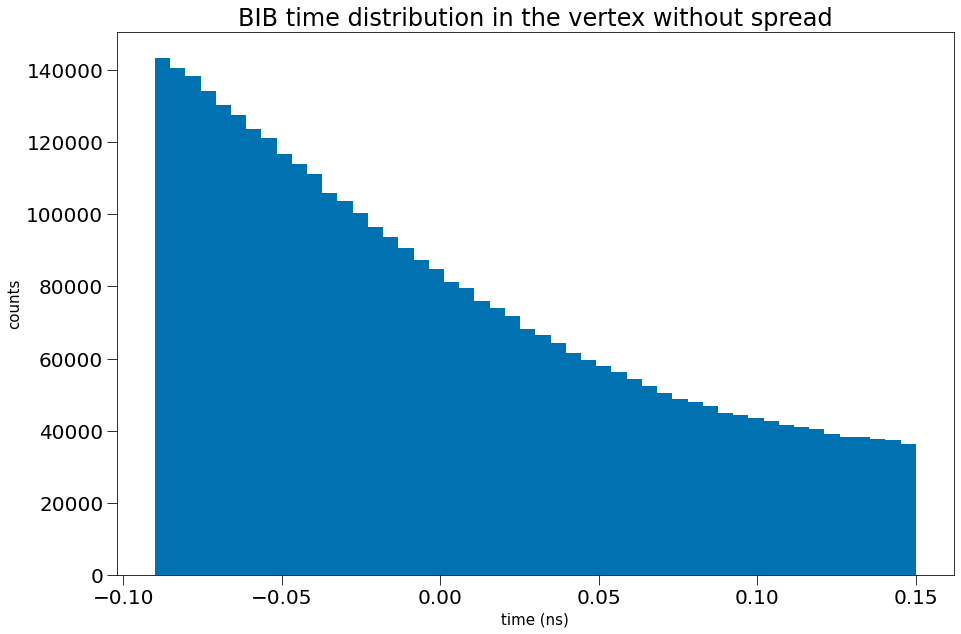

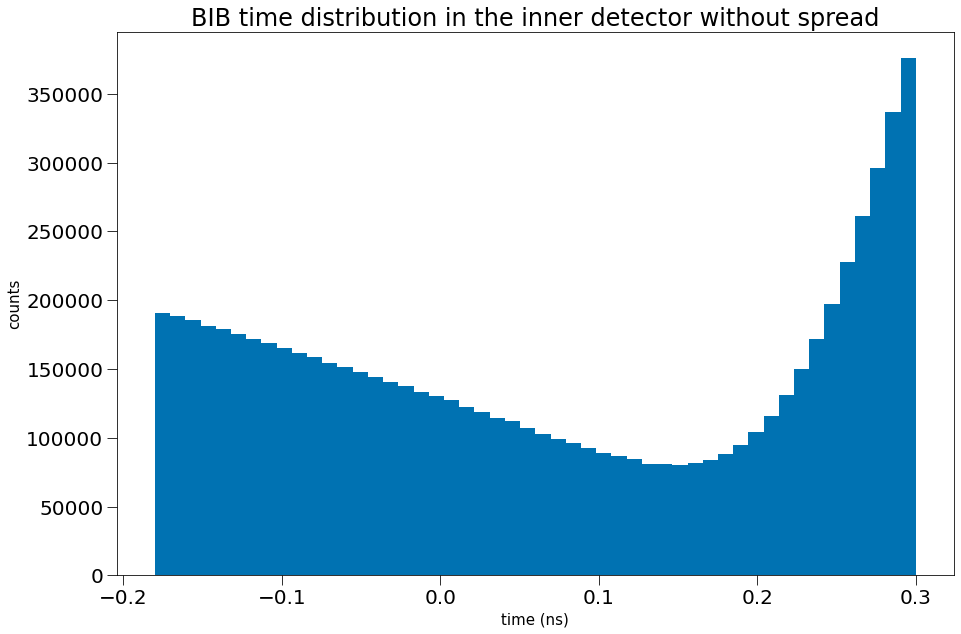

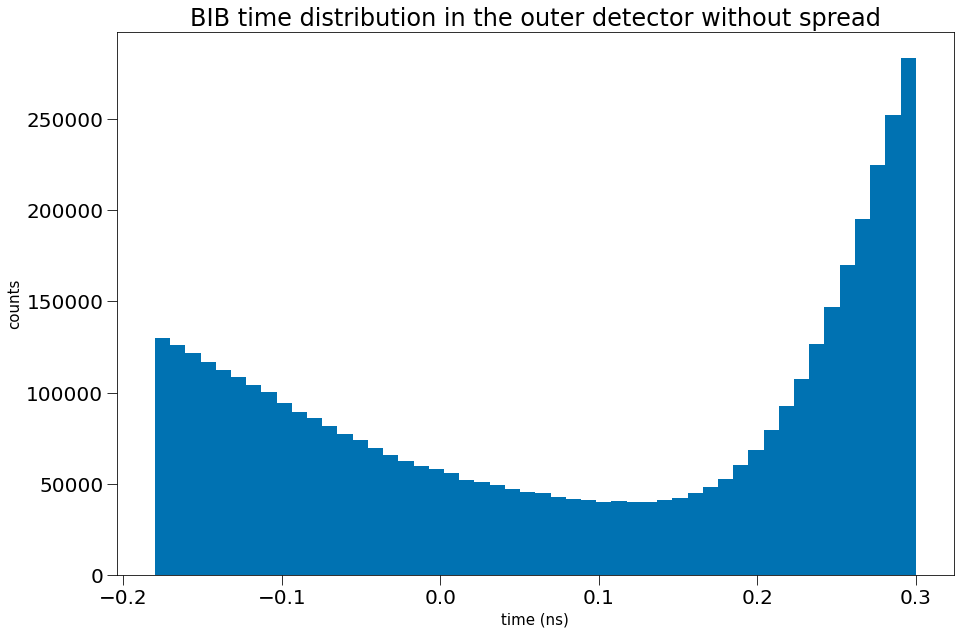

In [93]:
#Showing the distribution of hits form Silicon layer collections for BIB
tVer=np.array([])
tIn=np.array([])
tOut=np.array([])
for i in range(6):
    inMod=(treeBIB["module"].array()==(i+1))
    for j in range(layerPerModule[i+1]):
        inLayer=(treeBIB["layer"].array()==j)
        inside=inLayer & inMod
        time=treeBIB["t"].array()[inside]
        if i <=1:
            tVer=np.append(tVer,time)
        elif i <= 3:
            tIn=np.append(tIn,time)
        else:
            tOut=np.append(tOut,time)
plot1DHistogram(tVer, bins=50, label=("BIB time distribution in the vertex without spread;time (ns);counts"))
plot1DHistogram(tIn, bins=50, label=("BIB time distribution in the inner detector without spread;time (ns);counts"))
plot1DHistogram(tOut, bins=50, label=("BIB time distribution in the outer detector without spread;time (ns);counts"))

In [19]:
print("Minimum start percentile in vertex is " + str(norm.cdf(-0.1, scale=0.03)))
print("Max end percentile in vertex is " + str(norm.cdf(0.15, scale=0.03)))
print("Minimum start percentile in the inner and outer detector is " + str(norm.cdf(-0.2, scale=0.06)))
print("Max end percentile in the inner and outer detector is " + str(norm.cdf(0.3, scale=0.06)))

Minimum start percentile in vertex is 0.0004290603331968372
Max end percentile in vertex is 0.9999997133484281
Minimum start percentile in the inner and outer detector is 0.0004290603331968372
Max end percentile in the inner and outer detector is 0.9999997133484281


In [20]:
vertStartTime=norm.ppf(q=np.linspace(norm.cdf(-0.1, scale=0.03),0.05,10),scale=0.03)
vertEndTime=norm.ppf(q=np.linspace(0.95,norm.cdf(0.15, scale=0.03),10),scale=0.03)
innerOuterStartTime=norm.ppf(q=np.linspace(norm.cdf(-0.2, scale=0.06),0.05,10),scale=0.06)
innerOuterEndTime=norm.ppf(q=np.linspace(0.95,norm.cdf(0.3, scale=0.06),10),scale=0.06)

#### Code to find the best start and end time by applying a sliding window that covers 95% of the normal distribution for each level. Too slow to run locally so run the TimeWindowAnalysis.py on the server
startTime=[]
endTime=[]
minCount=[]
for i in range(6):
    print(i)
    startTime.append([])
    endTime.append([])
    minCount.append([])
    for j in range(layerPerModule[i+1]):
        print(j)
        minimum=math.inf
        minStart=0
        minEnd=1
        inside=((treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==(j)))
        if i <=1:
            for startNum, start in enumerate(vertStartTime):
                countInside=np.sum((treeBIB["t"].array()[inside] >= start) & (treeBIB["t"].array()[inside] <= vertEndTime[startNum]))
                if minimum > countInside:
                    minimum=countInside
                    minStart=start
                    minEnd=vertEndTime[startNum]
        else:
            for startNum, start in enumerate(innerOuterStartTime):
                countInside=np.sum((treeBIB["t"].array()[inside] >= start) & (treeBIB["t"].array()[inside] <= innerOuterEndTime[startNum]))
                if minimum > countInside:
                    minimum=countInside
                    minStart=start
                    minEnd=innerOuterEndTime[startNum]
        
        startTime[i].append(minStart)
        endTime[i].append(minEnd)
        minCount[i].append(minimum)
        

sumation=0
for i in minCount:
    for j in i:
        sumation+=j
print(sumation)
print(1-sumation/len(treeBIB["x"].array()))

### Results from server

#### These results are from a run with 20 ranges per layer

In [21]:
start=[[-0.052704798217557164, -0.052704798217557164, -0.05365707810604041, -0.05466671046187578, -0.05365707810604041, -0.05365707810604041, -0.05466671046187578, -0.05574234924716146], [-0.052704798217557164, -0.052704798217557164, -0.052704798217557164, -0.05365707810604041, -0.05574234924716146, -0.05574234924716146, -0.056894823586371074, -0.056894823586371074], [-0.10360568304841201, -0.10360568304841201, -0.10540959643511433], [-0.10540959643511433, -0.11148469849432292, -0.11148469849432292, -0.118979467411623, -0.12194869518530481, -0.12898200386066813, -0.1332911753002702], [-0.10360568304841201, -0.10360568304841201, -0.10540959643511433], [-0.10360568304841201, -0.10933342092375156, -0.11148469849432292, -0.11148469849432292]]
# ns
#First list is list of modules, the nested list is of layers
#Data gotten from the server

In [22]:
end=[[0.06921117778178475, 0.06921117778178475, 0.06664558765013508, 0.06449100193033404, 0.06664558765013508, 0.06664558765013508, 0.06449100193033404, 0.06262528431868229], [0.06921117778178475, 0.06921117778178475, 0.06921117778178475, 0.06664558765013508, 0.06262528431868229, 0.06262528431868229, 0.06097434759265236, 0.06097434759265236], [0.14482474822411326, 0.14482474822411326, 0.1384223555635695], [0.1384223555635695, 0.12525056863736458, 0.12525056863736458, 0.11627589065116978, 0.11378964717274218, 0.10933342092375156, 0.10731415621208082], [0.14482474822411326, 0.14482474822411326, 0.1384223555635695], [0.14482474822411326, 0.12898200386066808, 0.12525056863736458, 0.12525056863736458]]
# ns
#First list is list of modules, the nested list is of layers
#Data gotten from the server

In [23]:
# Also going to calculate even windows for every layer to see if there is a noticable increase
startEven30=norm.ppf(0.025, scale=0.03)
endEven30=norm.ppf(0.975, scale=0.03)
startEven60=norm.ppf(0.025, scale=0.06)
endEven60=norm.ppf(0.975, scale=0.06)

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

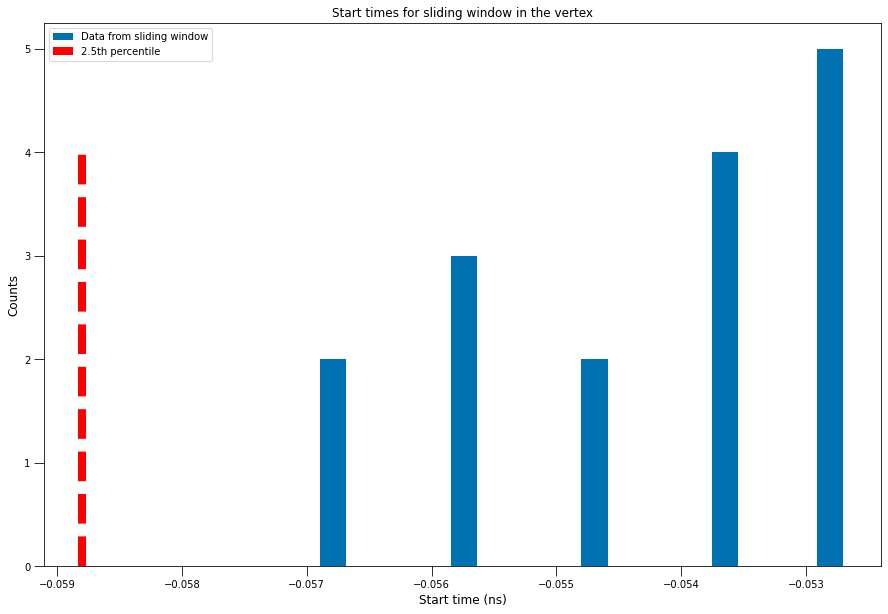

In [24]:
#Makes sense when you look at the BIB distribution in each of the modules
vertStart=start[0][:]
vertStart.extend(start[1])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart, bins=20, label="Data from sliding window")
ax.vlines(startEven30, ymin=0, ymax=4, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompVert.png")

Text(0.5, 1.0, 'Start times for sliding window in the inner detector')

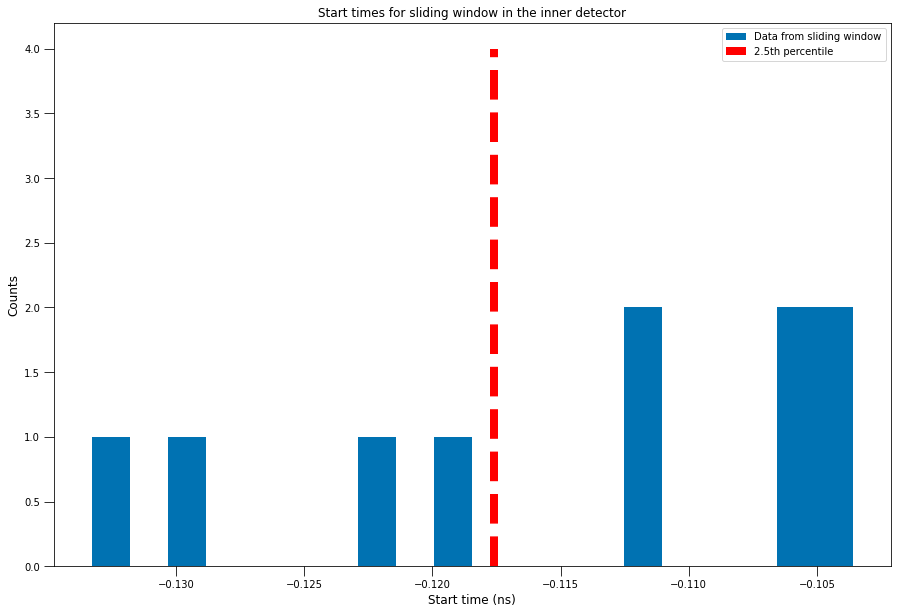

In [25]:
innerStart=start[2][:]
innerStart.extend(start[3])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(innerStart, bins=20, label="Data from sliding window")
ax.vlines(startEven60, ymin=0, ymax=4, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the inner detector")
#plt.savefig("cutoffCompIn.png")

Text(0.5, 1.0, 'Start times for sliding window in the outer detector')

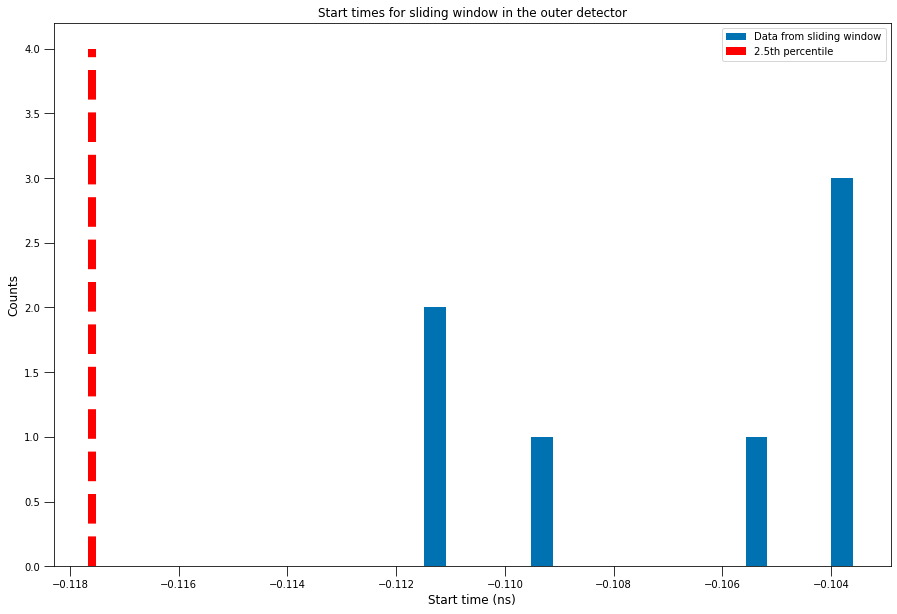

In [26]:
outerStart=start[4][:]
outerStart.extend(start[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(outerStart, bins=20, label="Data from sliding window")
ax.vlines(startEven60, ymin=0, ymax=4, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the outer detector")
#plt.savefig("cutoffCompOut.png")

Text(0.5, 1.0, 'Start times for sliding window in the outer detector')

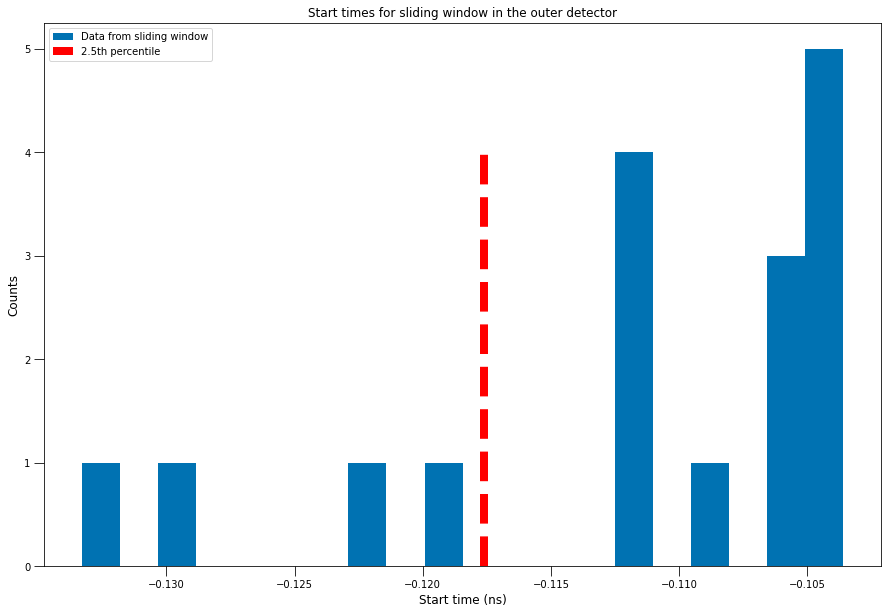

In [27]:
inOuterStart=start[2][:]
inOuterStart.extend(start[3])
inOuterStart.extend(start[4])
inOuterStart.extend(start[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(inOuterStart, bins=20, label="Data from sliding window")
ax.vlines(startEven60, ymin=0, ymax=4, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the outer detector")
#plt.savefig("cutoffCompInOut.png")

In [28]:
#Calculating the BIB reduction fraction for a cutoff that is even around 0
sumationEvenSigma=0
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=startEven30) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=endEven30))
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=startEven60) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=endEven60))
print(1-sumationEvenSigma/len(treeBIB["t"].array()))

0.5656441591902874


In [29]:
#Caluclating the BIB reduction fraction in the vertex for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=startEven30) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=endEven30))/np.sum(treeBIB["module"].array()<=2))

0.4473622457653953


In [30]:
#Caluclating the BIB reduction fraction in the inner and outer detectors for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=startEven60) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=endEven60))/np.sum(treeBIB["module"].array()>2))

0.6038249991793322


In [31]:
#Calculating the BIB reduction in the vertex for the maximum sliding window reduction
vertSum=0
for i in range(2):
    for j in range(len(start[i])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==j)]
        vertSum+=np.sum((data >= start[i][j]) & (data<=end[i][j]))
print(1-vertSum/np.sum(treeBIB["module"].array()<=2))

0.4598678593642712


In [32]:
#Calculating the BIB reduction in the inner and outer detector for the maximum sliding window reduction
inOutSum=0
for i in range(4):
    for j in range(len(start[i+2])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+3)) & (treeBIB["layer"].array()==j)]
        inOutSum+=np.sum((data >= start[i+2][j]) & (data<=end[i+2][j]))
print(1-inOutSum/np.sum(treeBIB["module"].array()>2))

0.6156550002336889


In [33]:
#Calculating the overall BIB reduction for the maximum sliding window reduction
print(1-(inOutSum+vertSum)/len(treeBIB["x"].array()))

0.5776390266674447


#### these are from a run with 200 ranges per layer

In [34]:
#start200=[[-0.05253808523328422, -0.05307169934132219, -0.05400025492419453, -0.053810388302713515, -0.05390505171961999, -0.053436994200932245, -0.054096005077517884, -0.055085274460265614], [-0.05280280409761126, -0.05253808523328422, -0.05298159409032027, -0.05307169934132219, -0.055708855295530435, -0.055603246727007165, -0.05646818193187825, -0.05680498892114718], [-0.10353509642774278, -0.10421154053472396, -0.104727705825662], [-0.10455479001323563, -0.1109966455090711, -0.11227669108605134, -0.11798721910234006, -0.12310065603727395, -0.1289219222730916, -0.13436794434003266], [-0.10404118705853238, -0.104727705825662, -0.10421154053472396], [-0.10455479001323563, -0.10838461897432328, -0.11141771059106087, -0.11037511735998727]]
start200=[[-0.05259501300743452, -0.05303615351080213, -0.053860385104094806, -0.05376678200475244, -0.053860385104094806, -0.05367369941936559, -0.05414438592624209, -0.05492641318359554], [-0.052682332985762116, -0.052682332985762116, -0.05294700630148337, -0.05303615351080213, -0.0556426946957568, -0.055538415940668544, -0.05650216672947722, -0.0567244525603541], [-0.10349073526580722, -0.1041604482582556, -0.1043299206891198], [-0.10467138461072407, -0.11086960786098106, -0.11234888942435182, -0.11801996403184659, -0.12309157587620448, -0.128855380201143, -0.13423518929127776], [-0.1041604482582556, -0.10467138461072407, -0.1043299206891198], [-0.10450022957867978, -0.10848028043329633, -0.1112853893915136, -0.11045908317923137]]
# ns
#First list is list of modules, the nested list is of layers
#Data gotten from the server by calculating 200 ranges per layer that are evenly spaced in terms of start percentile

In [35]:
#end200=[[0.06973399640446805, 0.0681455701097856, 0.0658595781168151, 0.06628681536418209, 0.06607152176779692, 0.06718397217001633, 0.065650871497725, 0.0637206464667612], [0.06891564378007375, 0.06973399640446805, 0.06839728054163903, 0.0681455701097856, 0.06267810274416129, 0.06284665529138693, 0.06155032801863699, 0.06109249717000801], [0.14511946490359345, 0.1424508433195756, 0.1406197084426944], [0.1412155697042219, 0.12603443072657583, 0.12404591886022671, 0.11721334967664082, 0.11293636386375644, 0.10936482384828919, 0.10687398840186449], [0.14309185179034364, 0.1406197084426944, 0.1424508433195756], [0.1412155697042219, 0.1308905894311417, 0.12535620548832258, 0.127082985205049]]
end200=[[0.06955250861612851, 0.06824413552790463, 0.06617253089421452, 0.06638756620078996, 0.06617253089421452, 0.0666060674620439, 0.06554706143882302, 0.06400577694690278], [0.06928012025465496, 0.06928012025465496, 0.06849555596461468, 0.06824413552790463, 0.06278333478849767, 0.06295167055018672, 0.06150303110812898, 0.06119980676561349], [0.14530680174893493, 0.1426410598330121, 0.14201659355358384], [0.14081194009370845, 0.1262440240617937, 0.12393999054597957, 0.11718145584849475, 0.11294287252701882, 0.10939971754938023, 0.10692700275567149], [0.1426410598330121, 0.14081194009370845, 0.14201659355358384], [0.14140714200938578, 0.13068951941890156, 0.12556666957699533, 0.12693786080528185]]
# ns
#First list is list of modules, the nested list is of layers
#Data gotten from the server by calculating 200 ranges per layer that are evenly spaced in terms of start percentile

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

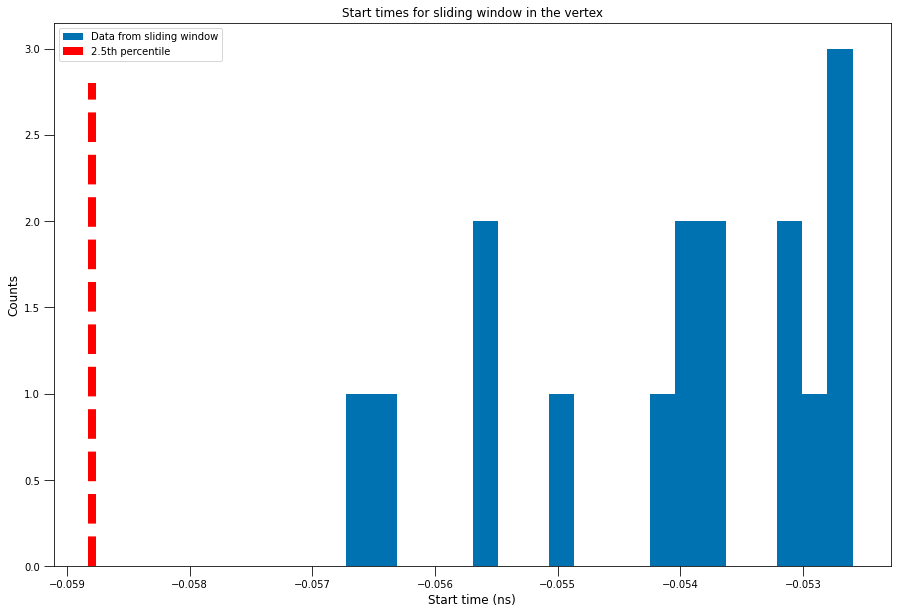

In [36]:
vertStart=start200[0][:]
vertStart.extend(start200[1])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart, bins=20, label="Data from sliding window")
ax.vlines(startEven30, ymin=0, ymax=2.8, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompVert200.png")

Text(0.5, 1.0, 'Start times for sliding window in the inner detector')

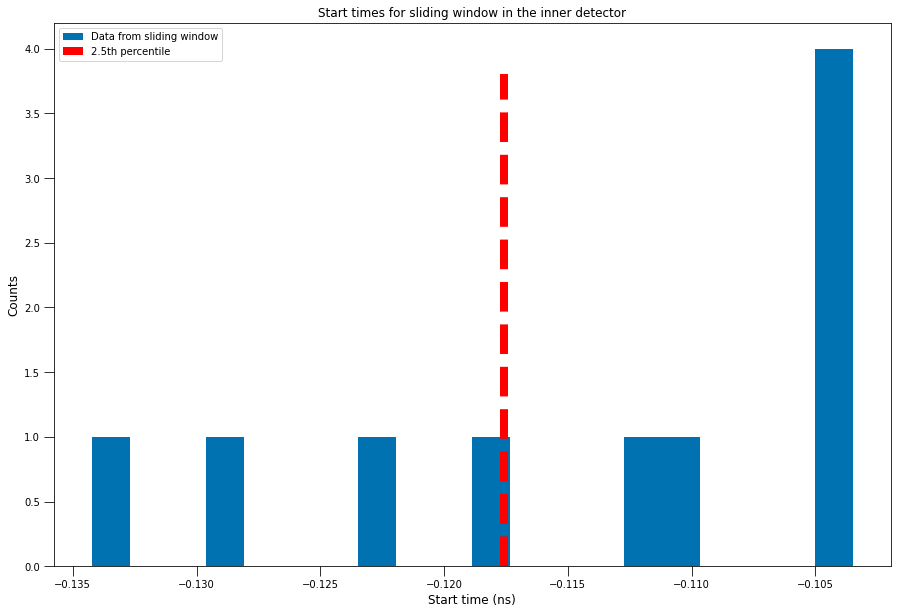

In [37]:
innerStart=start200[2][:]
innerStart.extend(start200[3])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(innerStart, bins=20, label="Data from sliding window")
ax.vlines(startEven60, ymin=0, ymax=3.8, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the inner detector")
#plt.savefig("cutoffCompIn200.png")

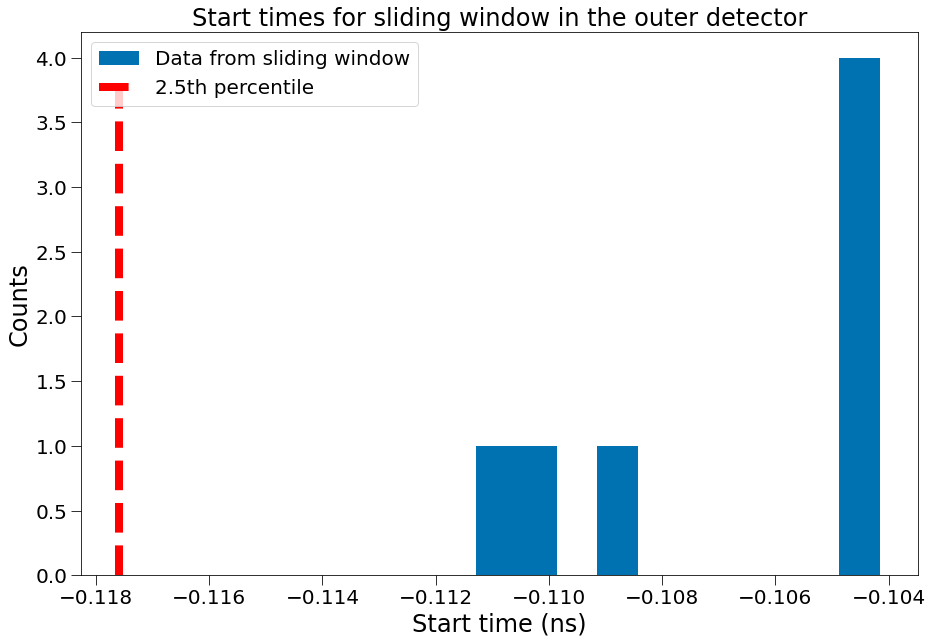

In [97]:
outerStart=start200[4][:]
outerStart.extend(start200[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(outerStart, bins=10, label="Data from sliding window")
ax.vlines(startEven60, ymin=0, ymax=3.8, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the outer detector")
plt.savefig("cutoffCompOut200.png")

Text(0.5, 1.0, 'Start times for sliding window in the inner and outer detector')

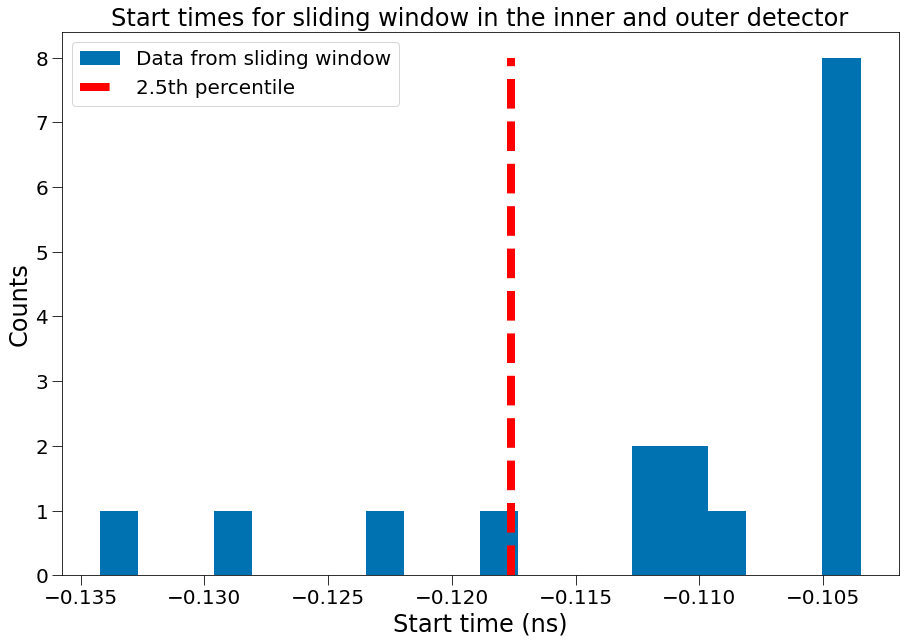

In [96]:
inOuterStart=start200[2][:]
inOuterStart.extend(start200[3])
inOuterStart.extend(start200[4])
inOuterStart.extend(start200[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(inOuterStart, bins=20, label="Data from sliding window")
ax.vlines(startEven60, ymin=0, ymax=8, linewidth=8, colors="r", linestyle="dashed", label="2.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the inner and outer detector")
#plt.savefig("cutoffCompInOut200.png")

In [40]:
#Calculating the BIB reduction in the vertex for the maximum sliding window reduction
vertSum200=0
for i in range(2):
    for j in range(len(start[i])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==j)]
        vertSum200+=np.sum((data >= start200[i][j]) & (data<=end200[i][j]))
print(1-vertSum200/np.sum(treeBIB["module"].array()<=2))

0.4600142268106796


In [41]:
#Calculating the BIB reduction in the inner and outer detector for the maximum sliding window reduction
inOutSum200=0
for i in range(4):
    for j in range(len(start[i+2])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+3)) & (treeBIB["layer"].array()==j)]
        inOutSum200+=np.sum((data >= start200[i+2][j]) & (data<=end200[i+2][j]))
print(1-inOutSum200/np.sum(treeBIB["module"].array()>2))

0.6157496633141291


In [42]:
#Overall BIB reduction for sliding window
overallBIB95=1-(inOutSum200+vertSum200)/len(treeBIB["x"].array())
print(overallBIB95)

0.5777463069112716


#### 99% signal efficency data taken with 40 ranges

In [43]:
start99=[[-0.07188748728956817, -0.07188748728956817, -0.07255671127243751, -0.07290534695271743, -0.07255671127243751, -0.07290534695271743, -0.07363367923767324, -0.07290534695271743], [-0.07255671127243751, -0.07188748728956817, -0.07255671127243751, -0.07188748728956817, -0.07363367923767324, -0.07401476647455682, -0.07440818504103186, -0.07440818504103186], [-0.14443521507559323, -0.14443521507559323, -0.14511342254487503], [-0.14443521507559323, -0.14881637008206372, -0.14962966415041715, -0.15519650006762337, -0.15739164326876268, -0.20000000000000004, -0.20000000000000004], [-0.14443521507559323, -0.14511342254487503, -0.14511342254487503], [-0.14511342254487503, -0.14802953294911364, -0.14962966415041715, -0.14881637008206372]]

In [44]:
end99=[[0.08777270975535105, 0.08777270975535105, 0.08540034985732962, 0.0843891443305908, 0.08540034985732962, 0.0843891443305908, 0.0826149492889317, 0.0843891443305908], [0.08540034985732962, 0.08777270975535105, 0.08540034985732962, 0.08777270975535105, 0.0826149492889317, 0.08182595714884278, 0.08108980159176477, 0.08108980159176477], [0.17303803911541027, 0.17303803911541027, 0.17080069971465925], [0.17303803911541027, 0.16217960318352953, 0.16079891409007616, 0.1539204895531206, 0.15201733434651665, 0.1405653806310398, 0.1405653806310398], [0.17303803911541027, 0.17080069971465925, 0.17080069971465925], [0.17080069971465925, 0.16365191429768555, 0.16079891409007616, 0.16217960318352953]]

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

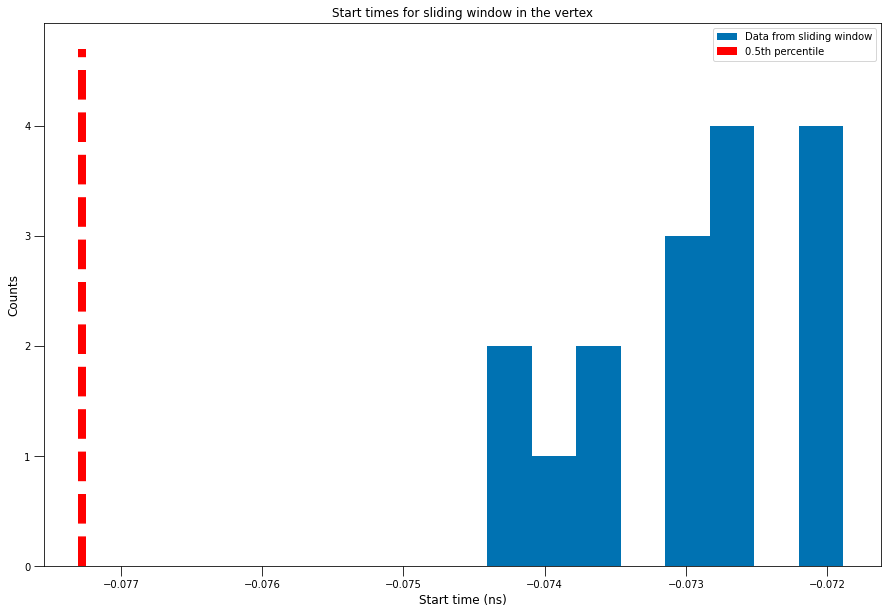

In [45]:
vertStart=start99[0][:]
vertStart.extend(start99[1])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.005,scale=0.03), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="0.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompVert99.png")

Text(0.5, 1.0, 'Start times for sliding window in the inner detector')

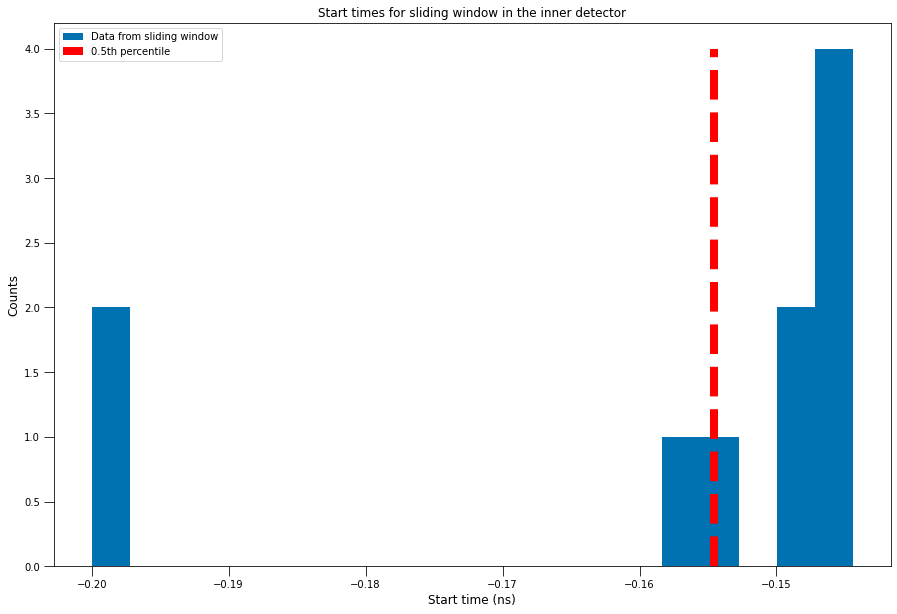

In [46]:
innerStart=start99[2][:]
innerStart.extend(start99[3])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(innerStart, bins=20, label="Data from sliding window")
ax.vlines(norm.ppf(0.005,scale=0.06), ymin=0, ymax=4, linewidth=8, colors="r", linestyle="dashed", label="0.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the inner detector")
#plt.savefig("cutoffCompIn99.png")

Text(0.5, 1.0, 'Start times for sliding window in the outer detector')

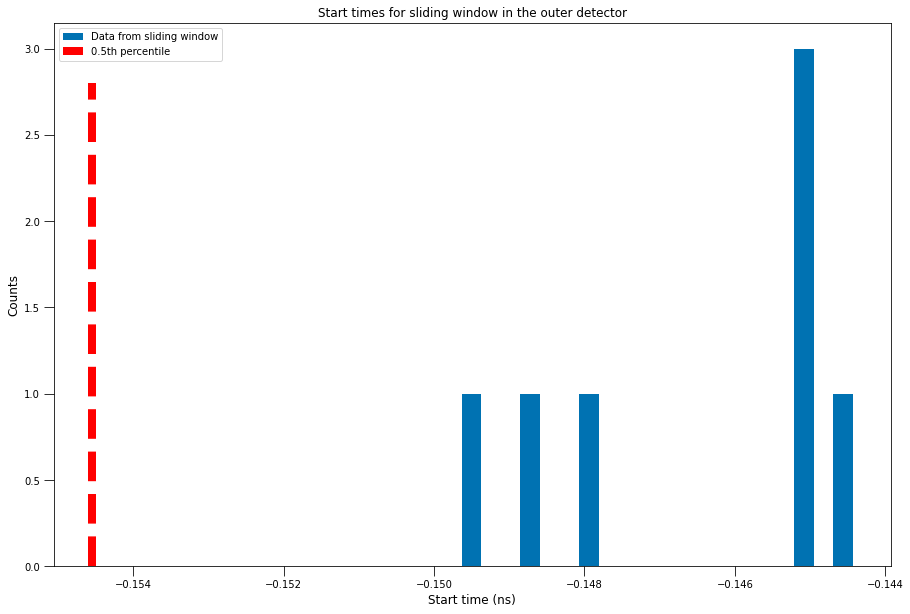

In [47]:
outerStart=start99[4][:]
outerStart.extend(start99[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(outerStart, bins=20, label="Data from sliding window")
ax.vlines(norm.ppf(0.005,scale=0.06), ymin=0, ymax=2.8, linewidth=8, colors="r", linestyle="dashed", label="0.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the outer detector")
#plt.savefig("cutoffCompOut99.png")

Text(0.5, 1.0, 'Start times for sliding window in the outer detector')

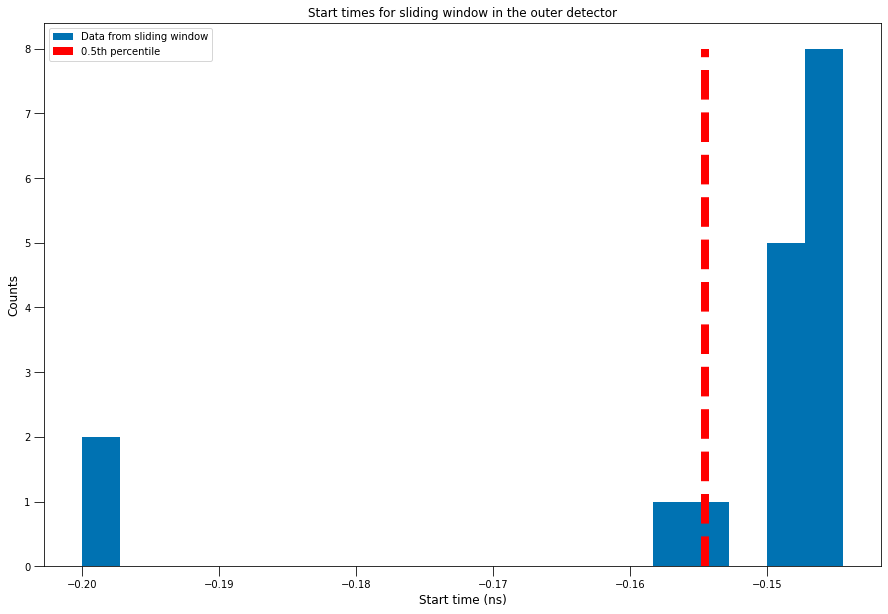

In [48]:
inOuterStart=start99[2][:]
inOuterStart.extend(start99[3])
inOuterStart.extend(start99[4])
inOuterStart.extend(start99[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(inOuterStart, bins=20, label="Data from sliding window")
ax.vlines(norm.ppf(0.005,scale=0.06), ymin=0, ymax=8, linewidth=8, colors="r", linestyle="dashed", label="0.5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the outer detector")
#plt.savefig("cutoffCompInOut99.png")

In [49]:
#Calculating the BIB reduction fraction for a cutoff that is even around 0
sumationEvenSigma=0
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=norm.ppf(0.005,scale=0.03)) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=norm.ppf(0.995,scale=0.03)))
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=norm.ppf(0.005,scale=0.06)) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=norm.ppf(0.995,scale=0.06)))
print(1-sumationEvenSigma/len(treeBIB["t"].array()))

0.4186389324044689


In [50]:
#Caluclating the BIB reduction fraction in the vertex for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=norm.ppf(0.005,scale=0.03)) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=norm.ppf(0.995,scale=0.03)))/np.sum(treeBIB["module"].array()<=2))

0.2632246403946298


In [51]:
#Caluclating the BIB reduction fraction in the inner and outer detectors for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=norm.ppf(0.005,scale=0.06)) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=norm.ppf(0.995,scale=0.06)))/np.sum(treeBIB["module"].array()>2))

0.4688059278767419


In [52]:
#Calculating the BIB reduction in the vertex for the maximum sliding window reduction
vertSum99=0
for i in range(2):
    for j in range(len(start[i])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==j)]
        vertSum99+=np.sum((data >= start99[i][j]) & (data<=end99[i][j]))
print(1-vertSum99/np.sum(treeBIB["module"].array()<=2))

0.27831204961462264


In [53]:
#Calculating the BIB reduction in the inner and outer detector for the maximum sliding window reduction
inOutSum99=0
for i in range(4):
    for j in range(len(start[i+2])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+3)) & (treeBIB["layer"].array()==j)]
        inOutSum99+=np.sum((data >= start99[i+2][j]) & (data<=end99[i+2][j]))
print(1-inOutSum99/np.sum(treeBIB["module"].array()>2))

0.47951116867425625


In [54]:
#Overall BIB reduction for sliding window
overallBIB99=1-(inOutSum99+vertSum99)/len(treeBIB["x"].array())
print(overallBIB99)

0.4304135323158489


#### 90% signal efficency data taken with 40 ranges

In [55]:
start90=[[-0.04276177854565746, -0.043298832349280426, -0.043850132385014166, -0.044416651756543454, -0.044999468556222576, -0.044416651756543454, -0.044416651756543454, -0.044416651756543454], [-0.043298832349280426, -0.043298832349280426, -0.043298832349280426, -0.04276177854565746, -0.04621893024689886, -0.04621893024689886, -0.04685841581377868, -0.04685841581377868], [-0.08245534419719486, -0.08345392827833599, -0.08345392827833599], [-0.08552355709131491, -0.09119956351174352, -0.09371683162755735, -0.09931444270202865, -0.10247128235368239, -0.11192099668690987, -0.11662779099512705], [-0.08345392827833599, -0.08447617902099164, -0.08345392827833599], [-0.08345392827833599, -0.08999893711244515, -0.09119956351174352, -0.08999893711244515]]

In [56]:
end90=[[0.05987384503300973, 0.05852863800885264, 0.057291749151546646, 0.05614521416419776, 0.05507526387679524, 0.05614521416419776, 0.05614521416419776, 0.05614521416419776], [0.05852863800885264, 0.05852863800885264, 0.05852863800885264, 0.05987384503300973, 0.05312410507431952, 0.05312410507431952, 0.05222726319531603, 0.05222726319531603], [0.12970480865796233, 0.12598974107362254, 0.12598974107362254], [0.11974769006601946, 0.10814220607884177, 0.10445452639063206, 0.09807846213107428, 0.09526664108021439, 0.08902672387888583, 0.0867807971714461], [0.12598974107362254, 0.1227029129453778, 0.12598974107362254], [0.12598974107362254, 0.11015052775359048, 0.10814220607884177, 0.11015052775359048]]

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

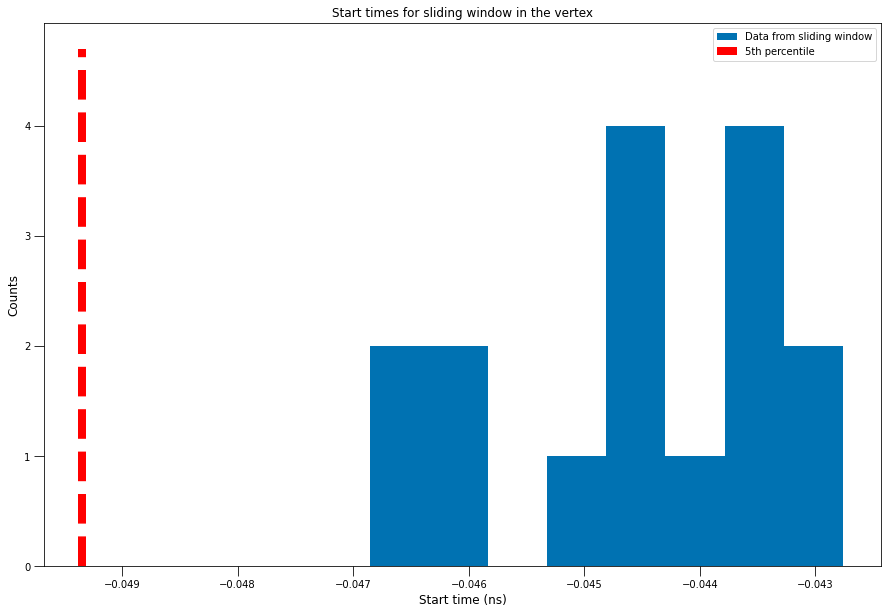

In [57]:
vertStart90=start90[0][:]
vertStart90.extend(start90[1])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart90, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.05,scale=0.03), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompVert99.png")

Text(0.5, 1.0, 'Start times for sliding window in the inner detector')

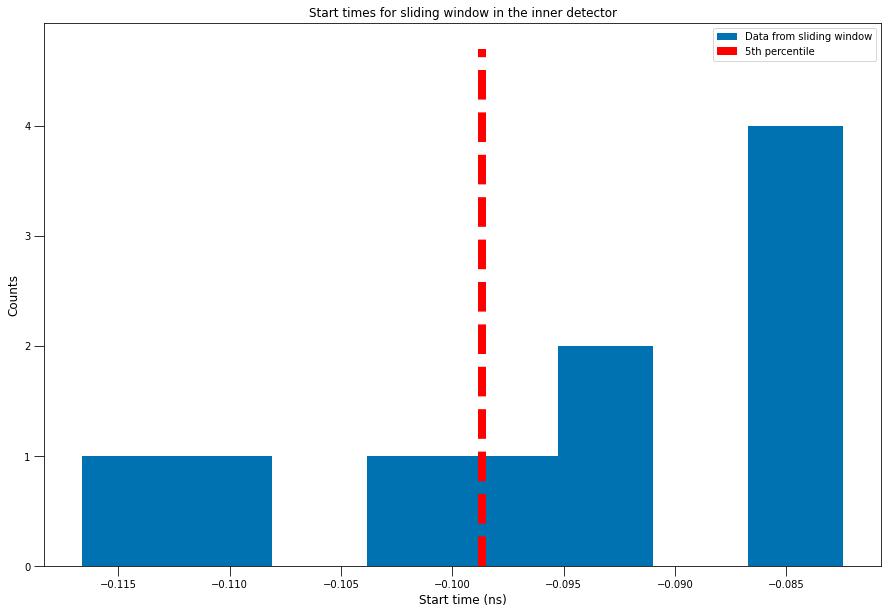

In [58]:
inStart90=start90[2][:]
inStart90.extend(start90[3])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(inStart90, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.05,scale=0.06), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the inner detector")
#plt.savefig("cutoffCompVert99.png")

Text(0.5, 1.0, 'Start times for sliding window in the outer detector')

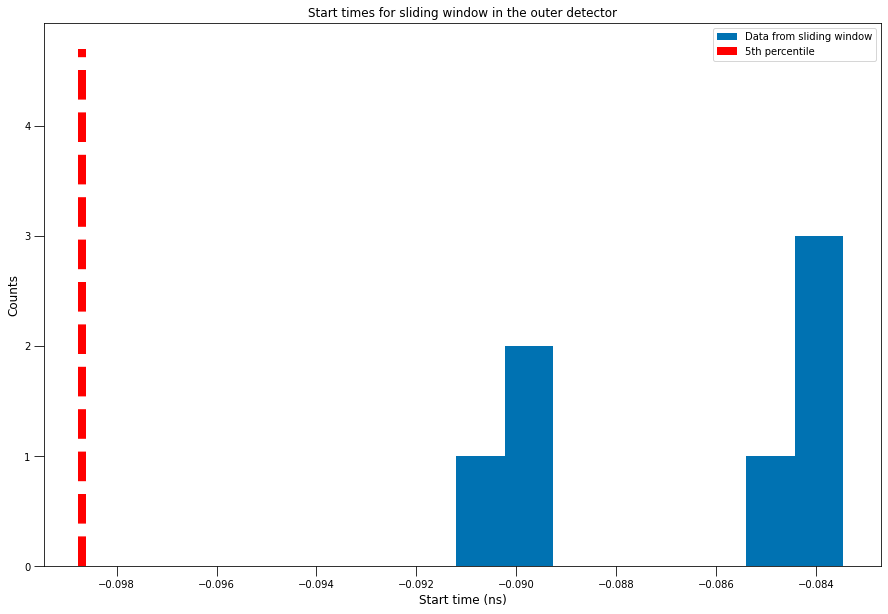

In [59]:
inStart90=start90[4][:]
inStart90.extend(start90[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(inStart90, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.05,scale=0.06), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the outer detector")
#plt.savefig("cutoffCompVert99.png")

Text(0.5, 1.0, 'Start times for sliding window in the inner and outer detector')

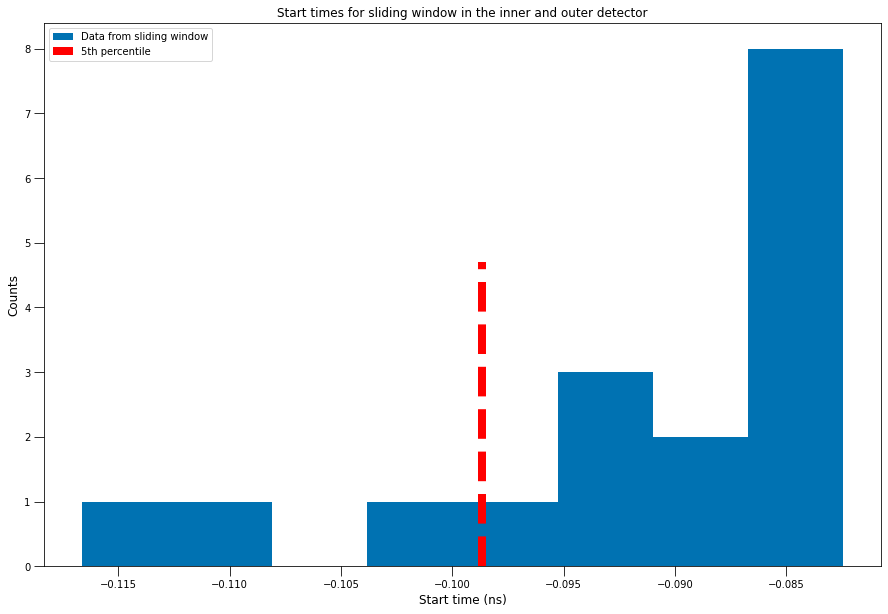

In [60]:
inOutStart90=start90[2][:]
inOutStart90.extend(start90[3])
inOutStart90.extend(start90[4])
inOutStart90.extend(start90[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(inOutStart90, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.05,scale=0.06), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="5th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the inner and outer detector")
#plt.savefig("cutoffCompVert99.png")

In [61]:
#Calculating the BIB reduction fraction for a cutoff that is even around 0
sumationEvenSigma=0
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=norm.ppf(0.05,scale=0.03)) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=norm.ppf(0.95,scale=0.03)))
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=norm.ppf(0.05,scale=0.06)) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=norm.ppf(0.95,scale=0.06)))
print(1-sumationEvenSigma/len(treeBIB["t"].array()))

0.638169066738828


In [62]:
#Caluclating the BIB reduction fraction in the vertex for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=norm.ppf(0.05,scale=0.03)) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=norm.ppf(0.95,scale=0.03)))/np.sum(treeBIB["module"].array()<=2))

0.5392386948228232


In [63]:
#Caluclating the BIB reduction fraction in the inner and outer detectors for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=norm.ppf(0.05,scale=0.06)) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=norm.ppf(0.95,scale=0.06)))/np.sum(treeBIB["module"].array()>2))

0.6701033210200642


In [64]:
#Calculating the BIB reduction in the vertex for the maximum sliding window reduction
vertSum90=0
for i in range(2):
    for j in range(len(start[i])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==j)]
        vertSum90+=np.sum((data >= start90[i][j]) & (data<=end90[i][j]))
print(1-vertSum90/np.sum(treeBIB["module"].array()<=2))

0.5502117860743856


In [65]:
#Calculating the BIB reduction in the inner and outer detector for the maximum sliding window reduction
inOutSum90=0
for i in range(4):
    for j in range(len(start[i+2])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+3)) & (treeBIB["layer"].array()==j)]
        inOutSum90+=np.sum((data >= start90[i+2][j]) & (data<=end90[i+2][j]))
print(1-inOutSum90/np.sum(treeBIB["module"].array()>2))

0.6811241902425945


In [66]:
#Overall BIB reduction for sliding window
overallBIB90=1-(inOutSum90+vertSum90)/len(treeBIB["x"].array())
print(overallBIB90)

0.6491782769369279


#### 80% efficency data taken with 20 ranges

In [67]:
start80=[[-0.031244227236257787, -0.031913880937620195, -0.03330325153207188, -0.03330325153207188, -0.03402548007142956, -0.032599825833787385, -0.03476798680294378, -0.03330325153207188], [-0.031244227236257787, -0.031244227236257787, -0.031244227236257787, -0.031913880937620195, -0.03476798680294378, -0.03553242558727075, -0.03632065943307206, -0.03713479805893233], [-0.058645513553395666, -0.058645513553395666, -0.058645513553395666], [-0.061179580258059155, -0.0710648511745415, -0.0710648511745415, -0.07595448871416954, -0.08140837284355325, -0.08763286044670916, -0.0923728157640515], [-0.058645513553395666, -0.05989919077102138, -0.05989919077102138], [-0.05989919077102138, -0.06805096014285912, -0.06953597360588756, -0.06953597360588756]]

In [68]:
end80=[[0.049007767254956966, 0.04760122718761535, 0.04506574315018159, 0.04506574315018159, 0.04391032700016836, 0.04629216304783035, 0.04281660324476028, 0.04506574315018159], [0.049007767254956966, 0.049007767254956966, 0.049007767254956966, 0.04760122718761535, 0.04281660324476028, 0.04177700159271353, 0.040785280170966214, 0.03983622886828574], [0.10808344215448089, 0.10808344215448089, 0.10808344215448089], [0.10106222466104205, 0.08355400318542706, 0.08355400318542706, 0.07785090301913075, 0.07277570226248464, 0.06817379042929643, 0.06531615599404268], [0.10808344215448089, 0.10439429575953892, 0.10439429575953892], [0.10439429575953892, 0.08782065400033671, 0.08563320648952057, 0.08563320648952057]]

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

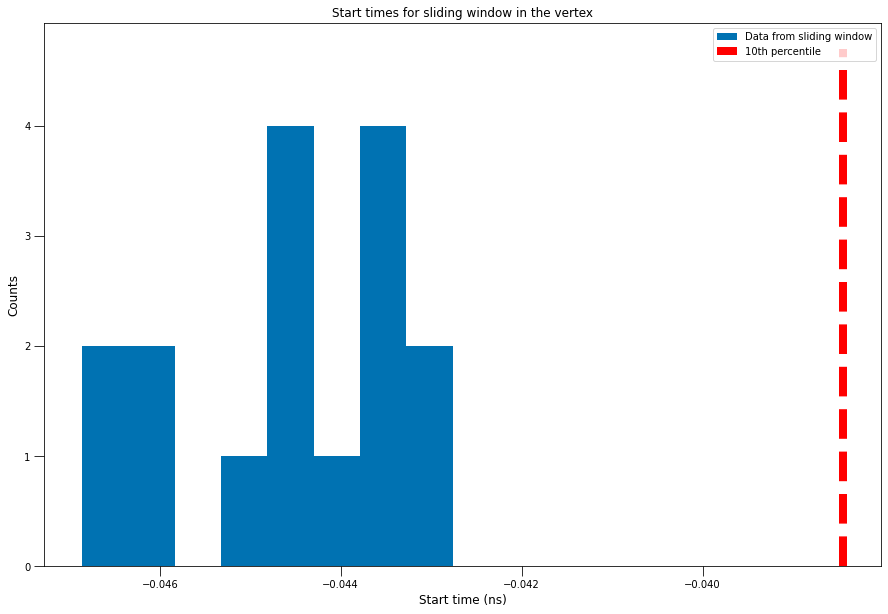

In [69]:
vertStart80=start80[0][:]
vertStart80.extend(start80[1])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart90, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.10,scale=0.03), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="10th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompVert80.png")

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

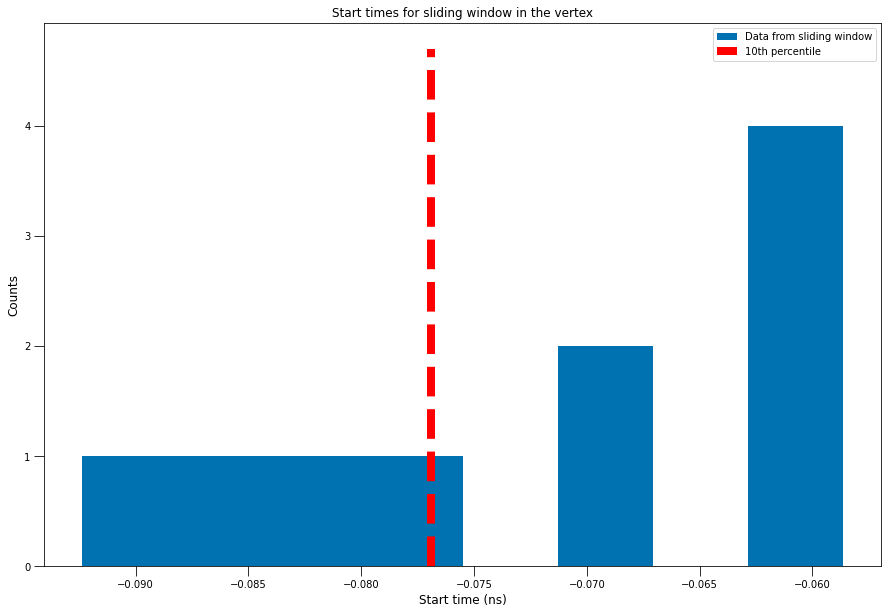

In [70]:
vertStart80=start80[2][:]
vertStart80.extend(start80[3])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart80, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.10,scale=0.06), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="10th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompIn80.png")

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

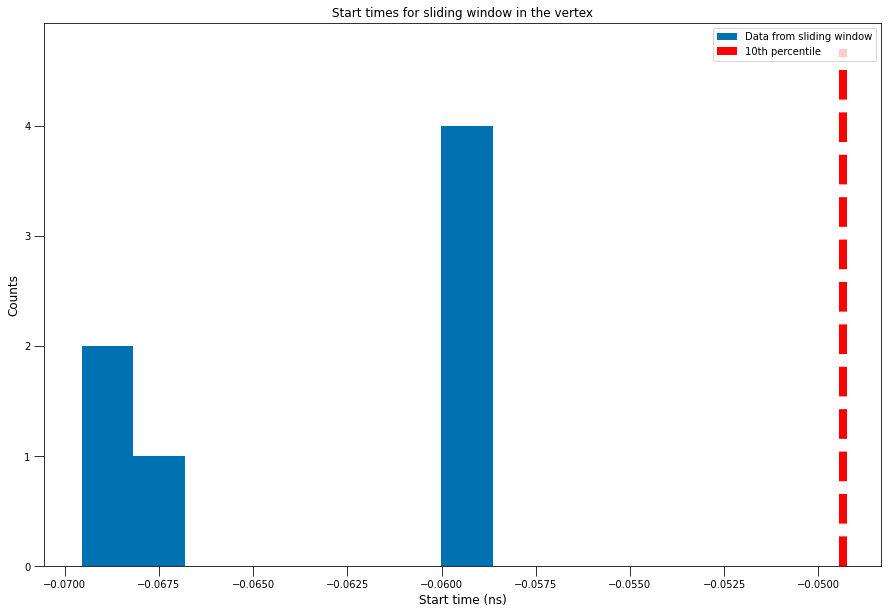

In [71]:
vertStart80=start80[4][:]
vertStart80.extend(start80[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart80, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.05,scale=0.03), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="10th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompOut80.png")

Text(0.5, 1.0, 'Start times for sliding window in the vertex')

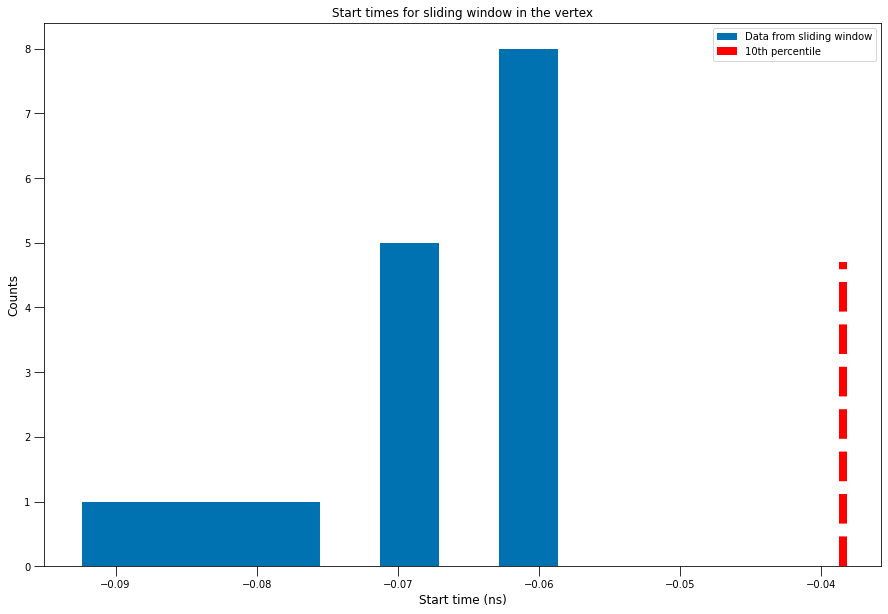

In [72]:
vertStart80=start80[2][:]
vertStart80.extend(start80[3])
vertStart80.extend(start80[4])
vertStart80.extend(start80[5])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.hist(vertStart80, bins=8, label="Data from sliding window")
ax.vlines(norm.ppf(0.10,scale=0.03), ymin=0, ymax=4.7, linewidth=8, colors="r", linestyle="dashed", label="10th percentile")
plt.legend()
ax.set_xlabel("Start time (ns)")
ax.set_ylabel("Counts")
ax.set_title("Start times for sliding window in the vertex")
#plt.savefig("cutoffCompInOut80.png")

In [73]:
#Calculating the BIB reduction fraction for a cutoff that is even around 0
sumationEvenSigma=0
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=norm.ppf(0.1,scale=0.03)) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=norm.ppf(0.90,scale=0.03)))
sumationEvenSigma+=np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=norm.ppf(0.1,scale=0.06)) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=norm.ppf(0.90,scale=0.06)))
print(1-sumationEvenSigma/len(treeBIB["t"].array()))

0.7199120596973196


In [74]:
#Caluclating the BIB reduction fraction in the vertex for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()<=2]>=norm.ppf(0.1,scale=0.03)) & (treeBIB["t"].array()[treeBIB["module"].array()<=2]<=norm.ppf(0.9,scale=0.03)))/np.sum(treeBIB["module"].array()<=2))

0.6434052793713085


In [75]:
#Caluclating the BIB reduction fraction in the inner and outer detectors for a cutoff that is even around 0
print(1-np.sum((treeBIB["t"].array()[treeBIB["module"].array()>2]>=norm.ppf(0.1,scale=0.06)) & (treeBIB["t"].array()[treeBIB["module"].array()>2]<=norm.ppf(0.9,scale=0.06)))/np.sum(treeBIB["module"].array()>2))

0.7446080850922698


In [76]:
#Calculating the BIB reduction in the vertex for the maximum sliding window reduction
vertSum80=0
for i in range(2):
    for j in range(len(start80[i])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+1)) & (treeBIB["layer"].array()==j)]
        vertSum80+=np.sum((data >= start80[i][j]) & (data<=end80[i][j]))
print(1-vertSum80/np.sum(treeBIB["module"].array()<=2))

0.6521190038289408


In [77]:
#Calculating the BIB reduction in the inner and outer detector for the maximum sliding window reduction
inOutSum80=0
for i in range(4):
    for j in range(len(start[i+2])):
        data=treeBIB["t"].array()[(treeBIB["module"].array()==(i+3)) & (treeBIB["layer"].array()==j)]
        inOutSum80+=np.sum((data >= start80[i+2][j]) & (data<=end80[i+2][j]))
print(1-inOutSum80/np.sum(treeBIB["module"].array()>2))

0.7541107824387092


In [78]:
#Overall BIB reduction for sliding window
overallBIB80=1-(inOutSum80+vertSum80)/len(treeBIB["x"].array())
print(overallBIB80)

0.7292222278509259


# Overall Summary

#### I checked the sliding window for 99.9% which converged with the symetrical bounds

In [79]:
#calculating the symetrical BIB reduction as a function of signal efficency
signalEff=np.linspace(80,99,40)
BIBVert=np.zeros_like(signalEff) #Total BIB hits reduced as a function of signalEff
BIBInOut=np.zeros_like(signalEff) 
for i, sig in enumerate(signalEff):
    dataVer=treeBIB["t"].array()[treeBIB["module"].array()<=2]
    BIBVert[i]+=np.sum((dataVer>=norm.ppf((100-sig)/200,scale=0.03)) & (dataVer<=norm.ppf(1-(100-sig)/200,scale=0.03)))
    dataInOut=treeBIB["t"].array()[treeBIB["module"].array()>2]
    BIBInOut[i]+=np.sum((dataInOut>=norm.ppf((100-sig)/200,scale=0.06)) & (dataInOut<=norm.ppf(1-(100-sig)/200,scale=0.06)))
BIBRedF=1-(BIBVert+BIBInOut)/len(treeBIB["t"].array()) #Calculate the fraction of reduction
BIBVertF=1-(BIBVert)/len(treeBIB["t"].array()[treeBIB["module"].array()<=2]) #Calculate the fraction of reduction vertex
BIBInOutF=1-(BIBInOut)/len(treeBIB["t"].array()[treeBIB["module"].array()>2]) #Calculate the fraction of reduction in the inner and outer detector

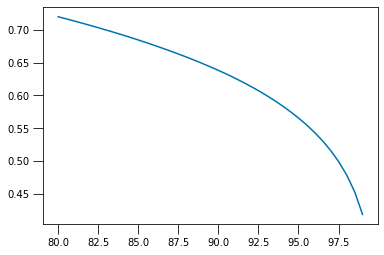

In [80]:
plt.plot(signalEff,BIBRedF)

In [81]:
#Repeating last calculation for the final 1%
signalEff99=np.linspace(99,99.9,20)
BIBVert99=np.zeros_like(signalEff99) #Total BIB hits reduced as a function of signalEff
BIBInOut99=np.zeros_like(signalEff99)
for i, sig in enumerate(signalEff99):
    dataVer=treeBIB["t"].array()[treeBIB["module"].array()<=2]
    BIBVert99[i]+=np.sum((dataVer>=norm.ppf((100-sig)/200,scale=0.03)) & (dataVer<=norm.ppf(1-(100-sig)/200,scale=0.03)))
    dataInOut=treeBIB["t"].array()[treeBIB["module"].array()>2]
    BIBInOut99[i]+=np.sum((dataInOut>=norm.ppf((100-sig)/200,scale=0.06)) & (dataInOut<=norm.ppf(1-(100-sig)/200,scale=0.06)))
BIBRedF99=1-(BIBVert99+BIBInOut99)/len(treeBIB["t"].array()) #Calculate the fraction of reduction
BIBVertF99=1-(BIBVert99)/len(treeBIB["t"].array()[treeBIB["module"].array()<=2]) #Calculate the fraction of reduction in the vertex
BIBInOutF99=1-(BIBInOut99)/len(treeBIB["t"].array()[treeBIB["module"].array()>2]) #Calculate the fraction of reduction in the inner and outer detector

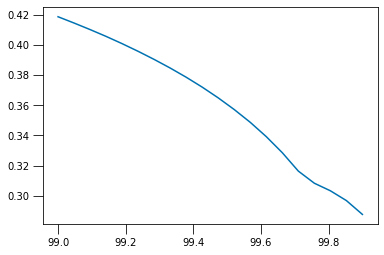

In [82]:
plt.plot(signalEff99,BIBRedF99)

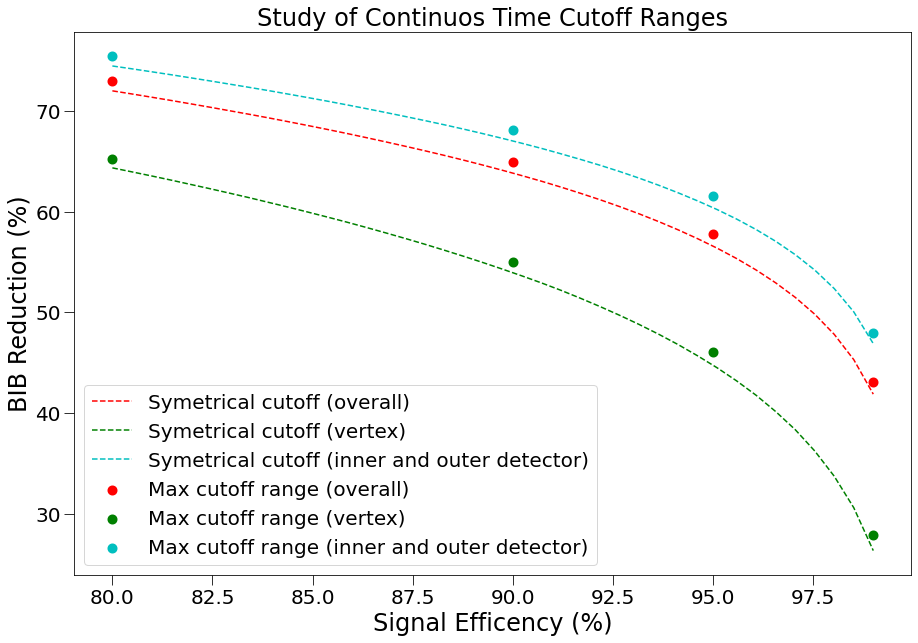

In [86]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

ax.plot(signalEff,100*BIBRedF, c="r", linestyle="dashed", label="Symetrical cutoff (overall)")
ax.plot(signalEff,100*BIBVertF, c="g", linestyle="dashed", label="Symetrical cutoff (vertex)")
ax.plot(signalEff,100*BIBInOutF, c="c", linestyle="dashed", label="Symetrical cutoff (inner and outer detector)")

ax.scatter(x=(80,90,95,99),y=[overallBIB80*100,overallBIB90*100, overallBIB95*100, overallBIB99*100], c="r",linewidths=4, label="Max cutoff range (overall)")
ax.scatter(x=(80,90,95,99),y=[(1-vertSum80/np.sum(treeBIB["module"].array()<=2))*100,(1-vertSum90/np.sum(treeBIB["module"].array()<=2))*100, (1-vertSum200/np.sum(treeBIB["module"].array()<=2))*100, (1-vertSum99/np.sum(treeBIB["module"].array()<=2))*100], c="g",linewidths=4, label="Max cutoff range (vertex)")
ax.scatter(x=(80,90,95,99),y=[(1-inOutSum80/np.sum(treeBIB["module"].array()>2))*100,(1-inOutSum90/np.sum(treeBIB["module"].array()>2))*100, (1-inOutSum200/np.sum(treeBIB["module"].array()>2))*100,(1-inOutSum99/np.sum(treeBIB["module"].array()>2))*100], c="c",linewidths=4, label="Max cutoff range (inner and outer detector)")

ax.set_xlabel("Signal Efficency (%)")
ax.set_ylabel("BIB Reduction (%)")
ax.set_title("Study of Continuos Time Cutoff Ranges")

plt.legend()
#plt.savefig("Study of Continuos Time Cutoff Ranges.png")